# Twin-T_variations_v0
Last update: 18 Mar 2025  
> $\large{\color {red} {\text{Note}}}$  
> This notebook is an early draft and is posted as a placeholder  
> The narrative and calculations are very preliminary  
> Spelling and grammar checks have not been completed  

ToDo  

- trim number of variations
- write narrative

| Variation | Description |
|---|---|
| LP | input connection is at R1, C1 is gnd, remove |
| HP | input connection is at C1, R1 is gnd, remove |
| BR | |
| All Pass | used two Op Amps |
| 1 | orginal BPF |
| 2 | works as an integrator |
| 3 | kind of a low pass |
| 5 | only the Twin-T elements |
| 5a | only the Twin-T elements w/ R4 to gnd |
| 5b | only the Twin-T elements w/ C to gnd, still a BPF |
| 6 | Using R4 produces a High pass filter<br>replace with a capacitor - produces a Low Pass |
| 7 | HP, R4 replaced by C produces a low pass, looks better than the other variations |  
| 8 | Op Amp config as non-inv, symbolic solution took too long |
| 9 | symbolic solution took too long |
| 10 | Trying to make a one Op Amp all pass, constant gain with a peak<br>With R4 = resistor - High pass<br>with R4 = capacitor - Low Pass<br>with R1= Cap & C1=Res - low pass with constant high freq gain<br>same but with R4=R - high pass with constant low freq gain<br>R4=ind - high pass |
| 10a | Twin-T network appled to non-inverting, works somewhat like an all pass with a dip in the response |


In [1]:
import random
from sympy import *
import numpy as np
from tabulate import tabulate
from scipy import signal
import matplotlib.pyplot as plt
import SymMNA
from IPython.display import display, Markdown, Math, Latex
from tabulate import tabulate
init_printing()

In [5]:
C, R = symbols('C R')

## LFP

![](LP-Twin-T-Active-Filter.png)


```
* C:\users\jeff64\My Documents\JupyterLab\Misc ipython notebooks\Buchla 295 10 Channel Comb Filter\LTSpice\LP-Twin-T-Active-Filter.asc
R1 3 1 15k
R2 2 5 186k
R3 4 3 15k
C1 5 0 10n
C2 4 5 10n
C3 2 3 910p
XU1 4 0 2 opamp Aol=100K GBW=10Meg
V1 1 0 1 AC 1
* A Bandpass Twin-T Active Filter Used in the Buchla 200 Electric Music Box Synthesizer
* 1000 Hz band
.lib opamp.sub
.ac dec 1000 100 1000k
* R3 for each filter is a 20 kΩ potentiometer wired as a variable resistor.
* R2 for each filter consists of a fixed resistor in series with a 100 kΩ potentiometer wired as a variable resistor.
* The transfer function simplifies conveniently under the special case of R1 = R3 and C1 = C3
* .step param Rtone list 1k 2k 5k 10k
.backanno
.end
```

In [3]:
LPF_net_list = '''
R1 3 1 1
R2 2 5 1
R3 4 3 1
C1 5 0 1
C2 4 5 1
C3 2 3 1
O1 4 0 2
V1 1 0 1
'''

### Generate Network Equations 

In [4]:
#| echo: true
report, network_df, df2, A, X, Z = SymMNA.smna(LPF_net_list)

Convert the lists of unknown node voltages and currents as well as the list of independednt voltage and current sources into SymPy matrices. 

In [5]:
X = Matrix(X)
Z = Matrix(Z)

Use the SymPy function ```Eq``` to formulate the network equations.

In [6]:
NE_sym = Eq(A*X,Z)

The equations, ```NE_sym```, define the mathematical relationship between voltages and currents in the filter circuit in terms of node voltages, $v_1$, $v_2$ etc., components $R_1$, $C_1$ etc., the Laplace variable $s$ and the indepenedent voltage source $V_1$. The equations are shown below:

In [7]:
# Put matrices into SymPy 
X = Matrix(X)
Z = Matrix(Z)

NE_sym = Eq(A*X,Z)

# display the equations
temp = ''
for i in range(shape(NE_sym.lhs)[0]):
    temp += '<p>${:s} = {:s}$</p>'.format(latex(NE_sym.lhs[i]),
        latex(NE_sym.rhs[i]))

Markdown(temp)

<p>$I_{V1} + \frac{v_{1}}{R_{1}} - \frac{v_{3}}{R_{1}} = 0$</p><p>$- C_{3} s v_{3} + I_{O1} + v_{2} \left(C_{3} s + \frac{1}{R_{2}}\right) - \frac{v_{5}}{R_{2}} = 0$</p><p>$- C_{3} s v_{2} + v_{3} \left(C_{3} s + \frac{1}{R_{3}} + \frac{1}{R_{1}}\right) - \frac{v_{4}}{R_{3}} - \frac{v_{1}}{R_{1}} = 0$</p><p>$- C_{2} s v_{5} + v_{4} \left(C_{2} s + \frac{1}{R_{3}}\right) - \frac{v_{3}}{R_{3}} = 0$</p><p>$- C_{2} s v_{4} + v_{5} \left(C_{1} s + C_{2} s + \frac{1}{R_{2}}\right) - \frac{v_{2}}{R_{2}} = 0$</p><p>$v_{1} = V_{1}$</p><p>$v_{4} = 0$</p>

The two lines of Python code below turn the free symbols from the ```NE_sym``` equations into SymPy variables and the element values contained in the netlist are put into a Python dictionary data structure to be used in the numerical solutions later in this report.

In [8]:
var(str(NE_sym.free_symbols).replace('{','').replace('}',''))
nominal_component_value = SymMNA.get_part_values(network_df)

### Solve the Network Equations
The SymPy function ```solve``` is used to obtain the node voltages and independent voltage source currents.

In [9]:
U_sym = solve(NE_sym,X)

The solution to the network equations are the node voltages expressed in terms of the Laplace variable $s$ are displayed below.

In [10]:
temp = ''
for i in U_sym.keys():
    if str(i)[0] == 'v': # only display the node voltages
        temp += '<p>${:s} = {:s}$</p>'.format(latex(i),latex(U_sym[i]))

Markdown(temp)

<p>$v_{1} = V_{1}$</p><p>$v_{2} = \frac{- C_{1} R_{2} V_{1} s - C_{2} R_{2} V_{1} s - V_{1}}{C_{1} C_{3} R_{1} R_{2} s^{2} + C_{2} C_{3} R_{1} R_{2} s^{2} + C_{2} C_{3} R_{1} R_{3} s^{2} + C_{2} R_{1} s + C_{2} R_{3} s + C_{3} R_{1} s}$</p><p>$v_{3} = \frac{C_{2} R_{3} V_{1}}{C_{1} C_{3} R_{1} R_{2} s + C_{2} C_{3} R_{1} R_{2} s + C_{2} C_{3} R_{1} R_{3} s + C_{2} R_{1} + C_{2} R_{3} + C_{3} R_{1}}$</p><p>$v_{4} = 0$</p><p>$v_{5} = - \frac{V_{1}}{C_{1} C_{3} R_{1} R_{2} s^{2} + C_{2} C_{3} R_{1} R_{2} s^{2} + C_{2} C_{3} R_{1} R_{3} s^{2} + C_{2} R_{1} s + C_{2} R_{3} s + C_{3} R_{1} s}$</p>

### Voltage Transfer Function $H(s)=\frac {v_2(s)}{v_1(s)}$
The voltage transfer function, $H(s)$, for the filter  is generated and displayed by the following code:

In [11]:
H_sym = cancel(U_sym[v2]/U_sym[v1],s)
Markdown('$H(s)={:s}$'.format(latex(H_sym)))

$H(s)=\frac{s \left(- C_{1} R_{2} - C_{2} R_{2}\right) - 1}{s^{2} \left(C_{1} C_{3} R_{1} R_{2} + C_{2} C_{3} R_{1} R_{2} + C_{2} C_{3} R_{1} R_{3}\right) + s \left(C_{2} R_{1} + C_{2} R_{3} + C_{3} R_{1}\right)}$

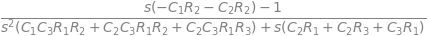

In [12]:
H_sym.cancel(s)

In [13]:
H_sym_num, H_sym_denom = fraction(H_sym,s) #returns numerator and denominator

### Numerator Polynominal
The numerator polynominal is:

In [14]:
Markdown('$N(s)={:s}$'.format(latex(H_sym_num)))

$N(s)=s \left(- C_{1} R_{2} - C_{2} R_{2}\right) - 1$

The coeficients of each Laplace terms can be equated to the variables $b_2$, $b_1$ and $b_0$ in the expression: 

$b_2s^{2}+b_1s+b_0$

where $b_2$, $b_1$ and $b_0$ are:

In [15]:
b2 = H_sym_num.coeff(s**2)
b1 = H_sym_num.coeff(s**1)
b0 = H_sym_num - b1*s*1 - b2*s**2

Markdown('<p>$b_2={:s}$</p><p>$b_1={:s}$</p><p>$b_0={:s}$</p>'.format(latex(b2),latex(b1),latex(b0)))

<p>$b_2=0$</p><p>$b_1=- C_{1} R_{2} - C_{2} R_{2}$</p><p>$b_0=-1$</p>

Notice that ther terms $b_2$ and $b_1$ are negative. This follows from the Op Amp being configured as an inverting amplifier. R2 and R3 provide a DC path from the Op Amp's output to the inverting terminal.

The roots of the numerator polynominal can easily be found with SymPy. 

This filter has two transmission zeros

In [16]:
num_root_sym = solve(H_sym_num,s)

There are two solutions, $z_1=0$ and another root at: 

In [17]:
num_root_sym

### Denominator Polynominal
The demoninator polynominal of the transfer function is called the characteristic polynominal. The roots of the denominator, also called poles of the system,  determine the system's stability. If any of these roots have a positive real part, the system is unstable, meaning its output will grow unbounded. The roots also influence how the system responds to changes in input (the transient response). They affect things like how quickly the system settles to a new state, whether it oscillates, and the damping of those oscillations. Each root of the characteristic polynominal corresponds to a natural mode of the system.

The denominator polynominal is:

In [18]:
Markdown('$D(s)={:s}$'.format(latex(H_sym_denom)))

$D(s)=s^{2} \left(C_{1} C_{3} R_{1} R_{2} + C_{2} C_{3} R_{1} R_{2} + C_{2} C_{3} R_{1} R_{3}\right) + s \left(C_{2} R_{1} + C_{2} R_{3} + C_{3} R_{1}\right)$

The coeficients of each Laplace terms can be equated to the variables $a_3$, $a_2$, $a_1$ and $a_0$ in the expression: 

$a_3s^3+a_2s^2+a_1s+a_0$

where $a_3$, $a_2$, $a_1$ and $a_0$ are:

In [19]:
a3 = H_sym_denom.coeff(s**3)
a2 = H_sym_denom.coeff(s**2)
a1 = H_sym_denom.coeff(s**1)
a0 = H_sym_denom - a1*s*1 - a2*s**2 - a3*s**3
Markdown('<p>$a_3={:s}$</p><p>$a_2={:s}$</p><p>$a_1={:s}$</p><p>$a_0={:s}$</p>'.format(latex(a3), latex(a2),latex(a1),latex(a0)))

<p>$a_3=0$</p><p>$a_2=C_{1} C_{3} R_{1} R_{2} + C_{2} C_{3} R_{1} R_{2} + C_{2} C_{3} R_{1} R_{3}$</p><p>$a_1=C_{2} R_{1} + C_{2} R_{3} + C_{3} R_{1}$</p><p>$a_0=0$</p>

The roots of the denominator polynominal can found with SymPy. The filter circuit being analyzed in this report has a denominator polynominal that SymPy can quickly solve. This is not always the case. The expressions are long and do not render well when the JupyterLab notebook is converted to PDF, so the expressions were converted to LaTex strings and then to PNG images with [latex2png](https://latex2png.com/) for this report.

In [20]:
denom_root_sym = solve(H_sym_denom,s)

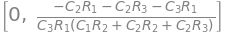

In [21]:
denom_root_sym

In [22]:
Markdown('$N_r(s)={:s}$'.format(latex(H_sym_num.subs({R1:R, R3:R, C1:C, C3:C}).collect(s))))

$N_r(s)=s \left(- C R_{2} - C_{2} R_{2}\right) - 1$

In a simular fashon, the denominator polynominal is:

In [23]:
Markdown('$D_r(s)={:s}$'.format(latex(H_sym_denom.subs({R1:R, R3:R, C1:C, C3:C}).collect(s))))

$D_r(s)=s^{2} \left(C^{2} R R_{2} + C C_{2} R^{2} + C C_{2} R R_{2}\right) + s \left(C R + 2 C_{2} R\right)$

## HFP

![](HP-Twin-T-Active-Filter.png)

```
* C:\users\jeff64\My Documents\JupyterLab\Misc ipython notebooks\Buchla 295 10 Channel Comb Filter\LTSpice\HP-Twin-T-Active-Filter.asc
R1 3 0 44.2k
R2 2 5 22.1k
R3 4 3 44.2k
C1 5 1 3600p
C2 4 5 3600p
C3 2 3 1800p
XU1 4 0 2 opamp Aol=100K GBW=10Meg
V1 1 0 1 AC 1
* A Bandpass Twin-T Active Filter Used in the Buchla 200 Electric Music Box Synthesizer
* 1000 Hz band
.lib opamp.sub
.ac dec 1000 100 1000k
* R3 for each filter is a 20 kΩ potentiometer wired as a variable resistor.
* R2 for each filter consists of a fixed resistor in series with a 100 kΩ potentiometer wired as a variable resistor.
* The transfer function simplifies conveniently under the special case of R1 = R3 and C1 = C3
* .step param Rtone list 1k 2k 5k 10k
.backanno
.end
```

In [24]:
example_net_list = '''
R1 3 0 1
R2 2 5 1
R3 4 3 1
C1 5 1 1
C2 4 5 1
C3 2 3 1
O1 4 0 2
V1 1 0 1
'''

### Generate Network Equations 

In [25]:
#| echo: true
report, network_df, df2, A, X, Z = SymMNA.smna(example_net_list)

Convert the lists of unknown node voltages and currents as well as the list of independednt voltage and current sources into SymPy matrices. 

In [26]:
X = Matrix(X)
Z = Matrix(Z)

Use the SymPy function ```Eq``` to formulate the network equations.

In [27]:
NE_sym = Eq(A*X,Z)

The equations, ```NE_sym```, define the mathematical relationship between voltages and currents in the filter circuit in terms of node voltages, $v_1$, $v_2$ etc., components $R_1$, $C_1$ etc., the Laplace variable $s$ and the indepenedent voltage source $V_1$. The equations are shown below:

In [28]:
# Put matrices into SymPy 
X = Matrix(X)
Z = Matrix(Z)

NE_sym = Eq(A*X,Z)

# display the equations
temp = ''
for i in range(shape(NE_sym.lhs)[0]):
    temp += '<p>${:s} = {:s}$</p>'.format(latex(NE_sym.lhs[i]),
        latex(NE_sym.rhs[i]))

Markdown(temp)

<p>$C_{1} s v_{1} - C_{1} s v_{5} + I_{V1} = 0$</p><p>$- C_{3} s v_{3} + I_{O1} + v_{2} \left(C_{3} s + \frac{1}{R_{2}}\right) - \frac{v_{5}}{R_{2}} = 0$</p><p>$- C_{3} s v_{2} + v_{3} \left(C_{3} s + \frac{1}{R_{3}} + \frac{1}{R_{1}}\right) - \frac{v_{4}}{R_{3}} = 0$</p><p>$- C_{2} s v_{5} + v_{4} \left(C_{2} s + \frac{1}{R_{3}}\right) - \frac{v_{3}}{R_{3}} = 0$</p><p>$- C_{1} s v_{1} - C_{2} s v_{4} + v_{5} \left(C_{1} s + C_{2} s + \frac{1}{R_{2}}\right) - \frac{v_{2}}{R_{2}} = 0$</p><p>$v_{1} = V_{1}$</p><p>$v_{4} = 0$</p>

The two lines of Python code below turn the free symbols from the ```NE_sym``` equations into SymPy variables and the element values contained in the netlist are put into a Python dictionary data structure to be used in the numerical solutions later in this report.

In [29]:
var(str(NE_sym.free_symbols).replace('{','').replace('}',''))
nominal_component_value = SymMNA.get_part_values(network_df)

### Solve the Network Equations
The SymPy function ```solve``` is used to obtain the node voltages and independent voltage source currents.

In [30]:
U_sym = solve(NE_sym,X)

The solution to the network equations are the node voltages expressed in terms of the Laplace variable $s$ are displayed below.

In [31]:
temp = ''
for i in U_sym.keys():
    if str(i)[0] == 'v': # only display the node voltages
        temp += '<p>${:s} = {:s}$</p>'.format(latex(i),latex(U_sym[i]))

Markdown(temp)

<p>$v_{1} = V_{1}$</p><p>$v_{2} = \frac{- C_{1} C_{2} C_{3} R_{1} R_{2} R_{3} V_{1} s^{2} - C_{1} C_{2} R_{1} R_{2} V_{1} s - C_{1} C_{2} R_{2} R_{3} V_{1} s}{C_{1} C_{3} R_{1} R_{2} s + C_{2} C_{3} R_{1} R_{2} s + C_{2} C_{3} R_{1} R_{3} s + C_{2} R_{1} + C_{2} R_{3} + C_{3} R_{1}}$</p><p>$v_{3} = - \frac{C_{1} C_{2} C_{3} R_{1} R_{2} R_{3} V_{1} s^{2}}{C_{1} C_{3} R_{1} R_{2} s + C_{2} C_{3} R_{1} R_{2} s + C_{2} C_{3} R_{1} R_{3} s + C_{2} R_{1} + C_{2} R_{3} + C_{3} R_{1}}$</p><p>$v_{4} = 0$</p><p>$v_{5} = \frac{C_{1} C_{3} R_{1} R_{2} V_{1} s}{C_{1} C_{3} R_{1} R_{2} s + C_{2} C_{3} R_{1} R_{2} s + C_{2} C_{3} R_{1} R_{3} s + C_{2} R_{1} + C_{2} R_{3} + C_{3} R_{1}}$</p>

### Voltage Transfer Function $H(s)=\frac {v_2(s)}{v_1(s)}$
The voltage transfer function, $H(s)$, for the filter  is generated and displayed by the following code:

In [32]:
H_sym = cancel(U_sym[v2]/U_sym[v1],s)
Markdown('$H(s)={:s}$'.format(latex(H_sym)))

$H(s)=\frac{- C_{1} C_{2} C_{3} R_{1} R_{2} R_{3} s^{2} + s \left(- C_{1} C_{2} R_{1} R_{2} - C_{1} C_{2} R_{2} R_{3}\right)}{C_{2} R_{1} + C_{2} R_{3} + C_{3} R_{1} + s \left(C_{1} C_{3} R_{1} R_{2} + C_{2} C_{3} R_{1} R_{2} + C_{2} C_{3} R_{1} R_{3}\right)}$

In [33]:
H_sym_num, H_sym_denom = fraction(H_sym,s) #returns numerator and denominator

### Numerator Polynominal
The numerator polynominal is:

In [34]:
Markdown('$N(s)={:s}$'.format(latex(H_sym_num)))

$N(s)=- C_{1} C_{2} C_{3} R_{1} R_{2} R_{3} s^{2} + s \left(- C_{1} C_{2} R_{1} R_{2} - C_{1} C_{2} R_{2} R_{3}\right)$

The coeficients of each Laplace terms can be equated to the variables $b_2$, $b_1$ and $b_0$ in the expression: 

$b_2s^{2}+b_1s+b_0$

where $b_2$, $b_1$ and $b_0$ are:

In [35]:
b2 = H_sym_num.coeff(s**2)
b1 = H_sym_num.coeff(s**1)
b0 = H_sym_num - b1*s*1 - b2*s**2

Markdown('<p>$b_2={:s}$</p><p>$b_1={:s}$</p><p>$b_0={:s}$</p>'.format(latex(b2),latex(b1),latex(b0)))

<p>$b_2=- C_{1} C_{2} C_{3} R_{1} R_{2} R_{3}$</p><p>$b_1=- C_{1} C_{2} R_{1} R_{2} - C_{1} C_{2} R_{2} R_{3}$</p><p>$b_0=0$</p>

Notice that ther terms $b_2$ and $b_1$ are negative. This follows from the Op Amp being configured as an inverting amplifier. R2 and R3 provide a DC path from the Op Amp's output to the inverting terminal.

The roots of the numerator polynominal can easily be found with SymPy. 

This filter has two transmission zeros

In [36]:
num_root_sym = solve(H_sym_num,s)

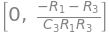

In [37]:
num_root_sym

There are two solutions, $z_1=0$ and another root at: 

In [38]:
Markdown('$z_2={:s}$'.format(latex(num_root_sym[1])))

$z_2=\frac{- R_{1} - R_{3}}{C_{3} R_{1} R_{3}}$

### Denominator Polynominal
The demoninator polynominal of the transfer function is called the characteristic polynominal. The roots of the denominator, also called poles of the system,  determine the system's stability. If any of these roots have a positive real part, the system is unstable, meaning its output will grow unbounded. The roots also influence how the system responds to changes in input (the transient response). They affect things like how quickly the system settles to a new state, whether it oscillates, and the damping of those oscillations. Each root of the characteristic polynominal corresponds to a natural mode of the system.

The denominator polynominal is:

In [39]:
Markdown('$D(s)={:s}$'.format(latex(H_sym_denom)))

$D(s)=C_{2} R_{1} + C_{2} R_{3} + C_{3} R_{1} + s \left(C_{1} C_{3} R_{1} R_{2} + C_{2} C_{3} R_{1} R_{2} + C_{2} C_{3} R_{1} R_{3}\right)$

The coeficients of each Laplace terms can be equated to the variables $a_3$, $a_2$, $a_1$ and $a_0$ in the expression: 

$a_3s^3+a_2s^2+a_1s+a_0$

where $a_3$, $a_2$, $a_1$ and $a_0$ are:

In [40]:
a3 = H_sym_denom.coeff(s**3)
a2 = H_sym_denom.coeff(s**2)
a1 = H_sym_denom.coeff(s**1)
a0 = H_sym_denom - a1*s*1 - a2*s**2 - a3*s**3
Markdown('<p>$a_3={:s}$</p><p>$a_2={:s}$</p><p>$a_1={:s}$</p><p>$a_0={:s}$</p>'.format(latex(a3), latex(a2),latex(a1),latex(a0)))

<p>$a_3=0$</p><p>$a_2=0$</p><p>$a_1=C_{1} C_{3} R_{1} R_{2} + C_{2} C_{3} R_{1} R_{2} + C_{2} C_{3} R_{1} R_{3}$</p><p>$a_0=C_{2} R_{1} + C_{2} R_{3} + C_{3} R_{1}$</p>

The roots of the denominator polynominal can found with SymPy. The filter circuit being analyzed in this report has a denominator polynominal that SymPy can quickly solve. This is not always the case. The expressions are long and do not render well when the JupyterLab notebook is converted to PDF, so the expressions were converted to LaTex strings and then to PNG images with [latex2png](https://latex2png.com/) for this report.

In [41]:
denom_root_sym = solve(H_sym_denom,s)

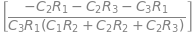

In [42]:
denom_root_sym

In [43]:
C, R = symbols('C R')
Markdown('$N_r(s)={:s}$'.format(latex(H_sym_num.subs({R1:R, R3:R, C1:C, C3:C}).collect(s).factor())))

$N_r(s)=- C C_{2} R R_{2} s \left(C R s + 2\right)$

In a simular fashon, the denominator polynominal is:

In [44]:
Markdown('$D_r(s)={:s}$'.format(latex(H_sym_denom.subs({R1:R, R3:R, C1:C, C3:C}).collect(s).factor())))

$D_r(s)=R \left(C^{2} R_{2} s + C C_{2} R s + C C_{2} R_{2} s + C + 2 C_{2}\right)$

## BR

![](BR-Twin-T-Active-Filter.png)


```
* C:\users\jeff64\My Documents\JupyterLab\Misc ipython notebooks\Buchla 295 10 Channel Comb Filter\LTSpice\BR-Twin-T-Active-Filter.asc
R1 3 1 15k
R2 4 3 186k
R3 2 5 15k
C1 5 1 10n
C2 4 5 910p
C3 2 3 10n
XU1 4 0 2 opamp Aol=100K GBW=10Meg
V1 1 0 1 AC 1
* A Bandpass Twin-T Active Filter Used in the Buchla 200 Electric Music Box Synthesizer
* 1000 Hz band
.lib opamp.sub
.ac dec 1000 100 10k
* R3 for each filter is a 20 kΩ potentiometer wired as a variable resistor.
* R2 for each filter consists of a fixed resistor in series with a 100 kΩ potentiometer wired as a variable resistor.
* The transfer function simplifies conveniently under the special case of R1 = R3 and C1 = C3
* .step param Rtone list 1k 2k 5k 10k
.backanno
.end
```

In [45]:
example_net_list = '''
R1 3 1 1
R2 4 3 1
R3 2 5 1
C1 5 1 1
C2 4 5 1
C3 2 3 1
O1 4 0 2
V1 1 0 1
'''

### Generate Network Equations 

In [46]:
#| echo: true
report, network_df, df2, A, X, Z = SymMNA.smna(example_net_list)

Convert the lists of unknown node voltages and currents as well as the list of independednt voltage and current sources into SymPy matrices. 

In [47]:
X = Matrix(X)
Z = Matrix(Z)

Use the SymPy function ```Eq``` to formulate the network equations.

In [48]:
NE_sym = Eq(A*X,Z)

The equations, ```NE_sym```, define the mathematical relationship between voltages and currents in the filter circuit in terms of node voltages, $v_1$, $v_2$ etc., components $R_1$, $C_1$ etc., the Laplace variable $s$ and the indepenedent voltage source $V_1$. The equations are shown below:

In [49]:
# Put matrices into SymPy 
X = Matrix(X)
Z = Matrix(Z)

NE_sym = Eq(A*X,Z)

# display the equations
temp = ''
for i in range(shape(NE_sym.lhs)[0]):
    temp += '<p>${:s} = {:s}$</p>'.format(latex(NE_sym.lhs[i]),
        latex(NE_sym.rhs[i]))

Markdown(temp)

<p>$- C_{1} s v_{5} + I_{V1} + v_{1} \left(C_{1} s + \frac{1}{R_{1}}\right) - \frac{v_{3}}{R_{1}} = 0$</p><p>$- C_{3} s v_{3} + I_{O1} + v_{2} \left(C_{3} s + \frac{1}{R_{3}}\right) - \frac{v_{5}}{R_{3}} = 0$</p><p>$- C_{3} s v_{2} + v_{3} \left(C_{3} s + \frac{1}{R_{2}} + \frac{1}{R_{1}}\right) - \frac{v_{4}}{R_{2}} - \frac{v_{1}}{R_{1}} = 0$</p><p>$- C_{2} s v_{5} + v_{4} \left(C_{2} s + \frac{1}{R_{2}}\right) - \frac{v_{3}}{R_{2}} = 0$</p><p>$- C_{1} s v_{1} - C_{2} s v_{4} + v_{5} \left(C_{1} s + C_{2} s + \frac{1}{R_{3}}\right) - \frac{v_{2}}{R_{3}} = 0$</p><p>$v_{1} = V_{1}$</p><p>$v_{4} = 0$</p>

The two lines of Python code below turn the free symbols from the ```NE_sym``` equations into SymPy variables and the element values contained in the netlist are put into a Python dictionary data structure to be used in the numerical solutions later in this report.

In [50]:
var(str(NE_sym.free_symbols).replace('{','').replace('}',''))
nominal_component_value = SymMNA.get_part_values(network_df)

### Solve the Network Equations
The SymPy function ```solve``` is used to obtain the node voltages and independent voltage source currents.

In [51]:
U_sym = solve(NE_sym,X)

The solution to the network equations are the node voltages expressed in terms of the Laplace variable $s$ are displayed below.

In [52]:
temp = ''
for i in U_sym.keys():
    if str(i)[0] == 'v': # only display the node voltages
        temp += '<p>${:s} = {:s}$</p>'.format(latex(i),latex(U_sym[i]))

Markdown(temp)

<p>$v_{1} = V_{1}$</p><p>$v_{2} = \frac{- C_{1} C_{2} C_{3} R_{1} R_{2} R_{3} V_{1} s^{3} - C_{1} C_{2} R_{1} R_{3} V_{1} s^{2} - C_{1} C_{2} R_{2} R_{3} V_{1} s^{2} - C_{1} R_{3} V_{1} s - C_{2} R_{3} V_{1} s - V_{1}}{C_{1} C_{3} R_{1} R_{3} s^{2} + C_{2} C_{3} R_{1} R_{2} s^{2} + C_{2} C_{3} R_{1} R_{3} s^{2} + C_{2} R_{1} s + C_{2} R_{2} s + C_{3} R_{1} s}$</p><p>$v_{3} = \frac{- C_{1} C_{2} C_{3} R_{1} R_{2} R_{3} V_{1} s^{2} + C_{2} R_{2} V_{1}}{C_{1} C_{3} R_{1} R_{3} s + C_{2} C_{3} R_{1} R_{2} s + C_{2} C_{3} R_{1} R_{3} s + C_{2} R_{1} + C_{2} R_{2} + C_{3} R_{1}}$</p><p>$v_{4} = 0$</p><p>$v_{5} = \frac{C_{1} C_{3} R_{1} R_{3} V_{1} s^{2} - V_{1}}{C_{1} C_{3} R_{1} R_{3} s^{2} + C_{2} C_{3} R_{1} R_{2} s^{2} + C_{2} C_{3} R_{1} R_{3} s^{2} + C_{2} R_{1} s + C_{2} R_{2} s + C_{3} R_{1} s}$</p>

### Voltage Transfer Function $H(s)=\frac {v_2(s)}{v_1(s)}$
The voltage transfer function, $H(s)$, for the filter  is generated and displayed by the following code:

In [53]:
H_sym = cancel(U_sym[v2]/U_sym[v1],s)
Markdown('$H(s)={:s}$'.format(latex(H_sym)))

$H(s)=\frac{- C_{1} C_{2} C_{3} R_{1} R_{2} R_{3} s^{3} + s^{2} \left(- C_{1} C_{2} R_{1} R_{3} - C_{1} C_{2} R_{2} R_{3}\right) + s \left(- C_{1} R_{3} - C_{2} R_{3}\right) - 1}{s^{2} \left(C_{1} C_{3} R_{1} R_{3} + C_{2} C_{3} R_{1} R_{2} + C_{2} C_{3} R_{1} R_{3}\right) + s \left(C_{2} R_{1} + C_{2} R_{2} + C_{3} R_{1}\right)}$

In [54]:
H_sym_num, H_sym_denom = fraction(H_sym,s) #returns numerator and denominator

### Numerator Polynominal
The numerator polynominal is:

In [55]:
Markdown('$N(s)={:s}$'.format(latex(H_sym_num)))

$N(s)=- C_{1} C_{2} C_{3} R_{1} R_{2} R_{3} s^{3} + s^{2} \left(- C_{1} C_{2} R_{1} R_{3} - C_{1} C_{2} R_{2} R_{3}\right) + s \left(- C_{1} R_{3} - C_{2} R_{3}\right) - 1$

The coeficients of each Laplace terms can be equated to the variables $b_2$, $b_1$ and $b_0$ in the expression: 

$b_2s^{2}+b_1s+b_0$

where $b_2$, $b_1$ and $b_0$ are:

In [56]:
b2 = H_sym_num.coeff(s**2)
b1 = H_sym_num.coeff(s**1)
b0 = H_sym_num - b1*s*1 - b2*s**2

Markdown('<p>$b_2={:s}$</p><p>$b_1={:s}$</p><p>$b_0={:s}$</p>'.format(latex(b2),latex(b1),latex(b0)))

<p>$b_2=- C_{1} C_{2} R_{1} R_{3} - C_{1} C_{2} R_{2} R_{3}$</p><p>$b_1=- C_{1} R_{3} - C_{2} R_{3}$</p><p>$b_0=- C_{1} C_{2} C_{3} R_{1} R_{2} R_{3} s^{3} - 1$</p>

Notice that ther terms $b_2$ and $b_1$ are negative. This follows from the Op Amp being configured as an inverting amplifier. R2 and R3 provide a DC path from the Op Amp's output to the inverting terminal.

The roots of the numerator polynominal can easily be found with SymPy. 

This filter has two transmission zeros

In [57]:
num_root_sym = solve(H_sym_num,s)

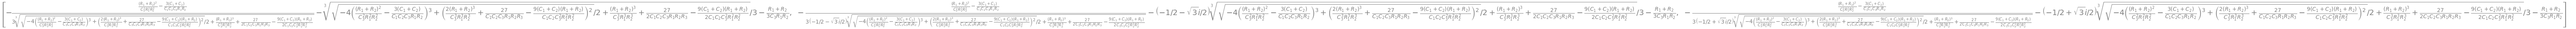

In [58]:
num_root_sym

### Denominator Polynominal
The demoninator polynominal of the transfer function is called the characteristic polynominal. The roots of the denominator, also called poles of the system,  determine the system's stability. If any of these roots have a positive real part, the system is unstable, meaning its output will grow unbounded. The roots also influence how the system responds to changes in input (the transient response). They affect things like how quickly the system settles to a new state, whether it oscillates, and the damping of those oscillations. Each root of the characteristic polynominal corresponds to a natural mode of the system.

The denominator polynominal is:

In [59]:
Markdown('$D(s)={:s}$'.format(latex(H_sym_denom)))

$D(s)=s^{2} \left(C_{1} C_{3} R_{1} R_{3} + C_{2} C_{3} R_{1} R_{2} + C_{2} C_{3} R_{1} R_{3}\right) + s \left(C_{2} R_{1} + C_{2} R_{2} + C_{3} R_{1}\right)$

The coeficients of each Laplace terms can be equated to the variables $a_3$, $a_2$, $a_1$ and $a_0$ in the expression: 

$a_3s^3+a_2s^2+a_1s+a_0$

where $a_3$, $a_2$, $a_1$ and $a_0$ are:

In [60]:
a3 = H_sym_denom.coeff(s**3)
a2 = H_sym_denom.coeff(s**2)
a1 = H_sym_denom.coeff(s**1)
a0 = H_sym_denom - a1*s*1 - a2*s**2 - a3*s**3
Markdown('<p>$a_3={:s}$</p><p>$a_2={:s}$</p><p>$a_1={:s}$</p><p>$a_0={:s}$</p>'.format(latex(a3), latex(a2),latex(a1),latex(a0)))

<p>$a_3=0$</p><p>$a_2=C_{1} C_{3} R_{1} R_{3} + C_{2} C_{3} R_{1} R_{2} + C_{2} C_{3} R_{1} R_{3}$</p><p>$a_1=C_{2} R_{1} + C_{2} R_{2} + C_{3} R_{1}$</p><p>$a_0=0$</p>

The roots of the denominator polynominal can found with SymPy. The filter circuit being analyzed in this report has a denominator polynominal that SymPy can quickly solve. This is not always the case. The expressions are long and do not render well when the JupyterLab notebook is converted to PDF, so the expressions were converted to LaTex strings and then to PNG images with [latex2png](https://latex2png.com/) for this report.

In [61]:
denom_root_sym = solve(H_sym_denom,s)

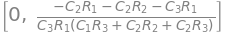

In [62]:
denom_root_sym

In [63]:
C, R = symbols('C R')
Markdown('$N_r(s)={:s}$'.format(latex(H_sym_num.subs({R1:R, R3:R, C1:C, C3:C}).collect(s).factor())))

$N_r(s)=- \left(C R s + 1\right) \left(C C_{2} R R_{2} s^{2} + C_{2} R s + 1\right)$

In a simular fashon, the denominator polynominal is:

In [64]:
Markdown('$D_r(s)={:s}$'.format(latex(H_sym_denom.subs({R1:R, R3:R, C1:C, C3:C}).collect(s).factor())))

$D_r(s)=s \left(C R s + 1\right) \left(C R + C_{2} R + C_{2} R_{2}\right)$

# All Pass

![](Twin-T-variation4.png)



### Example 4, $R_1=2R$, $R_2=R_3=R$, $C_1=C/2$ and $C_2=C_3=C$

Move this example to variations notebook.

A special case of this passive filter, with 2R1 = R2 = R3 and C1/2 = C2 = C3 , appears as Figure 8.34(a) on p. 467 of [8], with pin 3 of that figure acting as the input and pin 2 acting as the output, where it is named “Bandpass Twin-T.” 

Terry Watson stumbled across the same special case in his master’s thesis work when he accidentally swapped connections to a standard Twin-T network (Figure 16 on p. 35 of [9], with Ē2 of that figure acting as the input and Ē1 acting as the output). He suggests it “might be used as a lead-lag compensating network,” but does not explore it futher.

[8] A. Sedra and P. Brackett, Filter Theory and Design: Active and Passive. Matrix Publications, 1978.
[9] T. Watson, “Active band-pass filters using twin-tee networks,” Master’s thesis, University of Missouri at Rolla,, Rolla, MO, 1965.

A lead-lag compensating network is a crucial component in control systems engineering, designed to enhance the performance and stability of a system. Here's a breakdown of what it is:

**Core Concept:**

* A lead-lag compensator combines the characteristics of both lead and lag compensators. This allows it to address both transient and steady-state response issues within a control system.
* Essentially, it's an electrical network that introduces both phase lead and phase lag at different frequency ranges.

**Purpose:**

* **Improving Stability:**
    * It helps increase stability margins, making the system more robust against disturbances.
* **Enhancing Transient Response:**
    * The phase lead component contributes to a faster response, reducing settling times and overshoot.
* **Improving Steady-State Accuracy:**
    * The phase lag component enhances low-frequency gain, minimizing steady-state errors.

**Key Components and Functionality:**

* **Lead Compensator:**
    * Provides phase lead at higher frequencies, improving transient response and stability.
* **Lag Compensator:**
    * Introduces phase lag at lower frequencies, enhancing steady-state accuracy.
* **Combined Effect:**
    * By combining these, a lead-lag compensator offers a balanced approach to optimizing system performance.

**In essence:**

Lead-lag compensators are versatile tools in control systems, allowing engineers to fine-tune system behavior for optimal performance across a wide range of operating conditions.


In [65]:
example_net_list = '''
* Twin-T-variation4.asc
R1 3 1 1
R2 4 5 1
R3 6 5 1
C1 5 1 1
C2 4 3 1
C3 6 3 1
V1 1 0 1
O1 4 0 6
O2 7 0 2
R4 7 6 1
R5 7 1 1
R6 2 7 1
'''

In [66]:
#| echo: true
report, network_df, df2, A, X, Z = SymMNA.smna(example_net_list)

X = Matrix(X)
Z = Matrix(Z)

NE_sym = Eq(A*X,Z)

var(str(NE_sym.free_symbols).replace('{','').replace('}',''))
nominal_component_value = SymMNA.get_part_values(network_df)

U_sym_ex4 = solve(NE_sym,X)
H_sym_ex4 = cancel(U_sym_ex4[v2]/U_sym_ex4[v1],s)

In [67]:
#| echo: false
Markdown('$H(s)={:s}$'.format(latex(H_sym_ex4)))

$H(s)=\frac{- C_{1} C_{2} C_{3} R_{1} R_{2} R_{3} R_{4} R_{6} s^{3} - R_{4} R_{6} + s^{2} \left(C_{1} C_{2} R_{1} R_{3} R_{5} R_{6} + C_{1} C_{2} R_{2} R_{3} R_{5} R_{6} + C_{1} C_{3} R_{1} R_{3} R_{5} R_{6} - C_{2} C_{3} R_{1} R_{2} R_{4} R_{6} - C_{2} C_{3} R_{1} R_{3} R_{4} R_{6}\right) + s \left(C_{1} R_{3} R_{5} R_{6} - C_{2} R_{1} R_{4} R_{6} + C_{2} R_{2} R_{5} R_{6} + C_{2} R_{3} R_{5} R_{6} - C_{3} R_{1} R_{4} R_{6}\right)}{C_{1} C_{2} C_{3} R_{1} R_{2} R_{3} R_{4} R_{5} s^{3} + R_{4} R_{5} + s^{2} \left(C_{2} C_{3} R_{1} R_{2} R_{4} R_{5} + C_{2} C_{3} R_{1} R_{3} R_{4} R_{5}\right) + s \left(C_{2} R_{1} R_{4} R_{5} + C_{3} R_{1} R_{4} R_{5}\right)}$

Making the substitutions: $R_1=R_3=R$, $R_2=2R$, $R_4=5$, $R_5=R_6=2$, $C_1=C_3=C$ and $C_2=C/2$, we get:

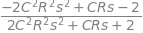

In [68]:
H_sym_ex4.subs({R1:R, R2:R*2, R3:R, R4:5, R5:2, R6:2, C1:C, C2:C/2, C3:C}).simplify()

In [69]:
#| echo: false
H_sym_ex4 = H_sym_ex4.subs({R1:R, R2:R*2, R3:R, R4:5, R5:2, R6:2, C1:C, C2:C/2, C3:C}).simplify()
Markdown('$H(s)={:s}$'.format(latex(H_sym_ex4)))

$H(s)=\frac{- 2 C^{2} R^{2} s^{2} + C R s - 2}{2 C^{2} R^{2} s^{2} + C R s + 2}$

In [70]:
#| echo: false
H_sym_num, H_sym_denom = fraction(H_sym_ex4,s) #returns numerator and denominator

In [71]:
H_sym_num = H_sym_num.expand().collect(s)

In [72]:
H_sym_num

In [73]:
H_sym_denom = H_sym_denom.expand().collect(s)

The numerator polynominal is:

In [74]:
#| echo: false
Markdown('$N(s)={:s}$'.format(latex(H_sym_num)))

$N(s)=- 2 C^{2} R^{2} s^{2} + C R s - 2$

In [75]:
#| echo: false
num_root_sym = solve(H_sym_num,s)
Markdown('${:s}$'.format(latex(num_root_sym)))

$\left[ \frac{1 - \sqrt{15} i}{4 C R}, \  \frac{1 + \sqrt{15} i}{4 C R}\right]$

The denominator polynominal is:

In [76]:
#| echo: false
Markdown('$D(s)={:s}$'.format(latex(H_sym_denom)))

$D(s)=2 C^{2} R^{2} s^{2} + C R s + 2$

The roots of the denominator polynominal can found with SymPy.

In [77]:
#| echo: false
denom_root_sym = solve(H_sym_denom,s)
Markdown('${:s}$'.format(latex(denom_root_sym)))

$\left[ \frac{-1 - \sqrt{15} i}{4 C R}, \  \frac{-1 + \sqrt{15} i}{4 C R}\right]$

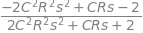

In [78]:
H_sym_ex4

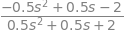

In [79]:
H_sym_ex4.subs({R:1,C:1/2})

In [80]:
#| echo: false
H_num, H_denom = fraction(H_sym_ex4.subs({R:1,C:1/8})) #returns numerator and denominator

# convert symbolic to numpy polynomial
a = np.array(Poly(H_num, s).all_coeffs(), dtype=float)
b = np.array(Poly(H_denom, s).all_coeffs(), dtype=float)
sys_tf_ex4 = signal.TransferFunction(a,b)

The poles and zeros of the transfer function are plotted below:

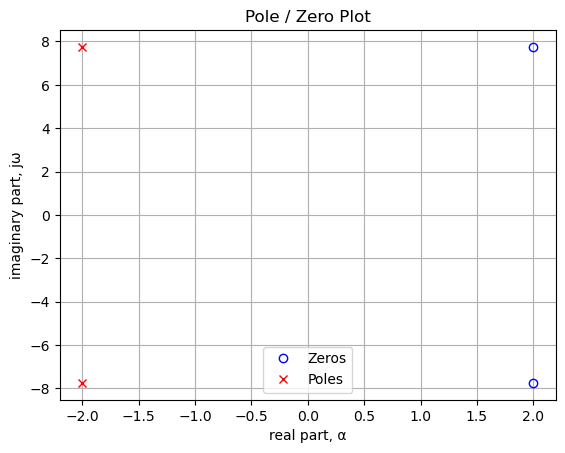

In [81]:
#| echo: false
#| fig-cap: fig cap
sys_zeros_ex4 = np.roots(sys_tf_ex4.num)
sys_poles_ex4 = np.roots(sys_tf_ex4.den)

plt.plot(np.real(sys_zeros_ex4), np.imag(sys_zeros_ex4), 'ob', markerfacecolor='none')
plt.plot(np.real(sys_poles_ex4), np.imag(sys_poles_ex4), 'xr')
plt.legend(['Zeros', 'Poles'], loc=0)
plt.title('Pole / Zero Plot')
plt.xlabel('real part, \u03B1')
plt.ylabel('imaginary part, j\u03C9')
plt.grid()
plt.show()

The units of the poles and zeros are in radian frequency and are tabulated below.

In [82]:
#| echo: false
#| tbl-cap: table of poles and zeros

table_header = ['Zeros, rad/s', 'Poles, rad/s']
num_table_rows = max(len(sys_zeros_ex4),len(sys_poles_ex4))
table_row = []

for i in range(num_table_rows):
    if i < len(sys_zeros_ex4):
        z = '{:.2f}'.format(sys_zeros_ex4[i])
    else:
        z = ''
    if i < len(sys_poles_ex4):
        p = '{:.2f}'.format(sys_poles_ex4[i])
    else:
        p = ''
    table_row.append([z,p])

Markdown(tabulate(table_row, headers=table_header,colalign = ('left','left'),tablefmt="simple"))

Zeros, rad/s    Poles, rad/s
--------------  --------------
2.00+7.75j      -2.00+7.75j
2.00-7.75j      -2.00-7.75j

In [83]:
# printing the table only for Jupyter Lab 
print(tabulate(table_row, headers=table_header,colalign = ('left','left'),tablefmt="simple"))

Zeros, rad/s    Poles, rad/s
--------------  --------------
2.00+7.75j      -2.00+7.75j
2.00-7.75j      -2.00-7.75j


The values of the poles network are the same a chosen above, thus validating the solution.

The magnitude and phase of the filter's transfer function is plotted below.

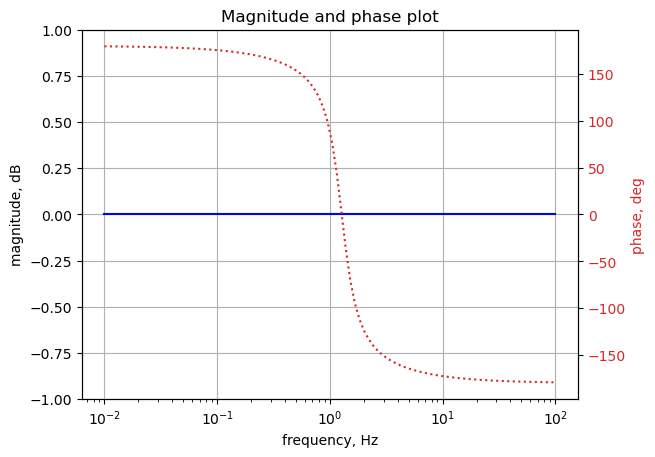

In [84]:
#| echo: false
#| fig-cap: fig cap

x = np.logspace(-2, 2, 100, endpoint=True)*2*np.pi
w, mag, phase = signal.bode(sys_tf_ex4, w=x) # returns: rad/s, mag in dB, phase in deg

fig, ax1 = plt.subplots()
ax1.set_ylabel('magnitude, dB')
ax1.set_xlabel('frequency, Hz')

plt.semilogx(w/(2*np.pi), mag,'-b')    # magnitude plot
ax1.set_ylim(-1,1)
ax1.tick_params(axis='y')
plt.grid()

# instantiate a second y-axes that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:red'

plt.semilogx(w/(2*np.pi), phase,':',color='tab:red')  # phase plot

ax2.set_ylabel('phase, deg',color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Magnitude and phase plot')
plt.show()

The step response is plotted below.

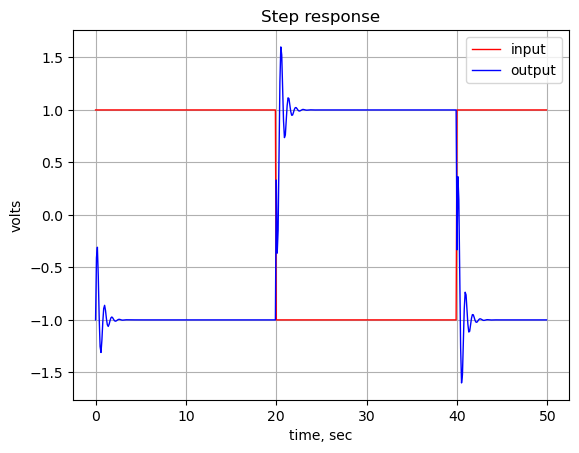

In [85]:
#| echo: false
#| fig-cap: fig cap

# define the time interval and create a square wave step waveform.
t = np.linspace(0, 50, 500, endpoint=False)
sqr_signal = signal.square(2*np.pi*0.025*t, duty=0.5)

# call lsim to generate the response signal
t_step, y_step, x_step = signal.lsim(sys_tf_ex4, U=sqr_signal, T=t)

plt.plot(t_step, sqr_signal, 'r', alpha = 1.0, linewidth=1, label='input')
plt.plot(t_step, y_step,'b', linewidth = 1.0, label='output')
plt.title('Step response')
plt.ylabel('volts')
plt.xlabel('time, sec')
plt.grid()
plt.legend(loc='best')
# show plot
plt.show()

# variation 2 = ?
There is no DC feedback, I don't think this circuit can be analized with SMNA., take a look at the LTSpice analysis to see if this circuit works.

Kind of acts like a integrator.

![](Twin-T-variation2.png)

Use this block of code as a template

In [86]:
example_net_list = '''
* Twin-T-variation2.asc
R1 3 1 1
R2 4 5 1
R3 5 1 1
C1 2 5 1
C2 4 3 1
C3 2 3 1
V1 1 0 1
O1 4 0 2
'''

In [87]:
#| echo: true
report, network_df, df2, A, X, Z = SymMNA.smna(example_net_list)

X = Matrix(X)
Z = Matrix(Z)

NE_sym = Eq(A*X,Z)

var(str(NE_sym.free_symbols).replace('{','').replace('}',''))
nominal_component_value = SymMNA.get_part_values(network_df)

# N is the variation number
U_sym = solve(NE_sym,X)
H_sym = cancel(U_sym[v2]/U_sym[v1],s)

In [88]:
#| echo: false
Markdown('$H(s)={:s}$'.format(latex(H_sym)))

$H(s)=\frac{- C_{1} C_{2} R_{2} R_{3} s^{2} + s \left(- C_{2} R_{1} - C_{2} R_{2} - C_{2} R_{3} - C_{3} R_{1}\right) - 1}{C_{1} C_{2} C_{3} R_{1} R_{2} R_{3} s^{3} + C_{1} R_{3} s + s^{2} \left(C_{1} C_{2} R_{1} R_{3} + C_{1} C_{3} R_{1} R_{3} + C_{2} C_{3} R_{1} R_{2} + C_{2} C_{3} R_{1} R_{3}\right)}$

Making the substitutions: $R_1=R_3=R$, $R_2=2R$, $R_4=5$, $R_5=R_6=2$, $C_1=C_3=C$ and $C_2=C/2$, we get:

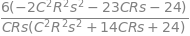

In [89]:
sub_values = {R1:R/4, R2:R, R3:R/2, C1:C/3, C2:C/2, C3:C/3}
H_sym.subs(sub_values).simplify()

In [90]:
#| echo: false
H_sym = H_sym.subs(sub_values).simplify()
Markdown('$H(s)={:s}$'.format(latex(H_sym)))

$H(s)=\frac{6 \left(- 2 C^{2} R^{2} s^{2} - 23 C R s - 24\right)}{C R s \left(C^{2} R^{2} s^{2} + 14 C R s + 24\right)}$

In [91]:
#| echo: false
H_sym_num, H_sym_denom = fraction(H_sym,s) #returns numerator and denominator

In [92]:
H_sym_num = H_sym_num.expand().collect(s)

In [93]:
H_sym_num

In [94]:
H_sym_denom = H_sym_denom.expand().collect(s)

The numerator polynominal is:

In [95]:
#| echo: false
Markdown('$N(s)={:s}$'.format(latex(H_sym_num)))

$N(s)=- 12 C^{2} R^{2} s^{2} - 138 C R s - 144$

In [96]:
#| echo: false
num_root_sym = solve(H_sym_num,s)
Markdown('${:s}$'.format(latex(num_root_sym)))

$\left[ \frac{-23 - \sqrt{337}}{4 C R}, \  \frac{-23 + \sqrt{337}}{4 C R}\right]$

The denominator polynominal is:

In [97]:
#| echo: false
Markdown('$D(s)={:s}$'.format(latex(H_sym_denom)))

$D(s)=C^{3} R^{3} s^{3} + 14 C^{2} R^{2} s^{2} + 24 C R s$

The roots of the denominator polynominal can found with SymPy.

In [98]:
#| echo: false
denom_root_sym = solve(H_sym_denom,s)
Markdown('${:s}$'.format(latex(denom_root_sym)))

$\left[ 0, \  - \frac{12}{C R}, \  - \frac{2}{C R}\right]$

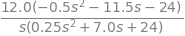

In [99]:
sub_values = {R:1,C:1/2}
H_sym.subs(sub_values)

In [100]:
#| echo: false
H_num, H_denom = fraction(H_sym.subs(sub_values)) #returns numerator and denominator

# convert symbolic to numpy polynomial
a = np.array(Poly(H_num, s).all_coeffs(), dtype=float)
b = np.array(Poly(H_denom, s).all_coeffs(), dtype=float)
sys_tf = signal.TransferFunction(a,b)

The poles and zeros of the transfer function are plotted below:

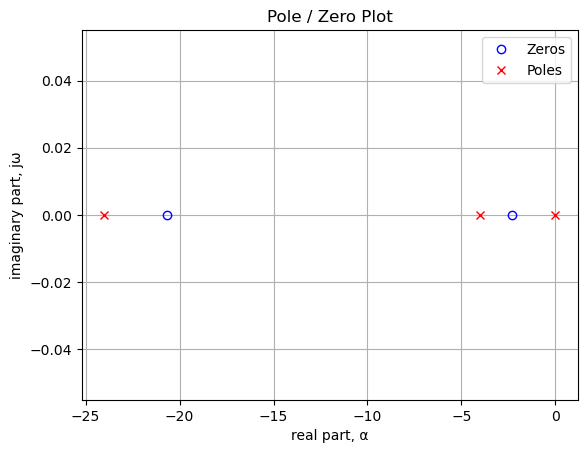

In [101]:
#| echo: false
#| fig-cap: fig cap
sys_zeros = np.roots(sys_tf.num)
sys_poles = np.roots(sys_tf.den)

plt.plot(np.real(sys_zeros), np.imag(sys_zeros), 'ob', markerfacecolor='none')
plt.plot(np.real(sys_poles), np.imag(sys_poles), 'xr')
plt.legend(['Zeros', 'Poles'], loc=0)
plt.title('Pole / Zero Plot')
plt.xlabel('real part, \u03B1')
plt.ylabel('imaginary part, j\u03C9')
plt.grid()
plt.show()

The units of the poles and zeros are in radian frequency and are tabulated below.

In [102]:
#| echo: false
#| tbl-cap: table of poles and zeros

table_header = ['Zeros, rad/s', 'Poles, rad/s']
num_table_rows = max(len(sys_zeros),len(sys_poles))
table_row = []

for i in range(num_table_rows):
    if i < len(sys_zeros):
        z = '{:.2f}'.format(sys_zeros[i])
    else:
        z = ''
    if i < len(sys_poles):
        p = '{:.2f}'.format(sys_poles[i])
    else:
        p = ''
    table_row.append([z,p])

print(tabulate(table_row, headers=table_header,colalign = ('left','left'),tablefmt="simple"))

Zeros, rad/s    Poles, rad/s
--------------  --------------
-20.68          -24
-2.32           -4
                0


The values of the poles network are the same a chosen above, thus validating the solution.

The magnitude and phase of the filter's transfer function is plotted below.

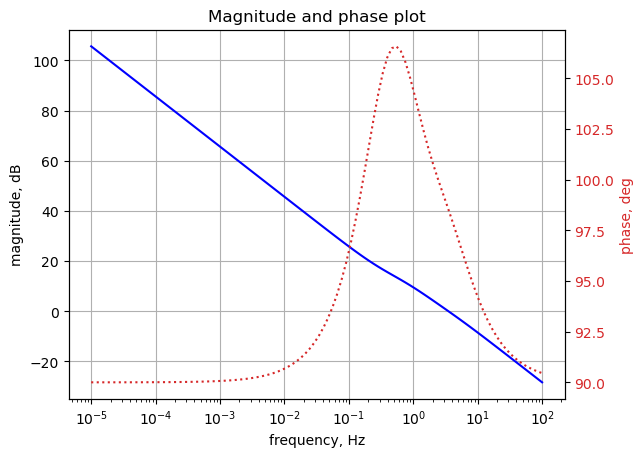

In [103]:
#| echo: false
#| fig-cap: fig cap

x = np.logspace(-5, 2, 100, endpoint=True)*2*np.pi
w, mag, phase = signal.bode(sys_tf, w=x) # returns: rad/s, mag in dB, phase in deg

fig, ax1 = plt.subplots()
ax1.set_ylabel('magnitude, dB')
ax1.set_xlabel('frequency, Hz')

plt.semilogx(w/(2*np.pi), mag,'-b')    # magnitude plot
#ax1.set_ylim(-1,1)
ax1.tick_params(axis='y')
plt.grid()

# instantiate a second y-axes that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:red'

plt.semilogx(w/(2*np.pi), phase,':',color='tab:red')  # phase plot

ax2.set_ylabel('phase, deg',color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Magnitude and phase plot')
plt.show()

The step response is plotted below.

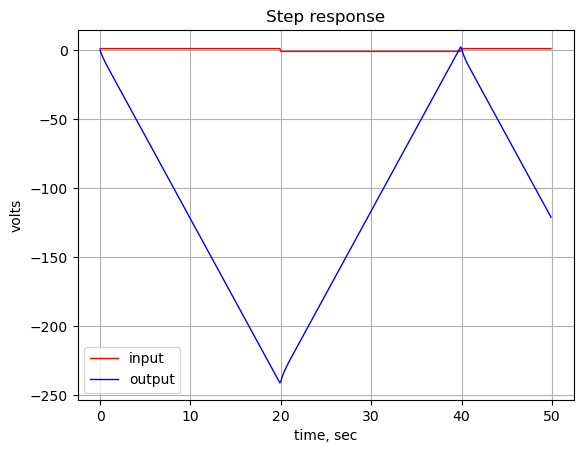

In [104]:
#| echo: false
#| fig-cap: fig cap

# define the time interval and create a square wave step waveform.
t = np.linspace(0, 50, 500, endpoint=False)
sqr_signal = signal.square(2*np.pi*0.025*t, duty=0.5)

# call lsim to generate the response signal
t_step, y_step, x_step = signal.lsim(sys_tf, U=sqr_signal, T=t)

plt.plot(t_step, sqr_signal, 'r', alpha = 1.0, linewidth=1, label='input')
plt.plot(t_step, y_step,'b', linewidth = 1.0, label='output')
plt.title('Step response')
plt.ylabel('volts')
plt.xlabel('time, sec')
plt.grid()
plt.legend(loc='best')
# show plot
plt.show()

# variation 3 = ?
what if yo made R1, R2 and R3 a pot, would this be a tone control circuit?

![](Twin-T-variation3.png)

In [105]:
example_net_list = '''
* Twin-T-variation3.asc
R1 5 1 1
R2 4 5 1
R3 2 5 1
C1 3 1 1
C2 4 3 1
C3 2 3 1
V1 1 0 1
O1 4 0 2
'''

In [106]:
#| echo: true
report, network_df, df2, A, X, Z = SymMNA.smna(example_net_list)

X = Matrix(X)
Z = Matrix(Z)

NE_sym = Eq(A*X,Z)

var(str(NE_sym.free_symbols).replace('{','').replace('}',''))
nominal_component_value = SymMNA.get_part_values(network_df)

# N is the variation number
U_sym = solve(NE_sym,X)
H_sym = cancel(U_sym[v2]/U_sym[v1],s)

In [107]:
#| echo: false
Markdown('$H(s)={:s}$'.format(latex(H_sym)))

$H(s)=\frac{- C_{1} R_{3} - C_{2} R_{3} - C_{3} R_{3} + s \left(- C_{1} C_{2} R_{1} R_{2} - C_{1} C_{2} R_{1} R_{3} - C_{1} C_{2} R_{2} R_{3}\right)}{C_{1} R_{1} + C_{2} R_{1} + C_{3} R_{1} + s \left(C_{2} C_{3} R_{1} R_{2} + C_{2} C_{3} R_{1} R_{3} + C_{2} C_{3} R_{2} R_{3}\right)}$

Making the substitutions: $R_1=R_3=R$, $R_2=2R$, $R_4=5$, $R_5=R_6=2$, $C_1=C_3=C$ and $C_2=C/2$, we get:

In [108]:
sub_values = {R1:R/4, R2:R, R3:R/2, C1:C/5, C2:C/2, C3:C/3}
H_sym.subs(sub_values).simplify()

In [109]:
#| echo: false
H_sym = H_sym.subs(sub_values).simplify()
Markdown('$H(s)={:s}$'.format(latex(H_sym)))

$H(s)=\frac{- 21 C R s - 124}{35 C R s + 62}$

In [110]:
#| echo: false
H_sym_num, H_sym_denom = fraction(H_sym,s) #returns numerator and denominator

In [111]:
H_sym_num = H_sym_num.expand().collect(s)

In [112]:
H_sym_num

In [113]:
H_sym_denom = H_sym_denom.expand().collect(s)

The numerator polynominal is:

In [114]:
#| echo: false
Markdown('$N(s)={:s}$'.format(latex(H_sym_num)))

$N(s)=- 21 C R s - 124$

In [115]:
#| echo: false
num_root_sym = solve(H_sym_num,s)
Markdown('${:s}$'.format(latex(num_root_sym)))

$\left[ - \frac{124}{21 C R}\right]$

The denominator polynominal is:

In [116]:
#| echo: false
Markdown('$D(s)={:s}$'.format(latex(H_sym_denom)))

$D(s)=35 C R s + 62$

The roots of the denominator polynominal can found with SymPy.

In [117]:
#| echo: false
denom_root_sym = solve(H_sym_denom,s)
Markdown('${:s}$'.format(latex(denom_root_sym)))

$\left[ - \frac{62}{35 C R}\right]$

In [118]:
sub_values = {R:1,C:1/2}
H_sym.subs(sub_values)

In [119]:
#| echo: false
H_num, H_denom = fraction(H_sym.subs(sub_values)) #returns numerator and denominator

# convert symbolic to numpy polynomial
a = np.array(Poly(H_num, s).all_coeffs(), dtype=float)
b = np.array(Poly(H_denom, s).all_coeffs(), dtype=float)
sys_tf = signal.TransferFunction(a,b)

The poles and zeros of the transfer function are plotted below:

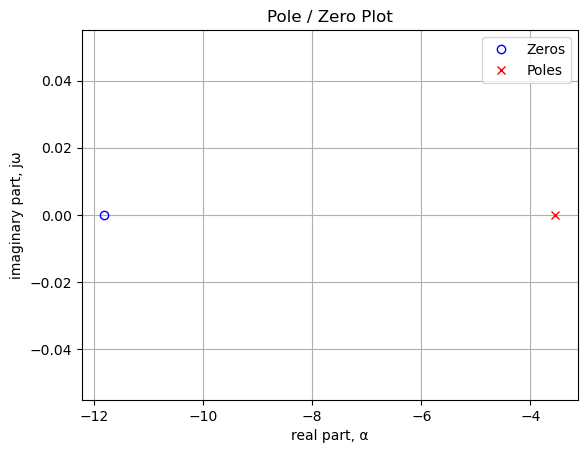

In [120]:
#| echo: false
#| fig-cap: fig cap
sys_zeros = np.roots(sys_tf.num)
sys_poles = np.roots(sys_tf.den)

plt.plot(np.real(sys_zeros), np.imag(sys_zeros), 'ob', markerfacecolor='none')
plt.plot(np.real(sys_poles), np.imag(sys_poles), 'xr')
plt.legend(['Zeros', 'Poles'], loc=0)
plt.title('Pole / Zero Plot')
plt.xlabel('real part, \u03B1')
plt.ylabel('imaginary part, j\u03C9')
plt.grid()
plt.show()

The units of the poles and zeros are in radian frequency and are tabulated below.

In [121]:
#| echo: false
#| tbl-cap: table of poles and zeros

table_header = ['Zeros, rad/s', 'Poles, rad/s']
num_table_rows = max(len(sys_zeros),len(sys_poles))
table_row = []

for i in range(num_table_rows):
    if i < len(sys_zeros):
        z = '{:.2f}'.format(sys_zeros[i])
    else:
        z = ''
    if i < len(sys_poles):
        p = '{:.2f}'.format(sys_poles[i])
    else:
        p = ''
    table_row.append([z,p])

print(tabulate(table_row, headers=table_header,colalign = ('left','left'),tablefmt="simple"))

Zeros, rad/s    Poles, rad/s
--------------  --------------
-11.81          -3.54


The values of the poles network are the same a chosen above, thus validating the solution.

The magnitude and phase of the filter's transfer function is plotted below.

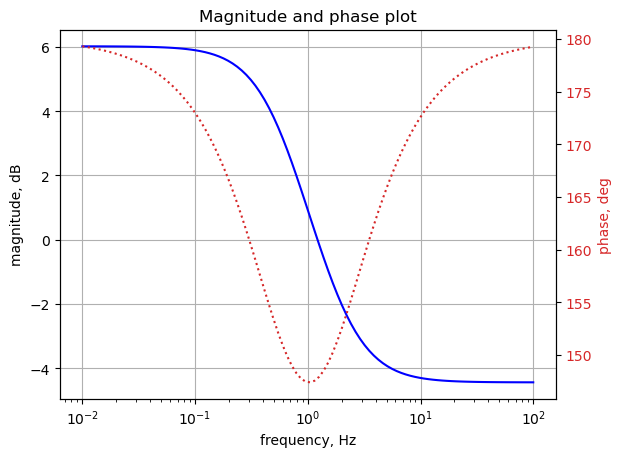

In [122]:
#| echo: false
#| fig-cap: fig cap

x = np.logspace(-2, 2, 100, endpoint=True)*2*np.pi
w, mag, phase = signal.bode(sys_tf, w=x) # returns: rad/s, mag in dB, phase in deg

fig, ax1 = plt.subplots()
ax1.set_ylabel('magnitude, dB')
ax1.set_xlabel('frequency, Hz')

plt.semilogx(w/(2*np.pi), mag,'-b')    # magnitude plot
#ax1.set_ylim(-1,1)
ax1.tick_params(axis='y')
plt.grid()

# instantiate a second y-axes that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:red'

plt.semilogx(w/(2*np.pi), phase,':',color='tab:red')  # phase plot

ax2.set_ylabel('phase, deg',color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Magnitude and phase plot')
plt.show()

The step response is plotted below.

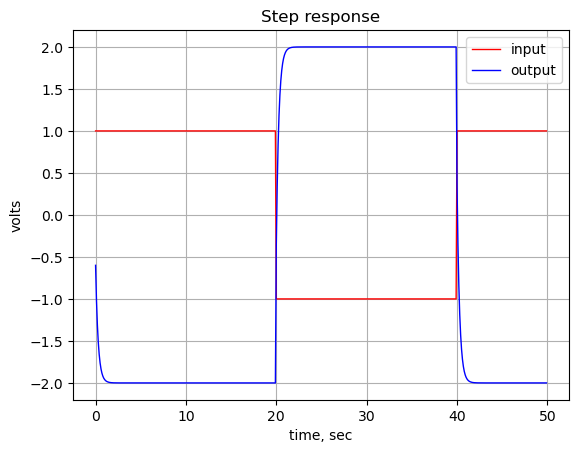

In [123]:
#| echo: false
#| fig-cap: fig cap

# define the time interval and create a square wave step waveform.
t = np.linspace(0, 50, 500, endpoint=False)
sqr_signal = signal.square(2*np.pi*0.025*t, duty=0.5)

# call lsim to generate the response signal
t_step, y_step, x_step = signal.lsim(sys_tf, U=sqr_signal, T=t)

plt.plot(t_step, sqr_signal, 'r', alpha = 1.0, linewidth=1, label='input')
plt.plot(t_step, y_step,'b', linewidth = 1.0, label='output')
plt.title('Step response')
plt.ylabel('volts')
plt.xlabel('time, sec')
plt.grid()
plt.legend(loc='best')
# show plot
plt.show()

# BPF
This also variation 1 schematic


![](Twin-T-variation1.png)


```
* C:\users\jeff64\My Documents\JupyterLab\Misc ipython notebooks\Buchla 295 10 Channel Comb Filter\LTSpice\Twin-T-variation1.asc
R1 3 1 1
R2 4 5 1
R3 2 5 1
C1 5 1 1
C2 4 3 1
C3 2 3 1
V1 1 0 1
XU1 4 0 2 opamp Aol=100K GBW=10Meg
.backanno
.end
```

In [124]:
example_net_list = '''
* Twin-T-variation1.asc
R1 3 1 1
R2 4 5 1
R3 2 5 1
C1 5 1 1
C2 4 3 1
C3 2 3 1
V1 1 0 1
O1 4 0 2
'''

In [125]:
#| echo: true
report, network_df, df2, A, X, Z = SymMNA.smna(example_net_list)

X = Matrix(X)
Z = Matrix(Z)

NE_sym = Eq(A*X,Z)

var(str(NE_sym.free_symbols).replace('{','').replace('}',''))
nominal_component_value = SymMNA.get_part_values(network_df)

# N is the variation number
U_sym = solve(NE_sym,X)
H_sym = cancel(U_sym[v2]/U_sym[v1],s)

In [126]:
#| echo: false
Markdown('$H(s)={:s}$'.format(latex(H_sym)))

$H(s)=\frac{s^{2} \left(- C_{1} C_{2} R_{1} R_{3} - C_{1} C_{2} R_{2} R_{3} - C_{1} C_{3} R_{1} R_{3}\right) + s \left(- C_{1} R_{3} - C_{2} R_{2} - C_{2} R_{3}\right)}{C_{1} C_{2} C_{3} R_{1} R_{2} R_{3} s^{3} + s^{2} \left(C_{2} C_{3} R_{1} R_{2} + C_{2} C_{3} R_{1} R_{3}\right) + s \left(C_{2} R_{1} + C_{3} R_{1}\right) + 1}$

Making the substitutions: $R_1=R_3=R$, $R_2=2R$, $R_4=5$, $R_5=R_6=2$, $C_1=C_3=C$ and $C_2=C/2$, we get:

In [127]:
sub_values = {R1:R, R2:R/2, R3:R, C1:C, C2:C/2, C3:C}
H_sym.subs(sub_values).simplify()

In [128]:
#| echo: false
H_sym = H_sym.subs(sub_values).simplify()
Markdown('$H(s)={:s}$'.format(latex(H_sym)))

$H(s)=- \frac{7 C R s}{C^{2} R^{2} s^{2} + 2 C R s + 4}$

In [129]:
#| echo: false
H_sym_num, H_sym_denom = fraction(H_sym,s) #returns numerator and denominator

In [130]:
H_sym_num = H_sym_num.expand().collect(s)

In [131]:
H_sym_num

In [132]:
H_sym_denom = H_sym_denom.expand().collect(s)

The numerator polynominal is:

In [133]:
#| echo: false
Markdown('$N(s)={:s}$'.format(latex(H_sym_num)))

$N(s)=- 7 C R s$

In [134]:
#| echo: false
num_root_sym = solve(H_sym_num,s)
Markdown('${:s}$'.format(latex(num_root_sym)))

$\left[ 0\right]$

The denominator polynominal is:

In [135]:
#| echo: false
Markdown('$D(s)={:s}$'.format(latex(H_sym_denom)))

$D(s)=C^{2} R^{2} s^{2} + 2 C R s + 4$

The roots of the denominator polynominal can found with SymPy.

In [136]:
#| echo: false
denom_root_sym = solve(H_sym_denom,s)
Markdown('${:s}$'.format(latex(denom_root_sym)))

$\left[ \frac{-1 - \sqrt{3} i}{C R}, \  \frac{-1 + \sqrt{3} i}{C R}\right]$

In [137]:
sub_values = {R:1,C:1/2}
H_sym.subs(sub_values)

In [138]:
#| echo: false
H_num, H_denom = fraction(H_sym.subs(sub_values)) #returns numerator and denominator

# convert symbolic to numpy polynomial
a = np.array(Poly(H_num, s).all_coeffs(), dtype=float)
b = np.array(Poly(H_denom, s).all_coeffs(), dtype=float)
sys_tf = signal.TransferFunction(a,b)

The poles and zeros of the transfer function are plotted below:

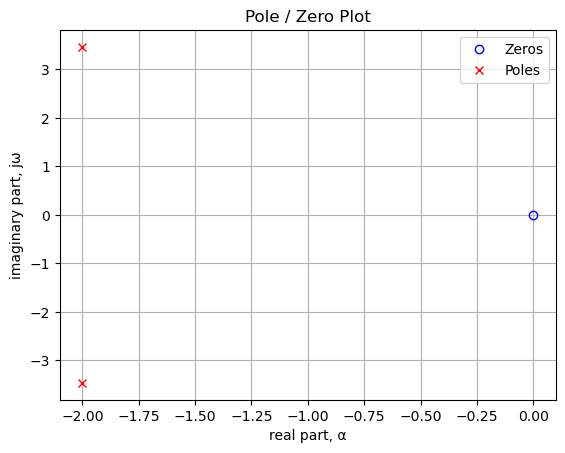

In [139]:
#| echo: false
#| fig-cap: fig cap
sys_zeros = np.roots(sys_tf.num)
sys_poles = np.roots(sys_tf.den)

plt.plot(np.real(sys_zeros), np.imag(sys_zeros), 'ob', markerfacecolor='none')
plt.plot(np.real(sys_poles), np.imag(sys_poles), 'xr')
plt.legend(['Zeros', 'Poles'], loc=0)
plt.title('Pole / Zero Plot')
plt.xlabel('real part, \u03B1')
plt.ylabel('imaginary part, j\u03C9')
plt.grid()
plt.show()

The units of the poles and zeros are in radian frequency and are tabulated below.

In [140]:
#| echo: false
#| tbl-cap: table of poles and zeros

table_header = ['Zeros, rad/s', 'Poles, rad/s']
num_table_rows = max(len(sys_zeros),len(sys_poles))
table_row = []

for i in range(num_table_rows):
    if i < len(sys_zeros):
        z = '{:.2f}'.format(sys_zeros[i])
    else:
        z = ''
    if i < len(sys_poles):
        p = '{:.2f}'.format(sys_poles[i])
    else:
        p = ''
    table_row.append([z,p])

print(tabulate(table_row, headers=table_header,colalign = ('left','left'),tablefmt="simple"))

Zeros, rad/s    Poles, rad/s
--------------  --------------
0.00            -2.00+3.46j
                -2.00-3.46j


The values of the poles network are the same a chosen above, thus validating the solution.

The magnitude and phase of the filter's transfer function is plotted below.

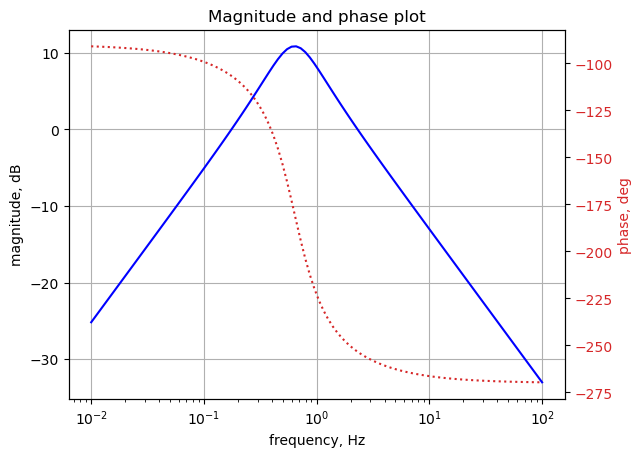

In [141]:
#| echo: false
#| fig-cap: fig cap

x = np.logspace(-2, 2, 100, endpoint=True)*2*np.pi
w, mag, phase = signal.bode(sys_tf, w=x) # returns: rad/s, mag in dB, phase in deg

fig, ax1 = plt.subplots()
ax1.set_ylabel('magnitude, dB')
ax1.set_xlabel('frequency, Hz')

plt.semilogx(w/(2*np.pi), mag,'-b')    # magnitude plot
#ax1.set_ylim(-1,1)
ax1.tick_params(axis='y')
plt.grid()

# instantiate a second y-axes that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:red'

plt.semilogx(w/(2*np.pi), phase,':',color='tab:red')  # phase plot

ax2.set_ylabel('phase, deg',color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Magnitude and phase plot')
plt.show()

The step response is plotted below.

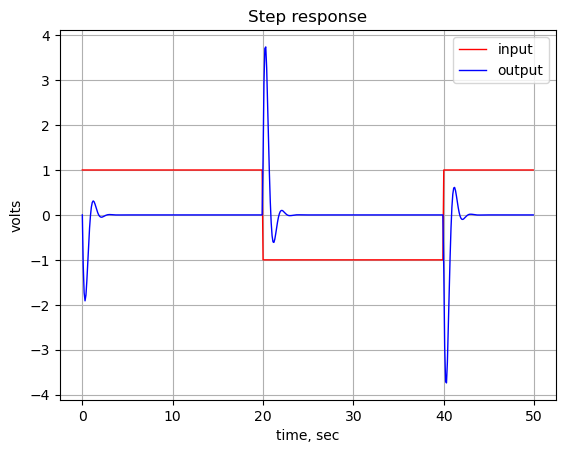

In [142]:
#| echo: false
#| fig-cap: fig cap

# define the time interval and create a square wave step waveform.
t = np.linspace(0, 50, 500, endpoint=False)
sqr_signal = signal.square(2*np.pi*0.025*t, duty=0.5)

# call lsim to generate the response signal
t_step, y_step, x_step = signal.lsim(sys_tf, U=sqr_signal, T=t)

plt.plot(t_step, sqr_signal, 'r', alpha = 1.0, linewidth=1, label='input')
plt.plot(t_step, y_step,'b', linewidth = 1.0, label='output')
plt.title('Step response')
plt.ylabel('volts')
plt.xlabel('time, sec')
plt.grid()
plt.legend(loc='best')
# show plot
plt.show()

# Variation 5

![](Twin-T-variation5.png)



In [143]:
example_net_list = '''
* Twin-T-variation5.asc
R1 3 1 1
R2 2 4 1
R3 4 0 1
C1 4 1 1
C2 2 3 1
C3 3 0 1
V1 1 0 1
'''

In [144]:
#| echo: true
report, network_df, df2, A, X, Z = SymMNA.smna(example_net_list)

X = Matrix(X)
Z = Matrix(Z)

NE_sym = Eq(A*X,Z)

var(str(NE_sym.free_symbols).replace('{','').replace('}',''))
nominal_component_value = SymMNA.get_part_values(network_df)

# N is the variation number
U_sym = solve(NE_sym,X)
H_sym = cancel(U_sym[v2]/U_sym[v1],s)

In [145]:
#| echo: false
Markdown('$H(s)={:s}$'.format(latex(H_sym)))

$H(s)=\frac{s^{2} \left(C_{1} C_{2} R_{1} R_{3} + C_{1} C_{2} R_{2} R_{3} + C_{1} C_{3} R_{1} R_{3}\right) + s \left(C_{1} R_{3} + C_{2} R_{2} + C_{2} R_{3}\right)}{C_{1} C_{2} C_{3} R_{1} R_{2} R_{3} s^{3} + s^{2} \left(C_{1} C_{2} R_{1} R_{3} + C_{1} C_{2} R_{2} R_{3} + C_{1} C_{3} R_{1} R_{3} + C_{2} C_{3} R_{1} R_{2} + C_{2} C_{3} R_{1} R_{3}\right) + s \left(C_{1} R_{3} + C_{2} R_{1} + C_{2} R_{2} + C_{2} R_{3} + C_{3} R_{1}\right) + 1}$

Making the substitutions: $R_1=R_3=R$, $R_2=2R$, $R_4=5$, $R_5=R_6=2$, $C_1=C_3=C$ and $C_2=C/2$, we get:

In [146]:
sub_values = {R1:R, R2:R/2, R3:R, C1:C, C2:C/2, C3:C}
H_sym.subs(sub_values).simplify()

In [147]:
#| echo: false
H_sym = H_sym.subs(sub_values).simplify()
Markdown('$H(s)={:s}$'.format(latex(H_sym)))

$H(s)=\frac{7 C R s}{C^{2} R^{2} s^{2} + 9 C R s + 4}$

In [148]:
#| echo: false
H_sym_num, H_sym_denom = fraction(H_sym,s) #returns numerator and denominator

In [149]:
H_sym_num = H_sym_num.expand().collect(s)

In [150]:
H_sym_num

In [151]:
H_sym_denom = H_sym_denom.expand().collect(s)

The numerator polynominal is:

In [152]:
#| echo: false
Markdown('$N(s)={:s}$'.format(latex(H_sym_num)))

$N(s)=7 C R s$

In [153]:
#| echo: false
num_root_sym = solve(H_sym_num,s)
Markdown('${:s}$'.format(latex(num_root_sym)))

$\left[ 0\right]$

The denominator polynominal is:

In [154]:
#| echo: false
Markdown('$D(s)={:s}$'.format(latex(H_sym_denom)))

$D(s)=C^{2} R^{2} s^{2} + 9 C R s + 4$

The roots of the denominator polynominal can found with SymPy.

In [155]:
#| echo: false
denom_root_sym = solve(H_sym_denom,s)
Markdown('${:s}$'.format(latex(denom_root_sym)))

$\left[ \frac{-9 - \sqrt{65}}{2 C R}, \  \frac{-9 + \sqrt{65}}{2 C R}\right]$

In [156]:
sub_values = {R:1,C:1/2}
H_sym.subs(sub_values)

In [157]:
#| echo: false
H_num, H_denom = fraction(H_sym.subs(sub_values)) #returns numerator and denominator

# convert symbolic to numpy polynomial
a = np.array(Poly(H_num, s).all_coeffs(), dtype=float)
b = np.array(Poly(H_denom, s).all_coeffs(), dtype=float)
sys_tf = signal.TransferFunction(a,b)

The poles and zeros of the transfer function are plotted below:

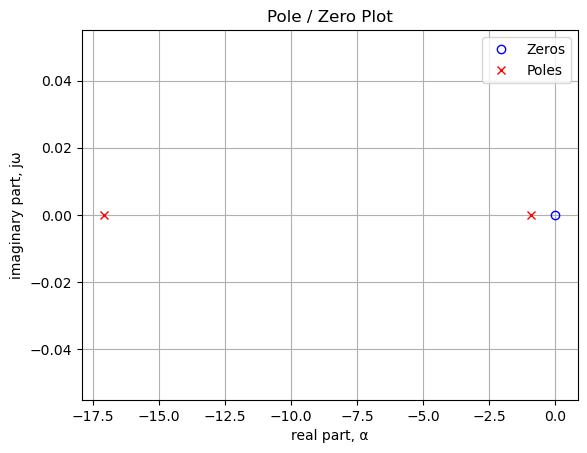

In [158]:
#| echo: false
#| fig-cap: fig cap
sys_zeros = np.roots(sys_tf.num)
sys_poles = np.roots(sys_tf.den)

plt.plot(np.real(sys_zeros), np.imag(sys_zeros), 'ob', markerfacecolor='none')
plt.plot(np.real(sys_poles), np.imag(sys_poles), 'xr')
plt.legend(['Zeros', 'Poles'], loc=0)
plt.title('Pole / Zero Plot')
plt.xlabel('real part, \u03B1')
plt.ylabel('imaginary part, j\u03C9')
plt.grid()
plt.show()

The units of the poles and zeros are in radian frequency and are tabulated below.

In [159]:
#| echo: false
#| tbl-cap: table of poles and zeros

table_header = ['Zeros, rad/s', 'Poles, rad/s']
num_table_rows = max(len(sys_zeros),len(sys_poles))
table_row = []

for i in range(num_table_rows):
    if i < len(sys_zeros):
        z = '{:.2f}'.format(sys_zeros[i])
    else:
        z = ''
    if i < len(sys_poles):
        p = '{:.2f}'.format(sys_poles[i])
    else:
        p = ''
    table_row.append([z,p])

print(tabulate(table_row, headers=table_header,colalign = ('left','left'),tablefmt="simple"))

Zeros, rad/s    Poles, rad/s
--------------  --------------
0.00            -17.06
                -0.94


The values of the poles network are the same a chosen above, thus validating the solution.

The magnitude and phase of the filter's transfer function is plotted below.

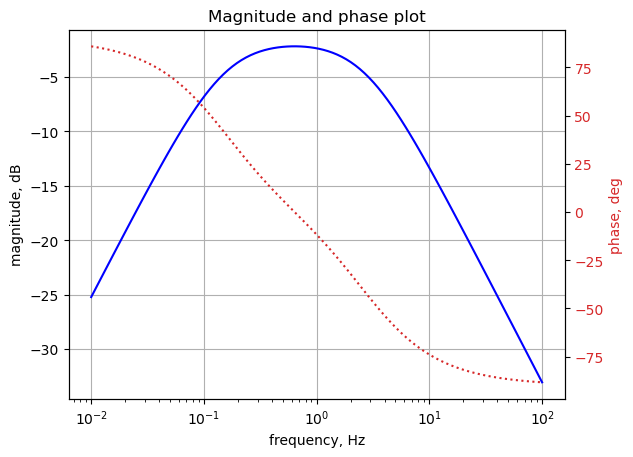

In [160]:
#| echo: false
#| fig-cap: fig cap

x = np.logspace(-2, 2, 100, endpoint=True)*2*np.pi
w, mag, phase = signal.bode(sys_tf, w=x) # returns: rad/s, mag in dB, phase in deg

fig, ax1 = plt.subplots()
ax1.set_ylabel('magnitude, dB')
ax1.set_xlabel('frequency, Hz')

plt.semilogx(w/(2*np.pi), mag,'-b')    # magnitude plot
#ax1.set_ylim(-1,1)
ax1.tick_params(axis='y')
plt.grid()

# instantiate a second y-axes that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:red'

plt.semilogx(w/(2*np.pi), phase,':',color='tab:red')  # phase plot

ax2.set_ylabel('phase, deg',color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Magnitude and phase plot')
plt.show()

The step response is plotted below.

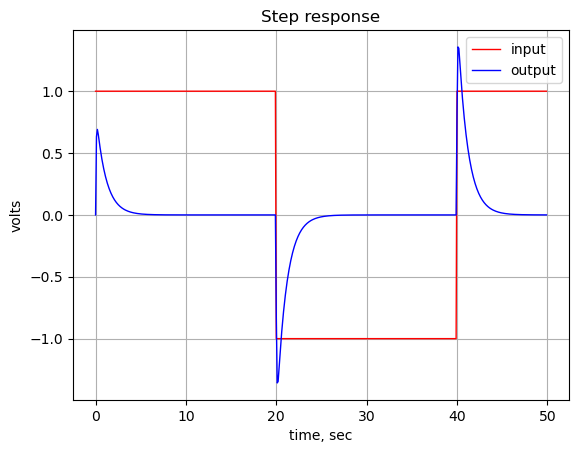

In [161]:
#| echo: false
#| fig-cap: fig cap

# define the time interval and create a square wave step waveform.
t = np.linspace(0, 50, 500, endpoint=False)
sqr_signal = signal.square(2*np.pi*0.025*t, duty=0.5)

# call lsim to generate the response signal
t_step, y_step, x_step = signal.lsim(sys_tf, U=sqr_signal, T=t)

plt.plot(t_step, sqr_signal, 'r', alpha = 1.0, linewidth=1, label='input')
plt.plot(t_step, y_step,'b', linewidth = 1.0, label='output')
plt.title('Step response')
plt.ylabel('volts')
plt.xlabel('time, sec')
plt.grid()
plt.legend(loc='best')
# show plot
plt.show()

# Variation 5a

![](Twin-T-variation5a.png)



In [162]:
example_net_list = '''
* Twin-T-variation5a.asc
R1 3 1 1
R2 2 4 1
R3 4 0 1
C1 4 1 1
C2 2 3 1
C3 3 0 1
V1 1 0 1
R4 2 0 1
'''

In [163]:
#| echo: true
report, network_df, df2, A, X, Z = SymMNA.smna(example_net_list)

X = Matrix(X)
Z = Matrix(Z)

NE_sym = Eq(A*X,Z)

var(str(NE_sym.free_symbols).replace('{','').replace('}',''))
nominal_component_value = SymMNA.get_part_values(network_df)

# N is the variation number
U_sym = solve(NE_sym,X)
H_sym = cancel(U_sym[v2]/U_sym[v1],s)

In [164]:
#| echo: false
Markdown('$H(s)={:s}$'.format(latex(H_sym)))

$H(s)=\frac{s^{2} \left(C_{1} C_{2} R_{1} R_{3} R_{4} + C_{1} C_{2} R_{2} R_{3} R_{4} + C_{1} C_{3} R_{1} R_{3} R_{4}\right) + s \left(C_{1} R_{3} R_{4} + C_{2} R_{2} R_{4} + C_{2} R_{3} R_{4}\right)}{C_{1} C_{2} C_{3} R_{1} R_{2} R_{3} R_{4} s^{3} + R_{2} + R_{3} + R_{4} + s^{2} \left(C_{1} C_{2} R_{1} R_{2} R_{3} + C_{1} C_{2} R_{1} R_{3} R_{4} + C_{1} C_{2} R_{2} R_{3} R_{4} + C_{1} C_{3} R_{1} R_{2} R_{3} + C_{1} C_{3} R_{1} R_{3} R_{4} + C_{2} C_{3} R_{1} R_{2} R_{4} + C_{2} C_{3} R_{1} R_{3} R_{4}\right) + s \left(C_{1} R_{2} R_{3} + C_{1} R_{3} R_{4} + C_{2} R_{1} R_{2} + C_{2} R_{1} R_{3} + C_{2} R_{1} R_{4} + C_{2} R_{2} R_{4} + C_{2} R_{3} R_{4} + C_{3} R_{1} R_{2} + C_{3} R_{1} R_{3} + C_{3} R_{1} R_{4}\right)}$

Making the substitutions: $R_1=R_3=R$, $R_2=2R$, $R_4=5$, $R_5=R_6=2$, $C_1=C_3=C$ and $C_2=C/2$, we get:

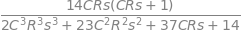

In [165]:
sub_values = {R1:R, R2:R/2, R3:R, R4:2*R, C1:C, C2:C/2, C3:C}
H_sym.subs(sub_values).simplify()

In [166]:
#| echo: false
H_sym = H_sym.subs(sub_values).simplify()
Markdown('$H(s)={:s}$'.format(latex(H_sym)))

$H(s)=\frac{14 C R s \left(C R s + 1\right)}{2 C^{3} R^{3} s^{3} + 23 C^{2} R^{2} s^{2} + 37 C R s + 14}$

In [167]:
#| echo: false
H_sym_num, H_sym_denom = fraction(H_sym,s) #returns numerator and denominator

In [168]:
H_sym_num = H_sym_num.expand().collect(s)

In [169]:
H_sym_num

In [170]:
H_sym_denom = H_sym_denom.expand().collect(s)

The numerator polynominal is:

In [171]:
#| echo: false
Markdown('$N(s)={:s}$'.format(latex(H_sym_num)))

$N(s)=14 C^{2} R^{2} s^{2} + 14 C R s$

In [172]:
#| echo: false
num_root_sym = solve(H_sym_num,s)
Markdown('${:s}$'.format(latex(num_root_sym)))

$\left[ 0, \  - \frac{1}{C R}\right]$

The denominator polynominal is:

In [173]:
#| echo: false
Markdown('$D(s)={:s}$'.format(latex(H_sym_denom)))

$D(s)=2 C^{3} R^{3} s^{3} + 23 C^{2} R^{2} s^{2} + 37 C R s + 14$

The roots of the denominator polynominal can found with SymPy.

In [174]:
#| echo: false
denom_root_sym = solve(H_sym_denom,s)
Markdown('${:s}$'.format(latex(denom_root_sym)))

$\left[ \frac{- \frac{23}{6} - \frac{307}{12 \left(- \frac{1}{2} - \frac{\sqrt{3} i}{2}\right) \sqrt[3]{658 + \frac{3 \sqrt{136083} i}{8}}} - \frac{\left(- \frac{1}{2} - \frac{\sqrt{3} i}{2}\right) \sqrt[3]{658 + \frac{3 \sqrt{136083} i}{8}}}{3}}{C R}, \  \frac{- \frac{23}{6} - \frac{\left(- \frac{1}{2} + \frac{\sqrt{3} i}{2}\right) \sqrt[3]{658 + \frac{3 \sqrt{136083} i}{8}}}{3} - \frac{307}{12 \left(- \frac{1}{2} + \frac{\sqrt{3} i}{2}\right) \sqrt[3]{658 + \frac{3 \sqrt{136083} i}{8}}}}{C R}, \  \frac{- \frac{23}{6} - \frac{\sqrt[3]{658 + \frac{3 \sqrt{136083} i}{8}}}{3} - \frac{307}{12 \sqrt[3]{658 + \frac{3 \sqrt{136083} i}{8}}}}{C R}\right]$

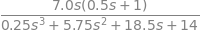

In [175]:
sub_values = {R:1,C:1/2}
H_sym.subs(sub_values)

In [176]:
#| echo: false
H_num, H_denom = fraction(H_sym.subs(sub_values)) #returns numerator and denominator

# convert symbolic to numpy polynomial
a = np.array(Poly(H_num, s).all_coeffs(), dtype=float)
b = np.array(Poly(H_denom, s).all_coeffs(), dtype=float)
sys_tf = signal.TransferFunction(a,b)

The poles and zeros of the transfer function are plotted below:

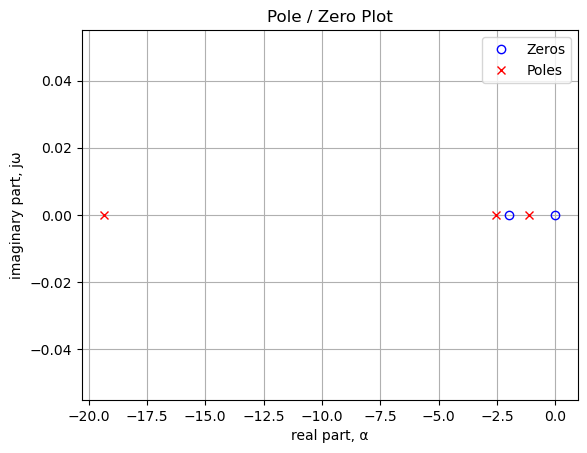

In [177]:
#| echo: false
#| fig-cap: fig cap
sys_zeros = np.roots(sys_tf.num)
sys_poles = np.roots(sys_tf.den)

plt.plot(np.real(sys_zeros), np.imag(sys_zeros), 'ob', markerfacecolor='none')
plt.plot(np.real(sys_poles), np.imag(sys_poles), 'xr')
plt.legend(['Zeros', 'Poles'], loc=0)
plt.title('Pole / Zero Plot')
plt.xlabel('real part, \u03B1')
plt.ylabel('imaginary part, j\u03C9')
plt.grid()
plt.show()

The units of the poles and zeros are in radian frequency and are tabulated below.

In [178]:
#| echo: false
#| tbl-cap: table of poles and zeros

table_header = ['Zeros, rad/s', 'Poles, rad/s']
num_table_rows = max(len(sys_zeros),len(sys_poles))
table_row = []

for i in range(num_table_rows):
    if i < len(sys_zeros):
        z = '{:.2f}'.format(sys_zeros[i])
    else:
        z = ''
    if i < len(sys_poles):
        p = '{:.2f}'.format(sys_poles[i])
    else:
        p = ''
    table_row.append([z,p])

print(tabulate(table_row, headers=table_header,colalign = ('left','left'),tablefmt="simple"))

Zeros, rad/s    Poles, rad/s
--------------  --------------
-2.00           -19.32
0.00            -2.54
                -1.14


The values of the poles network are the same a chosen above, thus validating the solution.

The magnitude and phase of the filter's transfer function is plotted below.

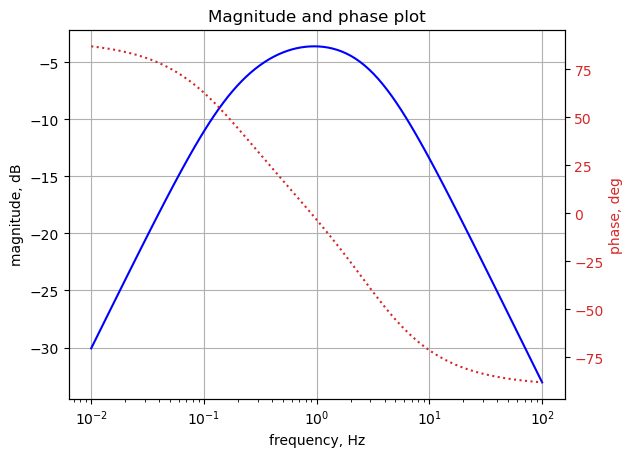

In [179]:
#| echo: false
#| fig-cap: fig cap

x = np.logspace(-2, 2, 100, endpoint=True)*2*np.pi
w, mag, phase = signal.bode(sys_tf, w=x) # returns: rad/s, mag in dB, phase in deg

fig, ax1 = plt.subplots()
ax1.set_ylabel('magnitude, dB')
ax1.set_xlabel('frequency, Hz')

plt.semilogx(w/(2*np.pi), mag,'-b')    # magnitude plot
#ax1.set_ylim(-1,1)
ax1.tick_params(axis='y')
plt.grid()

# instantiate a second y-axes that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:red'

plt.semilogx(w/(2*np.pi), phase,':',color='tab:red')  # phase plot

ax2.set_ylabel('phase, deg',color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Magnitude and phase plot')
plt.show()

The step response is plotted below.

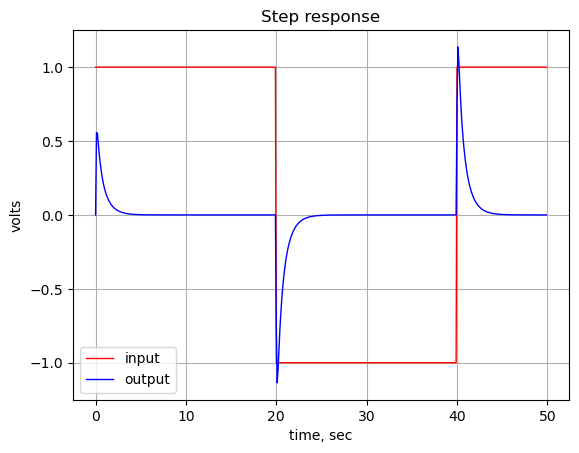

In [180]:
#| echo: false
#| fig-cap: fig cap

# define the time interval and create a square wave step waveform.
t = np.linspace(0, 50, 500, endpoint=False)
sqr_signal = signal.square(2*np.pi*0.025*t, duty=0.5)

# call lsim to generate the response signal
t_step, y_step, x_step = signal.lsim(sys_tf, U=sqr_signal, T=t)

plt.plot(t_step, sqr_signal, 'r', alpha = 1.0, linewidth=1, label='input')
plt.plot(t_step, y_step,'b', linewidth = 1.0, label='output')
plt.title('Step response')
plt.ylabel('volts')
plt.xlabel('time, sec')
plt.grid()
plt.legend(loc='best')
# show plot
plt.show()

# Variation 5b

![](Twin-T-variation5b.png)



In [181]:
example_net_list = '''
* Twin-T-variation5b.asc
R1 3 1 1
R2 2 4 1
R3 4 0 1
C1 4 1 1
C2 2 3 1
C3 3 0 1
V1 1 0 1
C4 2 0 1
'''

In [182]:
#| echo: true
report, network_df, df2, A, X, Z = SymMNA.smna(example_net_list)

X = Matrix(X)
Z = Matrix(Z)

NE_sym = Eq(A*X,Z)

var(str(NE_sym.free_symbols).replace('{','').replace('}',''))
nominal_component_value = SymMNA.get_part_values(network_df)

# N is the variation number
U_sym = solve(NE_sym,X)
H_sym = cancel(U_sym[v2]/U_sym[v1],s)

In [183]:
#| echo: false
Markdown('$H(s)={:s}$'.format(latex(H_sym)))

$H(s)=\frac{s^{2} \left(C_{1} C_{2} R_{1} R_{3} + C_{1} C_{2} R_{2} R_{3} + C_{1} C_{3} R_{1} R_{3}\right) + s \left(C_{1} R_{3} + C_{2} R_{2} + C_{2} R_{3}\right)}{s^{3} \left(C_{1} C_{2} C_{3} R_{1} R_{2} R_{3} + C_{1} C_{2} C_{4} R_{1} R_{2} R_{3} + C_{1} C_{3} C_{4} R_{1} R_{2} R_{3}\right) + s^{2} \left(C_{1} C_{2} R_{1} R_{3} + C_{1} C_{2} R_{2} R_{3} + C_{1} C_{3} R_{1} R_{3} + C_{1} C_{4} R_{2} R_{3} + C_{2} C_{3} R_{1} R_{2} + C_{2} C_{3} R_{1} R_{3} + C_{2} C_{4} R_{1} R_{2} + C_{2} C_{4} R_{1} R_{3} + C_{3} C_{4} R_{1} R_{2} + C_{3} C_{4} R_{1} R_{3}\right) + s \left(C_{1} R_{3} + C_{2} R_{1} + C_{2} R_{2} + C_{2} R_{3} + C_{3} R_{1} + C_{4} R_{2} + C_{4} R_{3}\right) + 1}$

Making the substitutions: $R_1=R_3=R$, $R_2=2R$, $R_4=5$, $R_5=R_6=2$, $C_1=C_3=C$ and $C_2=C/2$, we get:

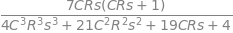

In [184]:
sub_values = {R1:R, R2:R/2, R3:R, C4:C, C1:C, C2:C/2, C3:C}
H_sym.subs(sub_values).simplify()

In [185]:
#| echo: false
H_sym = H_sym.subs(sub_values).simplify()
Markdown('$H(s)={:s}$'.format(latex(H_sym)))

$H(s)=\frac{7 C R s \left(C R s + 1\right)}{4 C^{3} R^{3} s^{3} + 21 C^{2} R^{2} s^{2} + 19 C R s + 4}$

In [186]:
#| echo: false
H_sym_num, H_sym_denom = fraction(H_sym,s) #returns numerator and denominator

In [187]:
H_sym_num = H_sym_num.expand().collect(s)

In [188]:
H_sym_num

In [189]:
H_sym_denom = H_sym_denom.expand().collect(s)

The numerator polynominal is:

In [190]:
#| echo: false
Markdown('$N(s)={:s}$'.format(latex(H_sym_num)))

$N(s)=7 C^{2} R^{2} s^{2} + 7 C R s$

In [191]:
#| echo: false
num_root_sym = solve(H_sym_num,s)
Markdown('${:s}$'.format(latex(num_root_sym)))

$\left[ 0, \  - \frac{1}{C R}\right]$

The denominator polynominal is:

In [192]:
#| echo: false
Markdown('$D(s)={:s}$'.format(latex(H_sym_denom)))

$D(s)=4 C^{3} R^{3} s^{3} + 21 C^{2} R^{2} s^{2} + 19 C R s + 4$

The roots of the denominator polynominal can found with SymPy.

In [193]:
#| echo: false
denom_root_sym = solve(H_sym_denom,s)
Markdown('${:s}$'.format(latex(denom_root_sym)))

$\left[ \frac{- \frac{7}{4} - \frac{71}{16 \left(- \frac{1}{2} - \frac{\sqrt{3} i}{2}\right) \sqrt[3]{\frac{2943}{64} + \frac{3 \sqrt{27843} i}{32}}} - \frac{\left(- \frac{1}{2} - \frac{\sqrt{3} i}{2}\right) \sqrt[3]{\frac{2943}{64} + \frac{3 \sqrt{27843} i}{32}}}{3}}{C R}, \  \frac{- \frac{7}{4} - \frac{\left(- \frac{1}{2} + \frac{\sqrt{3} i}{2}\right) \sqrt[3]{\frac{2943}{64} + \frac{3 \sqrt{27843} i}{32}}}{3} - \frac{71}{16 \left(- \frac{1}{2} + \frac{\sqrt{3} i}{2}\right) \sqrt[3]{\frac{2943}{64} + \frac{3 \sqrt{27843} i}{32}}}}{C R}, \  \frac{- \frac{7}{4} - \frac{\sqrt[3]{\frac{2943}{64} + \frac{3 \sqrt{27843} i}{32}}}{3} - \frac{71}{16 \sqrt[3]{\frac{2943}{64} + \frac{3 \sqrt{27843} i}{32}}}}{C R}\right]$

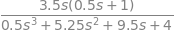

In [194]:
sub_values = {R:1,C:1/2}
H_sym.subs(sub_values)

In [195]:
#| echo: false
H_num, H_denom = fraction(H_sym.subs(sub_values)) #returns numerator and denominator

# convert symbolic to numpy polynomial
a = np.array(Poly(H_num, s).all_coeffs(), dtype=float)
b = np.array(Poly(H_denom, s).all_coeffs(), dtype=float)
sys_tf = signal.TransferFunction(a,b)

The poles and zeros of the transfer function are plotted below:

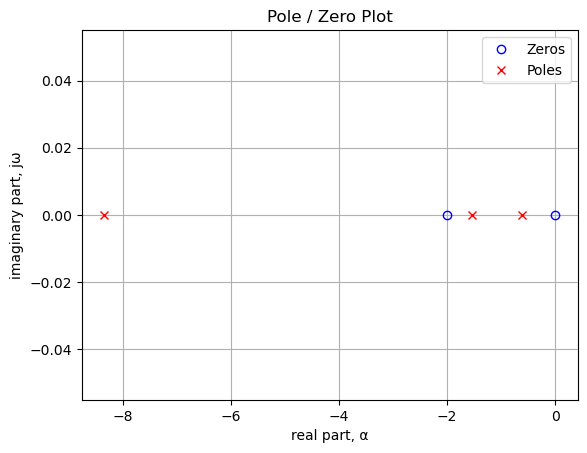

In [196]:
#| echo: false
#| fig-cap: fig cap
sys_zeros = np.roots(sys_tf.num)
sys_poles = np.roots(sys_tf.den)

plt.plot(np.real(sys_zeros), np.imag(sys_zeros), 'ob', markerfacecolor='none')
plt.plot(np.real(sys_poles), np.imag(sys_poles), 'xr')
plt.legend(['Zeros', 'Poles'], loc=0)
plt.title('Pole / Zero Plot')
plt.xlabel('real part, \u03B1')
plt.ylabel('imaginary part, j\u03C9')
plt.grid()
plt.show()

The units of the poles and zeros are in radian frequency and are tabulated below.

In [197]:
#| echo: false
#| tbl-cap: table of poles and zeros

table_header = ['Zeros, rad/s', 'Poles, rad/s']
num_table_rows = max(len(sys_zeros),len(sys_poles))
table_row = []

for i in range(num_table_rows):
    if i < len(sys_zeros):
        z = '{:.2f}'.format(sys_zeros[i])
    else:
        z = ''
    if i < len(sys_poles):
        p = '{:.2f}'.format(sys_poles[i])
    else:
        p = ''
    table_row.append([z,p])

print(tabulate(table_row, headers=table_header,colalign = ('left','left'),tablefmt="simple"))

Zeros, rad/s    Poles, rad/s
--------------  --------------
-2.00           -8.34
0.00            -1.54
                -0.62


The values of the poles network are the same a chosen above, thus validating the solution.

The magnitude and phase of the filter's transfer function is plotted below.

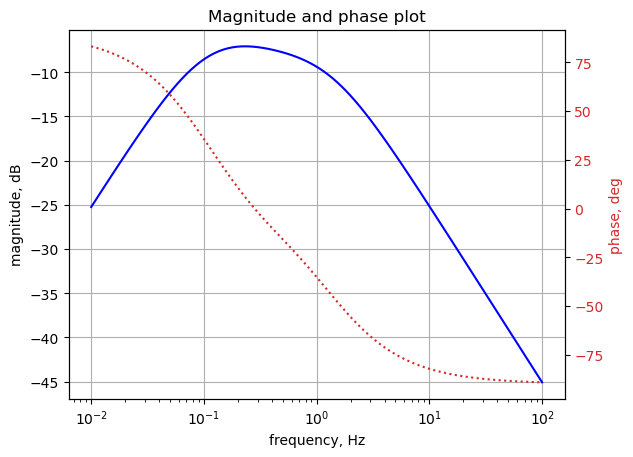

In [198]:
#| echo: false
#| fig-cap: fig cap

x = np.logspace(-2, 2, 100, endpoint=True)*2*np.pi
w, mag, phase = signal.bode(sys_tf, w=x) # returns: rad/s, mag in dB, phase in deg

fig, ax1 = plt.subplots()
ax1.set_ylabel('magnitude, dB')
ax1.set_xlabel('frequency, Hz')

plt.semilogx(w/(2*np.pi), mag,'-b')    # magnitude plot
#ax1.set_ylim(-1,1)
ax1.tick_params(axis='y')
plt.grid()

# instantiate a second y-axes that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:red'

plt.semilogx(w/(2*np.pi), phase,':',color='tab:red')  # phase plot

ax2.set_ylabel('phase, deg',color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Magnitude and phase plot')
plt.show()

The step response is plotted below.

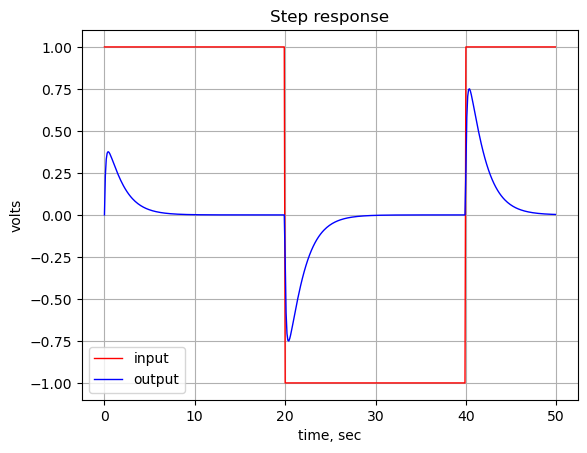

In [199]:
#| echo: false
#| fig-cap: fig cap

# define the time interval and create a square wave step waveform.
t = np.linspace(0, 50, 500, endpoint=False)
sqr_signal = signal.square(2*np.pi*0.025*t, duty=0.5)

# call lsim to generate the response signal
t_step, y_step, x_step = signal.lsim(sys_tf, U=sqr_signal, T=t)

plt.plot(t_step, sqr_signal, 'r', alpha = 1.0, linewidth=1, label='input')
plt.plot(t_step, y_step,'b', linewidth = 1.0, label='output')
plt.title('Step response')
plt.ylabel('volts')
plt.xlabel('time, sec')
plt.grid()
plt.legend(loc='best')
# show plot
plt.show()

# Twin-T-variation 6

- Using R4 prodectes a High pass filter
- R4 replace with a capacitor produces a Low Pass

![](Twin-T-variation6.png)

In [200]:
example_net_list = '''
* Twin-T-variation6.asc
R1 3 1 1
R2 5 4 1
R3 4 2 1
C1 4 1 1
C2 5 3 1
C3 3 2 1
V1 1 0 1
O1 2 5 2
C4 5 0 1
'''

In [201]:
#| echo: true
report, network_df, df2, A, X, Z = SymMNA.smna(example_net_list)

X = Matrix(X)
Z = Matrix(Z)

NE_sym = Eq(A*X,Z)

var(str(NE_sym.free_symbols).replace('{','').replace('}',''))
nominal_component_value = SymMNA.get_part_values(network_df)

# N is the variation number
U_sym = solve(NE_sym,X)
H_sym = cancel(U_sym[v2]/U_sym[v1],s)

#| echo: false
Markdown('$H(s)={:s}$'.format(latex(H_sym)))

$H(s)=\frac{C_{1} R_{3} + C_{2} R_{2} + C_{2} R_{3} + s \left(C_{1} C_{2} R_{1} R_{3} + C_{1} C_{2} R_{2} R_{3} + C_{1} C_{3} R_{1} R_{3}\right)}{C_{1} R_{3} + C_{2} R_{2} + C_{2} R_{3} + C_{4} R_{2} + C_{4} R_{3} + s^{2} \left(C_{1} C_{2} C_{4} R_{1} R_{2} R_{3} + C_{1} C_{3} C_{4} R_{1} R_{2} R_{3}\right) + s \left(C_{1} C_{2} R_{1} R_{3} + C_{1} C_{2} R_{2} R_{3} + C_{1} C_{3} R_{1} R_{3} + C_{1} C_{4} R_{2} R_{3} + C_{2} C_{4} R_{1} R_{2} + C_{2} C_{4} R_{1} R_{3} + C_{3} C_{4} R_{1} R_{2} + C_{3} C_{4} R_{1} R_{3}\right)}$

Making the substitutions: $R_1=R_3=R$, $R_2=2R$, $R_4=5$, $R_5=R_6=2$, $C_1=C_3=C$ and $C_2=C/2$, we get:

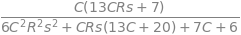

In [202]:
sub_values = {R1:2*R, R2:R/2, R3:R, R4:1, C4:1, C1:C, C2:C/2, C3:C}
H_sym.subs(sub_values).simplify()

In [203]:
#| echo: false
H_sym = H_sym.subs(sub_values).simplify()
Markdown('$H(s)={:s}$'.format(latex(H_sym)))

$H(s)=\frac{C \left(13 C R s + 7\right)}{6 C^{2} R^{2} s^{2} + C R s \left(13 C + 20\right) + 7 C + 6}$

In [204]:
#| echo: false
H_sym_num, H_sym_denom = fraction(H_sym,s) #returns numerator and denominator

In [205]:
H_sym_num = H_sym_num.expand().collect(s)

In [206]:
H_sym_num

In [207]:
H_sym_denom = H_sym_denom.expand().collect(s)

The numerator polynominal is:

In [208]:
#| echo: false
Markdown('$N(s)={:s}$'.format(latex(H_sym_num)))

$N(s)=13 C^{2} R s + 7 C$

In [209]:
#| echo: false
num_root_sym = solve(H_sym_num,s)
Markdown('${:s}$'.format(latex(num_root_sym)))

$\left[ - \frac{7}{13 C R}\right]$

The denominator polynominal is:

In [210]:
#| echo: false
Markdown('$D(s)={:s}$'.format(latex(H_sym_denom)))

$D(s)=6 C^{2} R^{2} s^{2} + 7 C + s \left(13 C^{2} R + 20 C R\right) + 6$

The roots of the denominator polynominal can found with SymPy.

In [211]:
#| echo: false
denom_root_sym = solve(H_sym_denom,s)
Markdown('${:s}$'.format(latex(denom_root_sym)))

$\left[ \frac{- 13 C - \sqrt{169 C^{2} + 352 C + 256} - 20}{12 C R}, \  \frac{- 13 C + \sqrt{169 C^{2} + 352 C + 256} - 20}{12 C R}\right]$

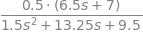

In [212]:
sub_values = {R:1, C:1/2}
H_sym.subs(sub_values)

In [213]:
#| echo: false
H_num, H_denom = fraction(H_sym.subs(sub_values)) #returns numerator and denominator

# convert symbolic to numpy polynomial
a = np.array(Poly(H_num, s).all_coeffs(), dtype=float)
b = np.array(Poly(H_denom, s).all_coeffs(), dtype=float)
sys_tf = signal.TransferFunction(a,b)

The poles and zeros of the transfer function are plotted below:

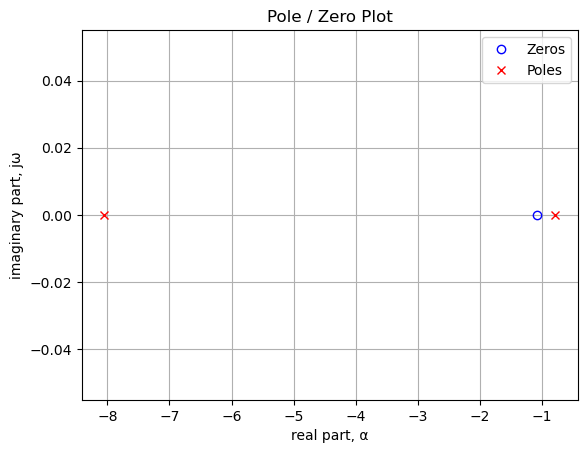

In [214]:
#| echo: false
#| fig-cap: fig cap
sys_zeros = np.roots(sys_tf.num)
sys_poles = np.roots(sys_tf.den)

plt.plot(np.real(sys_zeros), np.imag(sys_zeros), 'ob', markerfacecolor='none')
plt.plot(np.real(sys_poles), np.imag(sys_poles), 'xr')
plt.legend(['Zeros', 'Poles'], loc=0)
plt.title('Pole / Zero Plot')
plt.xlabel('real part, \u03B1')
plt.ylabel('imaginary part, j\u03C9')
plt.grid()
plt.show()

The units of the poles and zeros are in radian frequency and are tabulated below.

In [215]:
#| echo: false
#| tbl-cap: table of poles and zeros

table_header = ['Zeros, rad/s', 'Poles, rad/s']
num_table_rows = max(len(sys_zeros),len(sys_poles))
table_row = []

for i in range(num_table_rows):
    if i < len(sys_zeros):
        z = '{:.2f}'.format(sys_zeros[i])
    else:
        z = ''
    if i < len(sys_poles):
        p = '{:.2f}'.format(sys_poles[i])
    else:
        p = ''
    table_row.append([z,p])

print(tabulate(table_row, headers=table_header,colalign = ('left','left'),tablefmt="simple"))

Zeros, rad/s    Poles, rad/s
--------------  --------------
-1.08           -8.05
                -0.79


The values of the poles network are the same a chosen above, thus validating the solution.

The magnitude and phase of the filter's transfer function is plotted below.

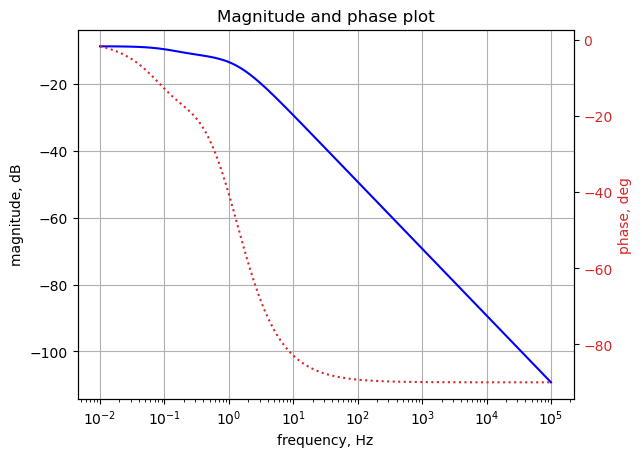

In [216]:
#| echo: false
#| fig-cap: fig cap

x = np.logspace(-2, 5, 100, endpoint=True)*2*np.pi
w, mag, phase = signal.bode(sys_tf, w=x) # returns: rad/s, mag in dB, phase in deg

fig, ax1 = plt.subplots()
ax1.set_ylabel('magnitude, dB')
ax1.set_xlabel('frequency, Hz')

plt.semilogx(w/(2*np.pi), mag,'-b')    # magnitude plot
#ax1.set_ylim(-1,1)
ax1.tick_params(axis='y')
plt.grid()

# instantiate a second y-axes that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:red'

plt.semilogx(w/(2*np.pi), phase,':',color='tab:red')  # phase plot

ax2.set_ylabel('phase, deg',color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Magnitude and phase plot')
plt.show()

The step response is plotted below.

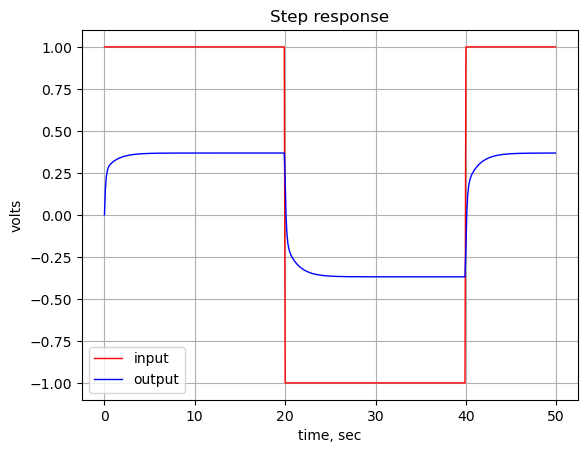

In [217]:
#| echo: false
#| fig-cap: fig cap

# define the time interval and create a square wave step waveform.
t = np.linspace(0, 50, 500, endpoint=False)
sqr_signal = signal.square(2*np.pi*0.025*t, duty=0.5)

# call lsim to generate the response signal
t_step, y_step, x_step = signal.lsim(sys_tf, U=sqr_signal, T=t)

plt.plot(t_step, sqr_signal, 'r', alpha = 1.0, linewidth=1, label='input')
plt.plot(t_step, y_step,'b', linewidth = 1.0, label='output')
plt.title('Step response')
plt.ylabel('volts')
plt.xlabel('time, sec')
plt.grid()
plt.legend(loc='best')
# show plot
plt.show()

# Twin-T-variation7

High pass filter

R4 replace by C produces a LP, but the gain is low

![](Twin-T-variation7.png)

In [218]:
example_net_list = '''
* Twin-T-variation7.asc
R1 5 3 1
R2 4 1 1
R3 3 2 1
C1 5 4 1
C2 3 1 1
C3 4 2 1
V1 1 0 1
O1 2 5 2
C4 5 0 1
'''

In [219]:
#| echo: true
report, network_df, df2, A, X, Z = SymMNA.smna(example_net_list)

X = Matrix(X)
Z = Matrix(Z)

NE_sym = Eq(A*X,Z)

var(str(NE_sym.free_symbols).replace('{','').replace('}',''))
nominal_component_value = SymMNA.get_part_values(network_df)

# N is the variation number
U_sym = solve(NE_sym,X)
H_sym = cancel(U_sym[v2]/U_sym[v1],s)

#| echo: false
Markdown('$H(s)={:s}$'.format(latex(H_sym)))

$H(s)=\frac{C_{1} R_{1} + C_{1} R_{3} + C_{2} R_{3} + s \left(C_{1} C_{2} R_{1} R_{3} + C_{1} C_{2} R_{2} R_{3} + C_{2} C_{3} R_{2} R_{3}\right)}{C_{1} R_{1} + C_{1} R_{3} + C_{2} R_{3} + C_{4} R_{1} + C_{4} R_{3} + s^{2} \left(C_{1} C_{2} C_{4} R_{1} R_{2} R_{3} + C_{2} C_{3} C_{4} R_{1} R_{2} R_{3}\right) + s \left(C_{1} C_{2} R_{1} R_{3} + C_{1} C_{2} R_{2} R_{3} + C_{1} C_{4} R_{1} R_{2} + C_{1} C_{4} R_{2} R_{3} + C_{2} C_{3} R_{2} R_{3} + C_{2} C_{4} R_{1} R_{3} + C_{3} C_{4} R_{1} R_{2} + C_{3} C_{4} R_{2} R_{3}\right)}$

Making the substitutions: $R_1=R_3=R$, $R_2=2R$, $R_4=5$, $R_5=R_6=2$, $C_1=C_3=C$ and $C_2=C/2$, we get:

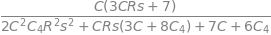

In [220]:
sub_values = {R1:2*R, R2:R/2, R3:R, C1:C, C2:C/2, C3:C}
H_sym.subs(sub_values).simplify()

In [221]:
#| echo: false
H_sym = H_sym.subs(sub_values).simplify()
Markdown('$H(s)={:s}$'.format(latex(H_sym)))

$H(s)=\frac{C \left(3 C R s + 7\right)}{2 C^{2} C_{4} R^{2} s^{2} + C R s \left(3 C + 8 C_{4}\right) + 7 C + 6 C_{4}}$

In [222]:
#| echo: false
H_sym_num, H_sym_denom = fraction(H_sym,s) #returns numerator and denominator

In [223]:
H_sym_num = H_sym_num.expand().collect(s)

In [224]:
H_sym_num

In [225]:
H_sym_denom = H_sym_denom.expand().collect(s)

The numerator polynominal is:

In [226]:
#| echo: false
Markdown('$N(s)={:s}$'.format(latex(H_sym_num)))

$N(s)=3 C^{2} R s + 7 C$

In [227]:
#| echo: false
num_root_sym = solve(H_sym_num,s)
Markdown('${:s}$'.format(latex(num_root_sym)))

$\left[ - \frac{7}{3 C R}\right]$

The denominator polynominal is:

In [228]:
#| echo: false
Markdown('$D(s)={:s}$'.format(latex(H_sym_denom)))

$D(s)=2 C^{2} C_{4} R^{2} s^{2} + 7 C + 6 C_{4} + s \left(3 C^{2} R + 8 C C_{4} R\right)$

The roots of the denominator polynominal can found with SymPy.

In [229]:
#| echo: false
denom_root_sym = solve(H_sym_denom,s)
Markdown('${:s}$'.format(latex(denom_root_sym)))

$\left[ \frac{- 3 C - 8 C_{4} - \sqrt{9 C^{2} - 8 C C_{4} + 16 C_{4}^{2}}}{4 C C_{4} R}, \  \frac{- 3 C - 8 C_{4} + \sqrt{9 C^{2} - 8 C C_{4} + 16 C_{4}^{2}}}{4 C C_{4} R}\right]$

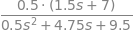

In [230]:
sub_values = {R:1, C:1/2, C4:1}
H_sym.subs(sub_values)

In [231]:
#| echo: false
H_num, H_denom = fraction(H_sym.subs(sub_values)) #returns numerator and denominator

# convert symbolic to numpy polynomial
a = np.array(Poly(H_num, s).all_coeffs(), dtype=float)
b = np.array(Poly(H_denom, s).all_coeffs(), dtype=float)
sys_tf = signal.TransferFunction(a,b)

The poles and zeros of the transfer function are plotted below:

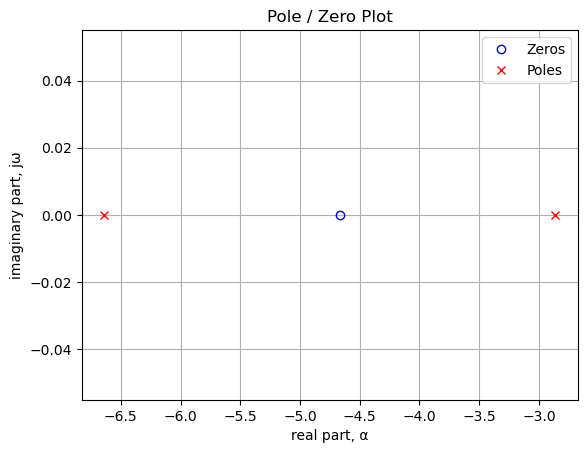

In [232]:
#| echo: false
#| fig-cap: fig cap
sys_zeros = np.roots(sys_tf.num)
sys_poles = np.roots(sys_tf.den)

plt.plot(np.real(sys_zeros), np.imag(sys_zeros), 'ob', markerfacecolor='none')
plt.plot(np.real(sys_poles), np.imag(sys_poles), 'xr')
plt.legend(['Zeros', 'Poles'], loc=0)
plt.title('Pole / Zero Plot')
plt.xlabel('real part, \u03B1')
plt.ylabel('imaginary part, j\u03C9')
plt.grid()
plt.show()

The units of the poles and zeros are in radian frequency and are tabulated below.

In [233]:
#| echo: false
#| tbl-cap: table of poles and zeros

table_header = ['Zeros, rad/s', 'Poles, rad/s']
num_table_rows = max(len(sys_zeros),len(sys_poles))
table_row = []

for i in range(num_table_rows):
    if i < len(sys_zeros):
        z = '{:.2f}'.format(sys_zeros[i])
    else:
        z = ''
    if i < len(sys_poles):
        p = '{:.2f}'.format(sys_poles[i])
    else:
        p = ''
    table_row.append([z,p])

print(tabulate(table_row, headers=table_header,colalign = ('left','left'),tablefmt="simple"))

Zeros, rad/s    Poles, rad/s
--------------  --------------
-4.67           -6.64
                -2.86


The values of the poles network are the same a chosen above, thus validating the solution.

The magnitude and phase of the filter's transfer function is plotted below.

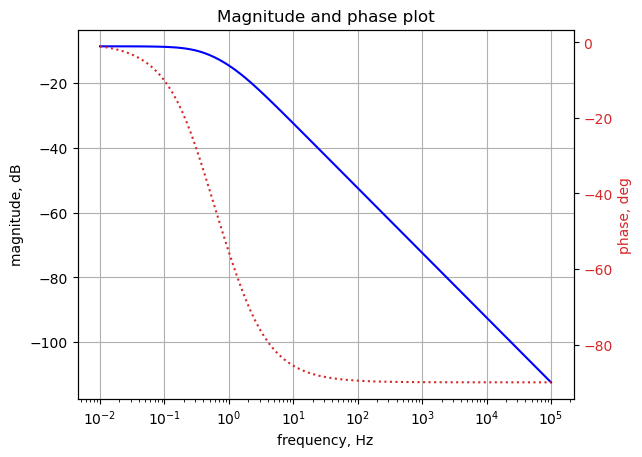

In [234]:
#| echo: false
#| fig-cap: fig cap

x = np.logspace(-2, 5, 100, endpoint=True)*2*np.pi
w, mag, phase = signal.bode(sys_tf, w=x) # returns: rad/s, mag in dB, phase in deg

fig, ax1 = plt.subplots()
ax1.set_ylabel('magnitude, dB')
ax1.set_xlabel('frequency, Hz')

plt.semilogx(w/(2*np.pi), mag,'-b')    # magnitude plot
#ax1.set_ylim(-1,1)
ax1.tick_params(axis='y')
plt.grid()

# instantiate a second y-axes that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:red'

plt.semilogx(w/(2*np.pi), phase,':',color='tab:red')  # phase plot

ax2.set_ylabel('phase, deg',color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Magnitude and phase plot')
plt.show()

The step response is plotted below.

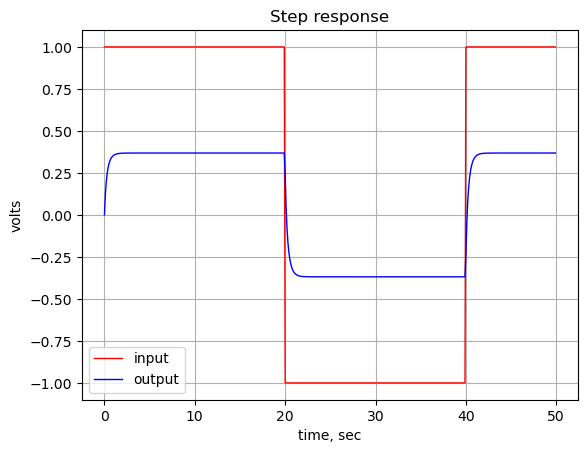

In [235]:
#| echo: false
#| fig-cap: fig cap

# define the time interval and create a square wave step waveform.
t = np.linspace(0, 50, 500, endpoint=False)
sqr_signal = signal.square(2*np.pi*0.025*t, duty=0.5)

# call lsim to generate the response signal
t_step, y_step, x_step = signal.lsim(sys_tf, U=sqr_signal, T=t)

plt.plot(t_step, sqr_signal, 'r', alpha = 1.0, linewidth=1, label='input')
plt.plot(t_step, y_step,'b', linewidth = 1.0, label='output')
plt.title('Step response')
plt.ylabel('volts')
plt.xlabel('time, sec')
plt.grid()
plt.legend(loc='best')
# show plot
plt.show()

# Twin-T-variation 8
This variation is taking too long to solve on my laptop.


![](Twin-T-variation8.png)

In [236]:
example_net_list = '''
* Twin-T-variation8.asc
R1 5 3 1
R2 4 1 1
R3 3 6 1
C1 5 4 1
C2 3 1 1
C3 4 6 1
V1 1 0 1
O1 2 5 2
R4 5 0 1
R5 2 6 1
R6 6 0 1
'''

Making the substitutions: $R_1=R_3=R$, $R_2=2R$, $R_4=5$, $R_5=R_6=2$, $C_1=C_3=C$ and $C_2=C/2$, we get:

# Twin-T-variation 9

- With R4 = resistor - High pass
- with R4 = capacitor - Low Pass
- with R1= Cap & C1=Res - low pass with constant high freq gain
- same but with R4=R - high pass with constant low freq gain
- R4=ind - high pass

![](Twin-T-variation9.png)

In [237]:
example_net_list = '''
* Twin-T-variation9.asc
C5 3 1 1
R2 5 4 1
R3 3 2 1
R5 4 1 1
C2 5 3 1
C3 4 2 1
V1 1 0 1
O1 2 5 2
L4 5 0 1
'''

In [238]:
#| echo: true
report, network_df, df2, A, X, Z = SymMNA.smna(example_net_list)

X = Matrix(X)
Z = Matrix(Z)

NE_sym = Eq(A*X,Z)

var(str(NE_sym.free_symbols).replace('{','').replace('}',''))
nominal_component_value = SymMNA.get_part_values(network_df)

# N is the variation number
U_sym = solve(NE_sym,X)
H_sym = cancel(U_sym[v2]/U_sym[v1],s)

#| echo: false
Markdown('$H(s)={:s}$'.format(latex(H_sym)))

$H(s)=\frac{C_{2} C_{3} C_{5} L_{4} R_{2} R_{3} R_{5} s^{4} + L_{4} s + s^{3} \left(C_{2} C_{5} L_{4} R_{2} R_{3} + C_{2} C_{5} L_{4} R_{3} R_{5}\right) + s^{2} \left(C_{2} L_{4} R_{3} + C_{5} L_{4} R_{3}\right)}{C_{2} C_{3} C_{5} L_{4} R_{2} R_{3} R_{5} s^{4} + R_{2} + R_{5} + s^{3} \left(C_{2} C_{5} L_{4} R_{2} R_{3} + C_{2} C_{5} L_{4} R_{3} R_{5}\right) + s^{2} \left(C_{2} C_{3} R_{2} R_{3} R_{5} + C_{2} L_{4} R_{3} + C_{3} C_{5} R_{2} R_{3} R_{5} + C_{5} L_{4} R_{3}\right) + s \left(C_{2} R_{2} R_{3} + C_{2} R_{3} R_{5} + C_{3} R_{2} R_{5} + C_{5} R_{2} R_{3} + C_{5} R_{3} R_{5} + L_{4}\right)}$

Making the substitutions: $R_1=R_3=R$, $R_2=2R$, $R_4=5$, $R_5=R_6=2$, $C_1=C_3=C$ and $C_2=C/2$, we get:

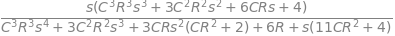

In [239]:
sub_values = {R1:2*R, R2:R/2, R3:R, R4:R, R5:R, L4:1, C5:C, C4:C, C1:C, C2:C/2, C3:C}
H_sym.subs(sub_values).simplify()

In [240]:
#| echo: false
H_sym = H_sym.subs(sub_values).simplify()
Markdown('$H(s)={:s}$'.format(latex(H_sym)))

$H(s)=\frac{s \left(C^{3} R^{3} s^{3} + 3 C^{2} R^{2} s^{2} + 6 C R s + 4\right)}{C^{3} R^{3} s^{4} + 3 C^{2} R^{2} s^{3} + 3 C R s^{2} \left(C R^{2} + 2\right) + 6 R + s \left(11 C R^{2} + 4\right)}$

In [241]:
#| echo: false
H_sym_num, H_sym_denom = fraction(H_sym,s) #returns numerator and denominator

In [242]:
H_sym_num = H_sym_num.expand().collect(s)

In [243]:
H_sym_num

In [244]:
H_sym_denom = H_sym_denom.expand().collect(s)

The numerator polynominal is:

In [245]:
#| echo: false
Markdown('$N(s)={:s}$'.format(latex(H_sym_num)))

$N(s)=C^{3} R^{3} s^{4} + 3 C^{2} R^{2} s^{3} + 6 C R s^{2} + 4 s$

In [246]:
#| echo: false
num_root_sym = solve(H_sym_num,s)
Markdown('${:s}$'.format(latex(num_root_sym)))

$\left[ 0, \  - \frac{1}{C R}, \  \frac{-1 - \sqrt{3} i}{C R}, \  \frac{-1 + \sqrt{3} i}{C R}\right]$

The denominator polynominal is:

In [247]:
#| echo: false
Markdown('$D(s)={:s}$'.format(latex(H_sym_denom)))

$D(s)=C^{3} R^{3} s^{4} + 3 C^{2} R^{2} s^{3} + 6 R + s^{2} \cdot \left(3 C^{2} R^{3} + 6 C R\right) + s \left(11 C R^{2} + 4\right)$

The roots of the denominator polynominal can found with SymPy.

In [248]:
#| echo: false
denom_root_sym = solve(H_sym_denom,s)
Markdown('${:s}$'.format(latex(denom_root_sym)))

$\left[ \begin{cases} - \frac{\sqrt{- 2 \sqrt[3]{\frac{\left(- \frac{9}{16 C^{3} R^{2}} - \frac{147}{256 C^{4} R^{4}}\right) \left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)}{3} - \frac{\left(\frac{13}{2 C^{2} R} - \frac{13}{8 C^{3} R^{3}}\right)^{2}}{8} - \frac{\left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)^{3}}{108}} - \frac{2 \cdot \left(3 C R^{2} + 6\right)}{3 C^{2} R^{2}} + \frac{9}{4 C^{2} R^{2}}}}{2} - \frac{\sqrt{\frac{\frac{13}{C^{2} R} - \frac{13}{4 C^{3} R^{3}}}{\sqrt{- 2 \sqrt[3]{\frac{\left(- \frac{9}{16 C^{3} R^{2}} - \frac{147}{256 C^{4} R^{4}}\right) \left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)}{3} - \frac{\left(\frac{13}{2 C^{2} R} - \frac{13}{8 C^{3} R^{3}}\right)^{2}}{8} - \frac{\left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)^{3}}{108}} - \frac{2 \cdot \left(3 C R^{2} + 6\right)}{3 C^{2} R^{2}} + \frac{9}{4 C^{2} R^{2}}}} + 2 \sqrt[3]{\frac{\left(- \frac{9}{16 C^{3} R^{2}} - \frac{147}{256 C^{4} R^{4}}\right) \left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)}{3} - \frac{\left(\frac{13}{2 C^{2} R} - \frac{13}{8 C^{3} R^{3}}\right)^{2}}{8} - \frac{\left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)^{3}}{108}} - \frac{4 \cdot \left(3 C R^{2} + 6\right)}{3 C^{2} R^{2}} + \frac{9}{2 C^{2} R^{2}}}}{2} - \frac{3}{4 C R} & \text{for}\: \frac{3}{4 C^{2}} + \frac{3}{4 C^{3} R^{2}} = 0 \\- \frac{\sqrt{- \frac{2 \left(- \frac{3}{4 C^{2}} - \frac{3}{4 C^{3} R^{2}}\right)}{3 \sqrt[3]{- \frac{\left(- \frac{9}{16 C^{3} R^{2}} - \frac{147}{256 C^{4} R^{4}}\right) \left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)}{6} + \frac{\left(\frac{13}{2 C^{2} R} - \frac{13}{8 C^{3} R^{3}}\right)^{2}}{16} + \frac{\left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)^{3}}{216} + \sqrt{\frac{\left(- \frac{3}{4 C^{2}} - \frac{3}{4 C^{3} R^{2}}\right)^{3}}{27} + \frac{\left(\frac{\left(- \frac{9}{16 C^{3} R^{2}} - \frac{147}{256 C^{4} R^{4}}\right) \left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)}{3} - \frac{\left(\frac{13}{2 C^{2} R} - \frac{13}{8 C^{3} R^{3}}\right)^{2}}{8} - \frac{\left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)^{3}}{108}\right)^{2}}{4}}}} + 2 \sqrt[3]{- \frac{\left(- \frac{9}{16 C^{3} R^{2}} - \frac{147}{256 C^{4} R^{4}}\right) \left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)}{6} + \frac{\left(\frac{13}{2 C^{2} R} - \frac{13}{8 C^{3} R^{3}}\right)^{2}}{16} + \frac{\left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)^{3}}{216} + \sqrt{\frac{\left(- \frac{3}{4 C^{2}} - \frac{3}{4 C^{3} R^{2}}\right)^{3}}{27} + \frac{\left(\frac{\left(- \frac{9}{16 C^{3} R^{2}} - \frac{147}{256 C^{4} R^{4}}\right) \left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)}{3} - \frac{\left(\frac{13}{2 C^{2} R} - \frac{13}{8 C^{3} R^{3}}\right)^{2}}{8} - \frac{\left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)^{3}}{108}\right)^{2}}{4}}} - \frac{2 \cdot \left(3 C R^{2} + 6\right)}{3 C^{2} R^{2}} + \frac{9}{4 C^{2} R^{2}}}}{2} - \frac{\sqrt{\frac{2 \left(- \frac{3}{4 C^{2}} - \frac{3}{4 C^{3} R^{2}}\right)}{3 \sqrt[3]{- \frac{\left(- \frac{9}{16 C^{3} R^{2}} - \frac{147}{256 C^{4} R^{4}}\right) \left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)}{6} + \frac{\left(\frac{13}{2 C^{2} R} - \frac{13}{8 C^{3} R^{3}}\right)^{2}}{16} + \frac{\left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)^{3}}{216} + \sqrt{\frac{\left(- \frac{3}{4 C^{2}} - \frac{3}{4 C^{3} R^{2}}\right)^{3}}{27} + \frac{\left(\frac{\left(- \frac{9}{16 C^{3} R^{2}} - \frac{147}{256 C^{4} R^{4}}\right) \left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)}{3} - \frac{\left(\frac{13}{2 C^{2} R} - \frac{13}{8 C^{3} R^{3}}\right)^{2}}{8} - \frac{\left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)^{3}}{108}\right)^{2}}{4}}}} + \frac{\frac{13}{C^{2} R} - \frac{13}{4 C^{3} R^{3}}}{\sqrt{- \frac{2 \left(- \frac{3}{4 C^{2}} - \frac{3}{4 C^{3} R^{2}}\right)}{3 \sqrt[3]{- \frac{\left(- \frac{9}{16 C^{3} R^{2}} - \frac{147}{256 C^{4} R^{4}}\right) \left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)}{6} + \frac{\left(\frac{13}{2 C^{2} R} - \frac{13}{8 C^{3} R^{3}}\right)^{2}}{16} + \frac{\left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)^{3}}{216} + \sqrt{\frac{\left(- \frac{3}{4 C^{2}} - \frac{3}{4 C^{3} R^{2}}\right)^{3}}{27} + \frac{\left(\frac{\left(- \frac{9}{16 C^{3} R^{2}} - \frac{147}{256 C^{4} R^{4}}\right) \left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)}{3} - \frac{\left(\frac{13}{2 C^{2} R} - \frac{13}{8 C^{3} R^{3}}\right)^{2}}{8} - \frac{\left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)^{3}}{108}\right)^{2}}{4}}}} + 2 \sqrt[3]{- \frac{\left(- \frac{9}{16 C^{3} R^{2}} - \frac{147}{256 C^{4} R^{4}}\right) \left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)}{6} + \frac{\left(\frac{13}{2 C^{2} R} - \frac{13}{8 C^{3} R^{3}}\right)^{2}}{16} + \frac{\left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)^{3}}{216} + \sqrt{\frac{\left(- \frac{3}{4 C^{2}} - \frac{3}{4 C^{3} R^{2}}\right)^{3}}{27} + \frac{\left(\frac{\left(- \frac{9}{16 C^{3} R^{2}} - \frac{147}{256 C^{4} R^{4}}\right) \left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)}{3} - \frac{\left(\frac{13}{2 C^{2} R} - \frac{13}{8 C^{3} R^{3}}\right)^{2}}{8} - \frac{\left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)^{3}}{108}\right)^{2}}{4}}} - \frac{2 \cdot \left(3 C R^{2} + 6\right)}{3 C^{2} R^{2}} + \frac{9}{4 C^{2} R^{2}}}} - 2 \sqrt[3]{- \frac{\left(- \frac{9}{16 C^{3} R^{2}} - \frac{147}{256 C^{4} R^{4}}\right) \left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)}{6} + \frac{\left(\frac{13}{2 C^{2} R} - \frac{13}{8 C^{3} R^{3}}\right)^{2}}{16} + \frac{\left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)^{3}}{216} + \sqrt{\frac{\left(- \frac{3}{4 C^{2}} - \frac{3}{4 C^{3} R^{2}}\right)^{3}}{27} + \frac{\left(\frac{\left(- \frac{9}{16 C^{3} R^{2}} - \frac{147}{256 C^{4} R^{4}}\right) \left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)}{3} - \frac{\left(\frac{13}{2 C^{2} R} - \frac{13}{8 C^{3} R^{3}}\right)^{2}}{8} - \frac{\left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)^{3}}{108}\right)^{2}}{4}}} - \frac{4 \cdot \left(3 C R^{2} + 6\right)}{3 C^{2} R^{2}} + \frac{9}{2 C^{2} R^{2}}}}{2} - \frac{3}{4 C R} & \text{otherwise} \end{cases}, \  \begin{cases} - \frac{\sqrt{- 2 \sqrt[3]{\frac{\left(- \frac{9}{16 C^{3} R^{2}} - \frac{147}{256 C^{4} R^{4}}\right) \left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)}{3} - \frac{\left(\frac{13}{2 C^{2} R} - \frac{13}{8 C^{3} R^{3}}\right)^{2}}{8} - \frac{\left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)^{3}}{108}} - \frac{2 \cdot \left(3 C R^{2} + 6\right)}{3 C^{2} R^{2}} + \frac{9}{4 C^{2} R^{2}}}}{2} + \frac{\sqrt{\frac{\frac{13}{C^{2} R} - \frac{13}{4 C^{3} R^{3}}}{\sqrt{- 2 \sqrt[3]{\frac{\left(- \frac{9}{16 C^{3} R^{2}} - \frac{147}{256 C^{4} R^{4}}\right) \left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)}{3} - \frac{\left(\frac{13}{2 C^{2} R} - \frac{13}{8 C^{3} R^{3}}\right)^{2}}{8} - \frac{\left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)^{3}}{108}} - \frac{2 \cdot \left(3 C R^{2} + 6\right)}{3 C^{2} R^{2}} + \frac{9}{4 C^{2} R^{2}}}} + 2 \sqrt[3]{\frac{\left(- \frac{9}{16 C^{3} R^{2}} - \frac{147}{256 C^{4} R^{4}}\right) \left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)}{3} - \frac{\left(\frac{13}{2 C^{2} R} - \frac{13}{8 C^{3} R^{3}}\right)^{2}}{8} - \frac{\left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)^{3}}{108}} - \frac{4 \cdot \left(3 C R^{2} + 6\right)}{3 C^{2} R^{2}} + \frac{9}{2 C^{2} R^{2}}}}{2} - \frac{3}{4 C R} & \text{for}\: \frac{3}{4 C^{2}} + \frac{3}{4 C^{3} R^{2}} = 0 \\- \frac{\sqrt{- \frac{2 \left(- \frac{3}{4 C^{2}} - \frac{3}{4 C^{3} R^{2}}\right)}{3 \sqrt[3]{- \frac{\left(- \frac{9}{16 C^{3} R^{2}} - \frac{147}{256 C^{4} R^{4}}\right) \left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)}{6} + \frac{\left(\frac{13}{2 C^{2} R} - \frac{13}{8 C^{3} R^{3}}\right)^{2}}{16} + \frac{\left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)^{3}}{216} + \sqrt{\frac{\left(- \frac{3}{4 C^{2}} - \frac{3}{4 C^{3} R^{2}}\right)^{3}}{27} + \frac{\left(\frac{\left(- \frac{9}{16 C^{3} R^{2}} - \frac{147}{256 C^{4} R^{4}}\right) \left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)}{3} - \frac{\left(\frac{13}{2 C^{2} R} - \frac{13}{8 C^{3} R^{3}}\right)^{2}}{8} - \frac{\left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)^{3}}{108}\right)^{2}}{4}}}} + 2 \sqrt[3]{- \frac{\left(- \frac{9}{16 C^{3} R^{2}} - \frac{147}{256 C^{4} R^{4}}\right) \left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)}{6} + \frac{\left(\frac{13}{2 C^{2} R} - \frac{13}{8 C^{3} R^{3}}\right)^{2}}{16} + \frac{\left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)^{3}}{216} + \sqrt{\frac{\left(- \frac{3}{4 C^{2}} - \frac{3}{4 C^{3} R^{2}}\right)^{3}}{27} + \frac{\left(\frac{\left(- \frac{9}{16 C^{3} R^{2}} - \frac{147}{256 C^{4} R^{4}}\right) \left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)}{3} - \frac{\left(\frac{13}{2 C^{2} R} - \frac{13}{8 C^{3} R^{3}}\right)^{2}}{8} - \frac{\left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)^{3}}{108}\right)^{2}}{4}}} - \frac{2 \cdot \left(3 C R^{2} + 6\right)}{3 C^{2} R^{2}} + \frac{9}{4 C^{2} R^{2}}}}{2} + \frac{\sqrt{\frac{2 \left(- \frac{3}{4 C^{2}} - \frac{3}{4 C^{3} R^{2}}\right)}{3 \sqrt[3]{- \frac{\left(- \frac{9}{16 C^{3} R^{2}} - \frac{147}{256 C^{4} R^{4}}\right) \left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)}{6} + \frac{\left(\frac{13}{2 C^{2} R} - \frac{13}{8 C^{3} R^{3}}\right)^{2}}{16} + \frac{\left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)^{3}}{216} + \sqrt{\frac{\left(- \frac{3}{4 C^{2}} - \frac{3}{4 C^{3} R^{2}}\right)^{3}}{27} + \frac{\left(\frac{\left(- \frac{9}{16 C^{3} R^{2}} - \frac{147}{256 C^{4} R^{4}}\right) \left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)}{3} - \frac{\left(\frac{13}{2 C^{2} R} - \frac{13}{8 C^{3} R^{3}}\right)^{2}}{8} - \frac{\left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)^{3}}{108}\right)^{2}}{4}}}} + \frac{\frac{13}{C^{2} R} - \frac{13}{4 C^{3} R^{3}}}{\sqrt{- \frac{2 \left(- \frac{3}{4 C^{2}} - \frac{3}{4 C^{3} R^{2}}\right)}{3 \sqrt[3]{- \frac{\left(- \frac{9}{16 C^{3} R^{2}} - \frac{147}{256 C^{4} R^{4}}\right) \left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)}{6} + \frac{\left(\frac{13}{2 C^{2} R} - \frac{13}{8 C^{3} R^{3}}\right)^{2}}{16} + \frac{\left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)^{3}}{216} + \sqrt{\frac{\left(- \frac{3}{4 C^{2}} - \frac{3}{4 C^{3} R^{2}}\right)^{3}}{27} + \frac{\left(\frac{\left(- \frac{9}{16 C^{3} R^{2}} - \frac{147}{256 C^{4} R^{4}}\right) \left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)}{3} - \frac{\left(\frac{13}{2 C^{2} R} - \frac{13}{8 C^{3} R^{3}}\right)^{2}}{8} - \frac{\left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)^{3}}{108}\right)^{2}}{4}}}} + 2 \sqrt[3]{- \frac{\left(- \frac{9}{16 C^{3} R^{2}} - \frac{147}{256 C^{4} R^{4}}\right) \left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)}{6} + \frac{\left(\frac{13}{2 C^{2} R} - \frac{13}{8 C^{3} R^{3}}\right)^{2}}{16} + \frac{\left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)^{3}}{216} + \sqrt{\frac{\left(- \frac{3}{4 C^{2}} - \frac{3}{4 C^{3} R^{2}}\right)^{3}}{27} + \frac{\left(\frac{\left(- \frac{9}{16 C^{3} R^{2}} - \frac{147}{256 C^{4} R^{4}}\right) \left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)}{3} - \frac{\left(\frac{13}{2 C^{2} R} - \frac{13}{8 C^{3} R^{3}}\right)^{2}}{8} - \frac{\left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)^{3}}{108}\right)^{2}}{4}}} - \frac{2 \cdot \left(3 C R^{2} + 6\right)}{3 C^{2} R^{2}} + \frac{9}{4 C^{2} R^{2}}}} - 2 \sqrt[3]{- \frac{\left(- \frac{9}{16 C^{3} R^{2}} - \frac{147}{256 C^{4} R^{4}}\right) \left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)}{6} + \frac{\left(\frac{13}{2 C^{2} R} - \frac{13}{8 C^{3} R^{3}}\right)^{2}}{16} + \frac{\left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)^{3}}{216} + \sqrt{\frac{\left(- \frac{3}{4 C^{2}} - \frac{3}{4 C^{3} R^{2}}\right)^{3}}{27} + \frac{\left(\frac{\left(- \frac{9}{16 C^{3} R^{2}} - \frac{147}{256 C^{4} R^{4}}\right) \left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)}{3} - \frac{\left(\frac{13}{2 C^{2} R} - \frac{13}{8 C^{3} R^{3}}\right)^{2}}{8} - \frac{\left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)^{3}}{108}\right)^{2}}{4}}} - \frac{4 \cdot \left(3 C R^{2} + 6\right)}{3 C^{2} R^{2}} + \frac{9}{2 C^{2} R^{2}}}}{2} - \frac{3}{4 C R} & \text{otherwise} \end{cases}, \  \begin{cases} \frac{\sqrt{- 2 \sqrt[3]{\frac{\left(- \frac{9}{16 C^{3} R^{2}} - \frac{147}{256 C^{4} R^{4}}\right) \left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)}{3} - \frac{\left(\frac{13}{2 C^{2} R} - \frac{13}{8 C^{3} R^{3}}\right)^{2}}{8} - \frac{\left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)^{3}}{108}} - \frac{2 \cdot \left(3 C R^{2} + 6\right)}{3 C^{2} R^{2}} + \frac{9}{4 C^{2} R^{2}}}}{2} - \frac{\sqrt{- \frac{\frac{13}{C^{2} R} - \frac{13}{4 C^{3} R^{3}}}{\sqrt{- 2 \sqrt[3]{\frac{\left(- \frac{9}{16 C^{3} R^{2}} - \frac{147}{256 C^{4} R^{4}}\right) \left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)}{3} - \frac{\left(\frac{13}{2 C^{2} R} - \frac{13}{8 C^{3} R^{3}}\right)^{2}}{8} - \frac{\left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)^{3}}{108}} - \frac{2 \cdot \left(3 C R^{2} + 6\right)}{3 C^{2} R^{2}} + \frac{9}{4 C^{2} R^{2}}}} + 2 \sqrt[3]{\frac{\left(- \frac{9}{16 C^{3} R^{2}} - \frac{147}{256 C^{4} R^{4}}\right) \left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)}{3} - \frac{\left(\frac{13}{2 C^{2} R} - \frac{13}{8 C^{3} R^{3}}\right)^{2}}{8} - \frac{\left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)^{3}}{108}} - \frac{4 \cdot \left(3 C R^{2} + 6\right)}{3 C^{2} R^{2}} + \frac{9}{2 C^{2} R^{2}}}}{2} - \frac{3}{4 C R} & \text{for}\: \frac{3}{4 C^{2}} + \frac{3}{4 C^{3} R^{2}} = 0 \\\frac{\sqrt{- \frac{2 \left(- \frac{3}{4 C^{2}} - \frac{3}{4 C^{3} R^{2}}\right)}{3 \sqrt[3]{- \frac{\left(- \frac{9}{16 C^{3} R^{2}} - \frac{147}{256 C^{4} R^{4}}\right) \left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)}{6} + \frac{\left(\frac{13}{2 C^{2} R} - \frac{13}{8 C^{3} R^{3}}\right)^{2}}{16} + \frac{\left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)^{3}}{216} + \sqrt{\frac{\left(- \frac{3}{4 C^{2}} - \frac{3}{4 C^{3} R^{2}}\right)^{3}}{27} + \frac{\left(\frac{\left(- \frac{9}{16 C^{3} R^{2}} - \frac{147}{256 C^{4} R^{4}}\right) \left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)}{3} - \frac{\left(\frac{13}{2 C^{2} R} - \frac{13}{8 C^{3} R^{3}}\right)^{2}}{8} - \frac{\left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)^{3}}{108}\right)^{2}}{4}}}} + 2 \sqrt[3]{- \frac{\left(- \frac{9}{16 C^{3} R^{2}} - \frac{147}{256 C^{4} R^{4}}\right) \left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)}{6} + \frac{\left(\frac{13}{2 C^{2} R} - \frac{13}{8 C^{3} R^{3}}\right)^{2}}{16} + \frac{\left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)^{3}}{216} + \sqrt{\frac{\left(- \frac{3}{4 C^{2}} - \frac{3}{4 C^{3} R^{2}}\right)^{3}}{27} + \frac{\left(\frac{\left(- \frac{9}{16 C^{3} R^{2}} - \frac{147}{256 C^{4} R^{4}}\right) \left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)}{3} - \frac{\left(\frac{13}{2 C^{2} R} - \frac{13}{8 C^{3} R^{3}}\right)^{2}}{8} - \frac{\left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)^{3}}{108}\right)^{2}}{4}}} - \frac{2 \cdot \left(3 C R^{2} + 6\right)}{3 C^{2} R^{2}} + \frac{9}{4 C^{2} R^{2}}}}{2} - \frac{\sqrt{\frac{2 \left(- \frac{3}{4 C^{2}} - \frac{3}{4 C^{3} R^{2}}\right)}{3 \sqrt[3]{- \frac{\left(- \frac{9}{16 C^{3} R^{2}} - \frac{147}{256 C^{4} R^{4}}\right) \left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)}{6} + \frac{\left(\frac{13}{2 C^{2} R} - \frac{13}{8 C^{3} R^{3}}\right)^{2}}{16} + \frac{\left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)^{3}}{216} + \sqrt{\frac{\left(- \frac{3}{4 C^{2}} - \frac{3}{4 C^{3} R^{2}}\right)^{3}}{27} + \frac{\left(\frac{\left(- \frac{9}{16 C^{3} R^{2}} - \frac{147}{256 C^{4} R^{4}}\right) \left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)}{3} - \frac{\left(\frac{13}{2 C^{2} R} - \frac{13}{8 C^{3} R^{3}}\right)^{2}}{8} - \frac{\left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)^{3}}{108}\right)^{2}}{4}}}} - \frac{\frac{13}{C^{2} R} - \frac{13}{4 C^{3} R^{3}}}{\sqrt{- \frac{2 \left(- \frac{3}{4 C^{2}} - \frac{3}{4 C^{3} R^{2}}\right)}{3 \sqrt[3]{- \frac{\left(- \frac{9}{16 C^{3} R^{2}} - \frac{147}{256 C^{4} R^{4}}\right) \left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)}{6} + \frac{\left(\frac{13}{2 C^{2} R} - \frac{13}{8 C^{3} R^{3}}\right)^{2}}{16} + \frac{\left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)^{3}}{216} + \sqrt{\frac{\left(- \frac{3}{4 C^{2}} - \frac{3}{4 C^{3} R^{2}}\right)^{3}}{27} + \frac{\left(\frac{\left(- \frac{9}{16 C^{3} R^{2}} - \frac{147}{256 C^{4} R^{4}}\right) \left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)}{3} - \frac{\left(\frac{13}{2 C^{2} R} - \frac{13}{8 C^{3} R^{3}}\right)^{2}}{8} - \frac{\left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)^{3}}{108}\right)^{2}}{4}}}} + 2 \sqrt[3]{- \frac{\left(- \frac{9}{16 C^{3} R^{2}} - \frac{147}{256 C^{4} R^{4}}\right) \left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)}{6} + \frac{\left(\frac{13}{2 C^{2} R} - \frac{13}{8 C^{3} R^{3}}\right)^{2}}{16} + \frac{\left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)^{3}}{216} + \sqrt{\frac{\left(- \frac{3}{4 C^{2}} - \frac{3}{4 C^{3} R^{2}}\right)^{3}}{27} + \frac{\left(\frac{\left(- \frac{9}{16 C^{3} R^{2}} - \frac{147}{256 C^{4} R^{4}}\right) \left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)}{3} - \frac{\left(\frac{13}{2 C^{2} R} - \frac{13}{8 C^{3} R^{3}}\right)^{2}}{8} - \frac{\left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)^{3}}{108}\right)^{2}}{4}}} - \frac{2 \cdot \left(3 C R^{2} + 6\right)}{3 C^{2} R^{2}} + \frac{9}{4 C^{2} R^{2}}}} - 2 \sqrt[3]{- \frac{\left(- \frac{9}{16 C^{3} R^{2}} - \frac{147}{256 C^{4} R^{4}}\right) \left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)}{6} + \frac{\left(\frac{13}{2 C^{2} R} - \frac{13}{8 C^{3} R^{3}}\right)^{2}}{16} + \frac{\left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)^{3}}{216} + \sqrt{\frac{\left(- \frac{3}{4 C^{2}} - \frac{3}{4 C^{3} R^{2}}\right)^{3}}{27} + \frac{\left(\frac{\left(- \frac{9}{16 C^{3} R^{2}} - \frac{147}{256 C^{4} R^{4}}\right) \left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)}{3} - \frac{\left(\frac{13}{2 C^{2} R} - \frac{13}{8 C^{3} R^{3}}\right)^{2}}{8} - \frac{\left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)^{3}}{108}\right)^{2}}{4}}} - \frac{4 \cdot \left(3 C R^{2} + 6\right)}{3 C^{2} R^{2}} + \frac{9}{2 C^{2} R^{2}}}}{2} - \frac{3}{4 C R} & \text{otherwise} \end{cases}, \  \begin{cases} \frac{\sqrt{- 2 \sqrt[3]{\frac{\left(- \frac{9}{16 C^{3} R^{2}} - \frac{147}{256 C^{4} R^{4}}\right) \left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)}{3} - \frac{\left(\frac{13}{2 C^{2} R} - \frac{13}{8 C^{3} R^{3}}\right)^{2}}{8} - \frac{\left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)^{3}}{108}} - \frac{2 \cdot \left(3 C R^{2} + 6\right)}{3 C^{2} R^{2}} + \frac{9}{4 C^{2} R^{2}}}}{2} + \frac{\sqrt{- \frac{\frac{13}{C^{2} R} - \frac{13}{4 C^{3} R^{3}}}{\sqrt{- 2 \sqrt[3]{\frac{\left(- \frac{9}{16 C^{3} R^{2}} - \frac{147}{256 C^{4} R^{4}}\right) \left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)}{3} - \frac{\left(\frac{13}{2 C^{2} R} - \frac{13}{8 C^{3} R^{3}}\right)^{2}}{8} - \frac{\left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)^{3}}{108}} - \frac{2 \cdot \left(3 C R^{2} + 6\right)}{3 C^{2} R^{2}} + \frac{9}{4 C^{2} R^{2}}}} + 2 \sqrt[3]{\frac{\left(- \frac{9}{16 C^{3} R^{2}} - \frac{147}{256 C^{4} R^{4}}\right) \left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)}{3} - \frac{\left(\frac{13}{2 C^{2} R} - \frac{13}{8 C^{3} R^{3}}\right)^{2}}{8} - \frac{\left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)^{3}}{108}} - \frac{4 \cdot \left(3 C R^{2} + 6\right)}{3 C^{2} R^{2}} + \frac{9}{2 C^{2} R^{2}}}}{2} - \frac{3}{4 C R} & \text{for}\: \frac{3}{4 C^{2}} + \frac{3}{4 C^{3} R^{2}} = 0 \\\frac{\sqrt{- \frac{2 \left(- \frac{3}{4 C^{2}} - \frac{3}{4 C^{3} R^{2}}\right)}{3 \sqrt[3]{- \frac{\left(- \frac{9}{16 C^{3} R^{2}} - \frac{147}{256 C^{4} R^{4}}\right) \left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)}{6} + \frac{\left(\frac{13}{2 C^{2} R} - \frac{13}{8 C^{3} R^{3}}\right)^{2}}{16} + \frac{\left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)^{3}}{216} + \sqrt{\frac{\left(- \frac{3}{4 C^{2}} - \frac{3}{4 C^{3} R^{2}}\right)^{3}}{27} + \frac{\left(\frac{\left(- \frac{9}{16 C^{3} R^{2}} - \frac{147}{256 C^{4} R^{4}}\right) \left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)}{3} - \frac{\left(\frac{13}{2 C^{2} R} - \frac{13}{8 C^{3} R^{3}}\right)^{2}}{8} - \frac{\left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)^{3}}{108}\right)^{2}}{4}}}} + 2 \sqrt[3]{- \frac{\left(- \frac{9}{16 C^{3} R^{2}} - \frac{147}{256 C^{4} R^{4}}\right) \left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)}{6} + \frac{\left(\frac{13}{2 C^{2} R} - \frac{13}{8 C^{3} R^{3}}\right)^{2}}{16} + \frac{\left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)^{3}}{216} + \sqrt{\frac{\left(- \frac{3}{4 C^{2}} - \frac{3}{4 C^{3} R^{2}}\right)^{3}}{27} + \frac{\left(\frac{\left(- \frac{9}{16 C^{3} R^{2}} - \frac{147}{256 C^{4} R^{4}}\right) \left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)}{3} - \frac{\left(\frac{13}{2 C^{2} R} - \frac{13}{8 C^{3} R^{3}}\right)^{2}}{8} - \frac{\left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)^{3}}{108}\right)^{2}}{4}}} - \frac{2 \cdot \left(3 C R^{2} + 6\right)}{3 C^{2} R^{2}} + \frac{9}{4 C^{2} R^{2}}}}{2} + \frac{\sqrt{\frac{2 \left(- \frac{3}{4 C^{2}} - \frac{3}{4 C^{3} R^{2}}\right)}{3 \sqrt[3]{- \frac{\left(- \frac{9}{16 C^{3} R^{2}} - \frac{147}{256 C^{4} R^{4}}\right) \left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)}{6} + \frac{\left(\frac{13}{2 C^{2} R} - \frac{13}{8 C^{3} R^{3}}\right)^{2}}{16} + \frac{\left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)^{3}}{216} + \sqrt{\frac{\left(- \frac{3}{4 C^{2}} - \frac{3}{4 C^{3} R^{2}}\right)^{3}}{27} + \frac{\left(\frac{\left(- \frac{9}{16 C^{3} R^{2}} - \frac{147}{256 C^{4} R^{4}}\right) \left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)}{3} - \frac{\left(\frac{13}{2 C^{2} R} - \frac{13}{8 C^{3} R^{3}}\right)^{2}}{8} - \frac{\left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)^{3}}{108}\right)^{2}}{4}}}} - \frac{\frac{13}{C^{2} R} - \frac{13}{4 C^{3} R^{3}}}{\sqrt{- \frac{2 \left(- \frac{3}{4 C^{2}} - \frac{3}{4 C^{3} R^{2}}\right)}{3 \sqrt[3]{- \frac{\left(- \frac{9}{16 C^{3} R^{2}} - \frac{147}{256 C^{4} R^{4}}\right) \left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)}{6} + \frac{\left(\frac{13}{2 C^{2} R} - \frac{13}{8 C^{3} R^{3}}\right)^{2}}{16} + \frac{\left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)^{3}}{216} + \sqrt{\frac{\left(- \frac{3}{4 C^{2}} - \frac{3}{4 C^{3} R^{2}}\right)^{3}}{27} + \frac{\left(\frac{\left(- \frac{9}{16 C^{3} R^{2}} - \frac{147}{256 C^{4} R^{4}}\right) \left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)}{3} - \frac{\left(\frac{13}{2 C^{2} R} - \frac{13}{8 C^{3} R^{3}}\right)^{2}}{8} - \frac{\left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)^{3}}{108}\right)^{2}}{4}}}} + 2 \sqrt[3]{- \frac{\left(- \frac{9}{16 C^{3} R^{2}} - \frac{147}{256 C^{4} R^{4}}\right) \left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)}{6} + \frac{\left(\frac{13}{2 C^{2} R} - \frac{13}{8 C^{3} R^{3}}\right)^{2}}{16} + \frac{\left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)^{3}}{216} + \sqrt{\frac{\left(- \frac{3}{4 C^{2}} - \frac{3}{4 C^{3} R^{2}}\right)^{3}}{27} + \frac{\left(\frac{\left(- \frac{9}{16 C^{3} R^{2}} - \frac{147}{256 C^{4} R^{4}}\right) \left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)}{3} - \frac{\left(\frac{13}{2 C^{2} R} - \frac{13}{8 C^{3} R^{3}}\right)^{2}}{8} - \frac{\left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)^{3}}{108}\right)^{2}}{4}}} - \frac{2 \cdot \left(3 C R^{2} + 6\right)}{3 C^{2} R^{2}} + \frac{9}{4 C^{2} R^{2}}}} - 2 \sqrt[3]{- \frac{\left(- \frac{9}{16 C^{3} R^{2}} - \frac{147}{256 C^{4} R^{4}}\right) \left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)}{6} + \frac{\left(\frac{13}{2 C^{2} R} - \frac{13}{8 C^{3} R^{3}}\right)^{2}}{16} + \frac{\left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)^{3}}{216} + \sqrt{\frac{\left(- \frac{3}{4 C^{2}} - \frac{3}{4 C^{3} R^{2}}\right)^{3}}{27} + \frac{\left(\frac{\left(- \frac{9}{16 C^{3} R^{2}} - \frac{147}{256 C^{4} R^{4}}\right) \left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)}{3} - \frac{\left(\frac{13}{2 C^{2} R} - \frac{13}{8 C^{3} R^{3}}\right)^{2}}{8} - \frac{\left(\frac{3 C R^{2} + 6}{C^{2} R^{2}} - \frac{27}{8 C^{2} R^{2}}\right)^{3}}{108}\right)^{2}}{4}}} - \frac{4 \cdot \left(3 C R^{2} + 6\right)}{3 C^{2} R^{2}} + \frac{9}{2 C^{2} R^{2}}}}{2} - \frac{3}{4 C R} & \text{otherwise} \end{cases}\right]$

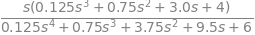

In [249]:
sub_values = {R:1, C:1/2, C4:1}
H_sym.subs(sub_values)

In [250]:
#| echo: false
H_num, H_denom = fraction(H_sym.subs(sub_values)) #returns numerator and denominator

# convert symbolic to numpy polynomial
a = np.array(Poly(H_num, s).all_coeffs(), dtype=float)
b = np.array(Poly(H_denom, s).all_coeffs(), dtype=float)
sys_tf = signal.TransferFunction(a,b)

The poles and zeros of the transfer function are plotted below:

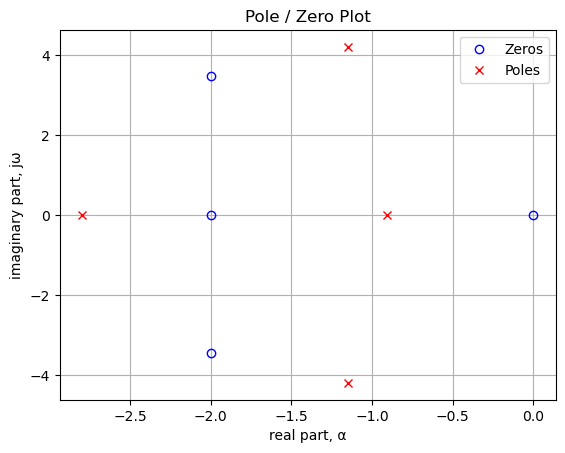

In [251]:
#| echo: false
#| fig-cap: fig cap
sys_zeros = np.roots(sys_tf.num)
sys_poles = np.roots(sys_tf.den)

plt.plot(np.real(sys_zeros), np.imag(sys_zeros), 'ob', markerfacecolor='none')
plt.plot(np.real(sys_poles), np.imag(sys_poles), 'xr')
plt.legend(['Zeros', 'Poles'], loc=0)
plt.title('Pole / Zero Plot')
plt.xlabel('real part, \u03B1')
plt.ylabel('imaginary part, j\u03C9')
plt.grid()
plt.show()

The units of the poles and zeros are in radian frequency and are tabulated below.

In [252]:
#| echo: false
#| tbl-cap: table of poles and zeros

table_header = ['Zeros, rad/s', 'Poles, rad/s']
num_table_rows = max(len(sys_zeros),len(sys_poles))
table_row = []

for i in range(num_table_rows):
    if i < len(sys_zeros):
        z = '{:.2f}'.format(sys_zeros[i])
    else:
        z = ''
    if i < len(sys_poles):
        p = '{:.2f}'.format(sys_poles[i])
    else:
        p = ''
    table_row.append([z,p])

print(tabulate(table_row, headers=table_header,colalign = ('left','left'),tablefmt="simple"))

Zeros, rad/s    Poles, rad/s
--------------  --------------
-2.00+3.46j     -1.15+4.20j
-2.00-3.46j     -1.15-4.20j
-2.00+0.00j     -2.80+0.00j
0.00+0.00j      -0.91+0.00j


The values of the poles network are the same a chosen above, thus validating the solution.

The magnitude and phase of the filter's transfer function is plotted below.

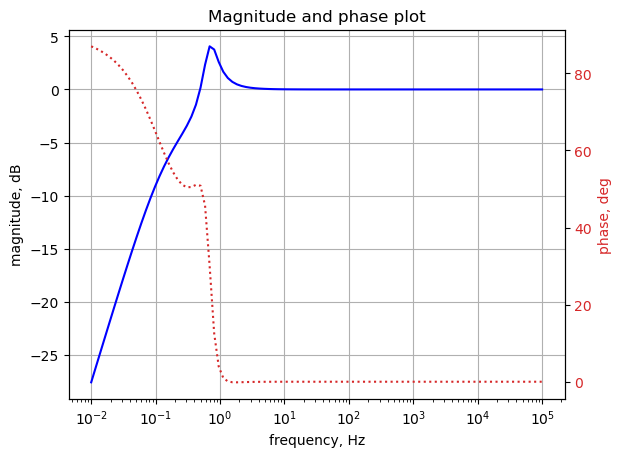

In [253]:
#| echo: false
#| fig-cap: fig cap

x = np.logspace(-2, 5, 100, endpoint=True)*2*np.pi
w, mag, phase = signal.bode(sys_tf, w=x) # returns: rad/s, mag in dB, phase in deg

fig, ax1 = plt.subplots()
ax1.set_ylabel('magnitude, dB')
ax1.set_xlabel('frequency, Hz')

plt.semilogx(w/(2*np.pi), mag,'-b')    # magnitude plot
#ax1.set_ylim(-1,1)
ax1.tick_params(axis='y')
plt.grid()

# instantiate a second y-axes that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:red'

plt.semilogx(w/(2*np.pi), phase,':',color='tab:red')  # phase plot

ax2.set_ylabel('phase, deg',color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Magnitude and phase plot')
plt.show()

The step response is plotted below.

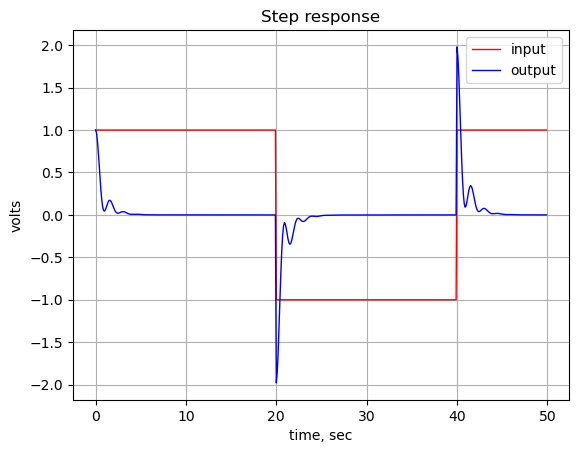

In [254]:
#| echo: false
#| fig-cap: fig cap

# define the time interval and create a square wave step waveform.
t = np.linspace(0, 50, 500, endpoint=False)
sqr_signal = signal.square(2*np.pi*0.025*t, duty=0.5)

# call lsim to generate the response signal
t_step, y_step, x_step = signal.lsim(sys_tf, U=sqr_signal, T=t)

plt.plot(t_step, sqr_signal, 'r', alpha = 1.0, linewidth=1, label='input')
plt.plot(t_step, y_step,'b', linewidth = 1.0, label='output')
plt.title('Step response')
plt.ylabel('volts')
plt.xlabel('time, sec')
plt.grid()
plt.legend(loc='best')
# show plot
plt.show()

# Twin-T-variation 10


![](Twin-T-variation10.png)

In [255]:
example_net_list = '''
* Twin-T-variation10.asc
R1 3 1 1
R2 4 5 1
R3 5 0 1
C1 5 1 1
C2 4 3 1
C3 3 0 1
V1 1 0 1
O1 6 0 2
R4 6 4 1
R5 6 1 1
R6 2 6 1
'''

In [256]:
#| echo: true
report, network_df, df2, A, X, Z = SymMNA.smna(example_net_list)

X = Matrix(X)
Z = Matrix(Z)

NE_sym = Eq(A*X,Z)

var(str(NE_sym.free_symbols).replace('{','').replace('}',''))
nominal_component_value = SymMNA.get_part_values(network_df)

# N is the variation number
U_sym = solve(NE_sym,X)
H_sym = cancel(U_sym[v2]/U_sym[v1],s)

#| echo: false
Markdown('$H(s)={:s}$'.format(latex(H_sym)))

$H(s)=\frac{- C_{1} C_{2} C_{3} R_{1} R_{2} R_{3} R_{4} R_{6} s^{3} - R_{2} R_{6} - R_{3} R_{6} - R_{4} R_{6} + s^{2} \left(- C_{1} C_{2} R_{1} R_{2} R_{3} R_{6} - C_{1} C_{2} R_{1} R_{3} R_{4} R_{6} - C_{1} C_{2} R_{1} R_{3} R_{5} R_{6} - C_{1} C_{2} R_{2} R_{3} R_{4} R_{6} - C_{1} C_{2} R_{2} R_{3} R_{5} R_{6} - C_{1} C_{3} R_{1} R_{2} R_{3} R_{6} - C_{1} C_{3} R_{1} R_{3} R_{4} R_{6} - C_{1} C_{3} R_{1} R_{3} R_{5} R_{6} - C_{2} C_{3} R_{1} R_{2} R_{4} R_{6} - C_{2} C_{3} R_{1} R_{3} R_{4} R_{6}\right) + s \left(- C_{1} R_{2} R_{3} R_{6} - C_{1} R_{3} R_{4} R_{6} - C_{1} R_{3} R_{5} R_{6} - C_{2} R_{1} R_{2} R_{6} - C_{2} R_{1} R_{3} R_{6} - C_{2} R_{1} R_{4} R_{6} - C_{2} R_{2} R_{4} R_{6} - C_{2} R_{2} R_{5} R_{6} - C_{2} R_{3} R_{4} R_{6} - C_{2} R_{3} R_{5} R_{6} - C_{3} R_{1} R_{2} R_{6} - C_{3} R_{1} R_{3} R_{6} - C_{3} R_{1} R_{4} R_{6}\right)}{C_{1} C_{2} C_{3} R_{1} R_{2} R_{3} R_{4} R_{5} s^{3} + R_{2} R_{5} + R_{3} R_{5} + R_{4} R_{5} + s^{2} \left(C_{1} C_{2} R_{1} R_{2} R_{3} R_{5} + C_{1} C_{2} R_{1} R_{3} R_{4} R_{5} + C_{1} C_{2} R_{2} R_{3} R_{4} R_{5} + C_{1} C_{3} R_{1} R_{2} R_{3} R_{5} + C_{1} C_{3} R_{1} R_{3} R_{4} R_{5} + C_{2} C_{3} R_{1} R_{2} R_{4} R_{5} + C_{2} C_{3} R_{1} R_{3} R_{4} R_{5}\right) + s \left(C_{1} R_{2} R_{3} R_{5} + C_{1} R_{3} R_{4} R_{5} + C_{2} R_{1} R_{2} R_{5} + C_{2} R_{1} R_{3} R_{5} + C_{2} R_{1} R_{4} R_{5} + C_{2} R_{2} R_{4} R_{5} + C_{2} R_{3} R_{4} R_{5} + C_{3} R_{1} R_{2} R_{5} + C_{3} R_{1} R_{3} R_{5} + C_{3} R_{1} R_{4} R_{5}\right)}$

Making the substitutions: $R_1=R_3=R$, $R_2=2R$, $R_4=5$, $R_5=R_6=2$, $C_1=C_3=C$ and $C_2=C/2$, we get:

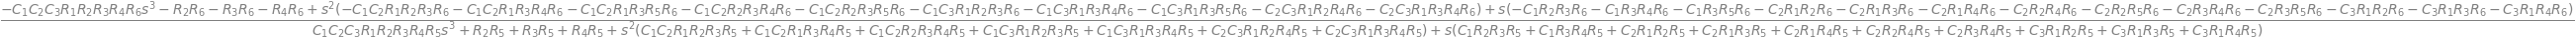

In [257]:
H_sym

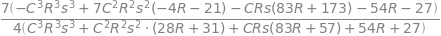

In [258]:
sub_values = {R1:R, R2:R, R3:R, R4:1, R5:4, R6:7, C1:C, C2:C/27, C3:C}
H_sym.subs(sub_values).simplify()

In [259]:
#| echo: false
H_sym1 = H_sym.subs(sub_values).simplify()
Markdown('$H(s)={:s}$'.format(latex(H_sym1)))

$H(s)=\frac{7 \left(- C^{3} R^{3} s^{3} + 7 C^{2} R^{2} s^{2} \left(- 4 R - 21\right) - C R s \left(83 R + 173\right) - 54 R - 27\right)}{4 \left(C^{3} R^{3} s^{3} + C^{2} R^{2} s^{2} \cdot \left(28 R + 31\right) + C R s \left(83 R + 57\right) + 54 R + 27\right)}$

In [260]:
#| echo: false
H_sym_num, H_sym_denom = fraction(H_sym1,s) #returns numerator and denominator

In [261]:
H_sym_num = H_sym_num.expand().collect(s)

In [262]:
H_sym_num

In [263]:
H_sym_denom = H_sym_denom.expand().collect(s)

The numerator polynominal is:

In [264]:
#| echo: false
Markdown('$N(s)={:s}$'.format(latex(H_sym_num)))

$N(s)=- 7 C^{3} R^{3} s^{3} - 378 R + s^{2} \left(- 196 C^{2} R^{3} - 1029 C^{2} R^{2}\right) + s \left(- 581 C R^{2} - 1211 C R\right) - 189$

In [265]:
#| echo: false
num_root_sym = solve(H_sym_num,s)
Markdown('${:s}$'.format(latex(num_root_sym)))

$\left[ - \frac{\frac{\left(28 R + 147\right)^{2}}{C^{2} R^{2}} - \frac{3 \cdot \left(83 R + 173\right)}{C^{2} R^{2}}}{3 \sqrt[3]{\frac{\sqrt{- 4 \left(\frac{\left(28 R + 147\right)^{2}}{C^{2} R^{2}} - \frac{3 \cdot \left(83 R + 173\right)}{C^{2} R^{2}}\right)^{3} + \left(\frac{2 \left(28 R + 147\right)^{3}}{C^{3} R^{3}} - \frac{9 \cdot \left(28 R + 147\right) \left(83 R + 173\right)}{C^{3} R^{3}} + \frac{27 \cdot \left(54 R + 27\right)}{C^{3} R^{3}}\right)^{2}}}{2} + \frac{\left(28 R + 147\right)^{3}}{C^{3} R^{3}} - \frac{9 \cdot \left(28 R + 147\right) \left(83 R + 173\right)}{2 C^{3} R^{3}} + \frac{27 \cdot \left(54 R + 27\right)}{2 C^{3} R^{3}}}} - \frac{\sqrt[3]{\frac{\sqrt{- 4 \left(\frac{\left(28 R + 147\right)^{2}}{C^{2} R^{2}} - \frac{3 \cdot \left(83 R + 173\right)}{C^{2} R^{2}}\right)^{3} + \left(\frac{2 \left(28 R + 147\right)^{3}}{C^{3} R^{3}} - \frac{9 \cdot \left(28 R + 147\right) \left(83 R + 173\right)}{C^{3} R^{3}} + \frac{27 \cdot \left(54 R + 27\right)}{C^{3} R^{3}}\right)^{2}}}{2} + \frac{\left(28 R + 147\right)^{3}}{C^{3} R^{3}} - \frac{9 \cdot \left(28 R + 147\right) \left(83 R + 173\right)}{2 C^{3} R^{3}} + \frac{27 \cdot \left(54 R + 27\right)}{2 C^{3} R^{3}}}}{3} - \frac{28 R + 147}{3 C R}, \  - \frac{\frac{\left(28 R + 147\right)^{2}}{C^{2} R^{2}} - \frac{3 \cdot \left(83 R + 173\right)}{C^{2} R^{2}}}{3 \left(- \frac{1}{2} - \frac{\sqrt{3} i}{2}\right) \sqrt[3]{\frac{\sqrt{- 4 \left(\frac{\left(28 R + 147\right)^{2}}{C^{2} R^{2}} - \frac{3 \cdot \left(83 R + 173\right)}{C^{2} R^{2}}\right)^{3} + \left(\frac{2 \left(28 R + 147\right)^{3}}{C^{3} R^{3}} - \frac{9 \cdot \left(28 R + 147\right) \left(83 R + 173\right)}{C^{3} R^{3}} + \frac{27 \cdot \left(54 R + 27\right)}{C^{3} R^{3}}\right)^{2}}}{2} + \frac{\left(28 R + 147\right)^{3}}{C^{3} R^{3}} - \frac{9 \cdot \left(28 R + 147\right) \left(83 R + 173\right)}{2 C^{3} R^{3}} + \frac{27 \cdot \left(54 R + 27\right)}{2 C^{3} R^{3}}}} - \frac{\left(- \frac{1}{2} - \frac{\sqrt{3} i}{2}\right) \sqrt[3]{\frac{\sqrt{- 4 \left(\frac{\left(28 R + 147\right)^{2}}{C^{2} R^{2}} - \frac{3 \cdot \left(83 R + 173\right)}{C^{2} R^{2}}\right)^{3} + \left(\frac{2 \left(28 R + 147\right)^{3}}{C^{3} R^{3}} - \frac{9 \cdot \left(28 R + 147\right) \left(83 R + 173\right)}{C^{3} R^{3}} + \frac{27 \cdot \left(54 R + 27\right)}{C^{3} R^{3}}\right)^{2}}}{2} + \frac{\left(28 R + 147\right)^{3}}{C^{3} R^{3}} - \frac{9 \cdot \left(28 R + 147\right) \left(83 R + 173\right)}{2 C^{3} R^{3}} + \frac{27 \cdot \left(54 R + 27\right)}{2 C^{3} R^{3}}}}{3} - \frac{28 R + 147}{3 C R}, \  - \frac{\frac{\left(28 R + 147\right)^{2}}{C^{2} R^{2}} - \frac{3 \cdot \left(83 R + 173\right)}{C^{2} R^{2}}}{3 \left(- \frac{1}{2} + \frac{\sqrt{3} i}{2}\right) \sqrt[3]{\frac{\sqrt{- 4 \left(\frac{\left(28 R + 147\right)^{2}}{C^{2} R^{2}} - \frac{3 \cdot \left(83 R + 173\right)}{C^{2} R^{2}}\right)^{3} + \left(\frac{2 \left(28 R + 147\right)^{3}}{C^{3} R^{3}} - \frac{9 \cdot \left(28 R + 147\right) \left(83 R + 173\right)}{C^{3} R^{3}} + \frac{27 \cdot \left(54 R + 27\right)}{C^{3} R^{3}}\right)^{2}}}{2} + \frac{\left(28 R + 147\right)^{3}}{C^{3} R^{3}} - \frac{9 \cdot \left(28 R + 147\right) \left(83 R + 173\right)}{2 C^{3} R^{3}} + \frac{27 \cdot \left(54 R + 27\right)}{2 C^{3} R^{3}}}} - \frac{\left(- \frac{1}{2} + \frac{\sqrt{3} i}{2}\right) \sqrt[3]{\frac{\sqrt{- 4 \left(\frac{\left(28 R + 147\right)^{2}}{C^{2} R^{2}} - \frac{3 \cdot \left(83 R + 173\right)}{C^{2} R^{2}}\right)^{3} + \left(\frac{2 \left(28 R + 147\right)^{3}}{C^{3} R^{3}} - \frac{9 \cdot \left(28 R + 147\right) \left(83 R + 173\right)}{C^{3} R^{3}} + \frac{27 \cdot \left(54 R + 27\right)}{C^{3} R^{3}}\right)^{2}}}{2} + \frac{\left(28 R + 147\right)^{3}}{C^{3} R^{3}} - \frac{9 \cdot \left(28 R + 147\right) \left(83 R + 173\right)}{2 C^{3} R^{3}} + \frac{27 \cdot \left(54 R + 27\right)}{2 C^{3} R^{3}}}}{3} - \frac{28 R + 147}{3 C R}\right]$

The denominator polynominal is:

In [266]:
#| echo: false
Markdown('$D(s)={:s}$'.format(latex(H_sym_denom)))

$D(s)=4 C^{3} R^{3} s^{3} + 216 R + s^{2} \cdot \left(112 C^{2} R^{3} + 124 C^{2} R^{2}\right) + s \left(332 C R^{2} + 228 C R\right) + 108$

The roots of the denominator polynominal can found with SymPy.

In [267]:
#| echo: false
denom_root_sym = solve(H_sym_denom,s)
Markdown('${:s}$'.format(latex(denom_root_sym)))

$\left[ - \frac{\frac{\left(28 R + 31\right)^{2}}{C^{2} R^{2}} - \frac{3 \cdot \left(83 R + 57\right)}{C^{2} R^{2}}}{3 \sqrt[3]{\frac{\sqrt{- 4 \left(\frac{\left(28 R + 31\right)^{2}}{C^{2} R^{2}} - \frac{3 \cdot \left(83 R + 57\right)}{C^{2} R^{2}}\right)^{3} + \left(\frac{2 \left(28 R + 31\right)^{3}}{C^{3} R^{3}} - \frac{9 \cdot \left(28 R + 31\right) \left(83 R + 57\right)}{C^{3} R^{3}} + \frac{27 \cdot \left(54 R + 27\right)}{C^{3} R^{3}}\right)^{2}}}{2} + \frac{\left(28 R + 31\right)^{3}}{C^{3} R^{3}} - \frac{9 \cdot \left(28 R + 31\right) \left(83 R + 57\right)}{2 C^{3} R^{3}} + \frac{27 \cdot \left(54 R + 27\right)}{2 C^{3} R^{3}}}} - \frac{\sqrt[3]{\frac{\sqrt{- 4 \left(\frac{\left(28 R + 31\right)^{2}}{C^{2} R^{2}} - \frac{3 \cdot \left(83 R + 57\right)}{C^{2} R^{2}}\right)^{3} + \left(\frac{2 \left(28 R + 31\right)^{3}}{C^{3} R^{3}} - \frac{9 \cdot \left(28 R + 31\right) \left(83 R + 57\right)}{C^{3} R^{3}} + \frac{27 \cdot \left(54 R + 27\right)}{C^{3} R^{3}}\right)^{2}}}{2} + \frac{\left(28 R + 31\right)^{3}}{C^{3} R^{3}} - \frac{9 \cdot \left(28 R + 31\right) \left(83 R + 57\right)}{2 C^{3} R^{3}} + \frac{27 \cdot \left(54 R + 27\right)}{2 C^{3} R^{3}}}}{3} - \frac{28 R + 31}{3 C R}, \  - \frac{\frac{\left(28 R + 31\right)^{2}}{C^{2} R^{2}} - \frac{3 \cdot \left(83 R + 57\right)}{C^{2} R^{2}}}{3 \left(- \frac{1}{2} - \frac{\sqrt{3} i}{2}\right) \sqrt[3]{\frac{\sqrt{- 4 \left(\frac{\left(28 R + 31\right)^{2}}{C^{2} R^{2}} - \frac{3 \cdot \left(83 R + 57\right)}{C^{2} R^{2}}\right)^{3} + \left(\frac{2 \left(28 R + 31\right)^{3}}{C^{3} R^{3}} - \frac{9 \cdot \left(28 R + 31\right) \left(83 R + 57\right)}{C^{3} R^{3}} + \frac{27 \cdot \left(54 R + 27\right)}{C^{3} R^{3}}\right)^{2}}}{2} + \frac{\left(28 R + 31\right)^{3}}{C^{3} R^{3}} - \frac{9 \cdot \left(28 R + 31\right) \left(83 R + 57\right)}{2 C^{3} R^{3}} + \frac{27 \cdot \left(54 R + 27\right)}{2 C^{3} R^{3}}}} - \frac{\left(- \frac{1}{2} - \frac{\sqrt{3} i}{2}\right) \sqrt[3]{\frac{\sqrt{- 4 \left(\frac{\left(28 R + 31\right)^{2}}{C^{2} R^{2}} - \frac{3 \cdot \left(83 R + 57\right)}{C^{2} R^{2}}\right)^{3} + \left(\frac{2 \left(28 R + 31\right)^{3}}{C^{3} R^{3}} - \frac{9 \cdot \left(28 R + 31\right) \left(83 R + 57\right)}{C^{3} R^{3}} + \frac{27 \cdot \left(54 R + 27\right)}{C^{3} R^{3}}\right)^{2}}}{2} + \frac{\left(28 R + 31\right)^{3}}{C^{3} R^{3}} - \frac{9 \cdot \left(28 R + 31\right) \left(83 R + 57\right)}{2 C^{3} R^{3}} + \frac{27 \cdot \left(54 R + 27\right)}{2 C^{3} R^{3}}}}{3} - \frac{28 R + 31}{3 C R}, \  - \frac{\frac{\left(28 R + 31\right)^{2}}{C^{2} R^{2}} - \frac{3 \cdot \left(83 R + 57\right)}{C^{2} R^{2}}}{3 \left(- \frac{1}{2} + \frac{\sqrt{3} i}{2}\right) \sqrt[3]{\frac{\sqrt{- 4 \left(\frac{\left(28 R + 31\right)^{2}}{C^{2} R^{2}} - \frac{3 \cdot \left(83 R + 57\right)}{C^{2} R^{2}}\right)^{3} + \left(\frac{2 \left(28 R + 31\right)^{3}}{C^{3} R^{3}} - \frac{9 \cdot \left(28 R + 31\right) \left(83 R + 57\right)}{C^{3} R^{3}} + \frac{27 \cdot \left(54 R + 27\right)}{C^{3} R^{3}}\right)^{2}}}{2} + \frac{\left(28 R + 31\right)^{3}}{C^{3} R^{3}} - \frac{9 \cdot \left(28 R + 31\right) \left(83 R + 57\right)}{2 C^{3} R^{3}} + \frac{27 \cdot \left(54 R + 27\right)}{2 C^{3} R^{3}}}} - \frac{\left(- \frac{1}{2} + \frac{\sqrt{3} i}{2}\right) \sqrt[3]{\frac{\sqrt{- 4 \left(\frac{\left(28 R + 31\right)^{2}}{C^{2} R^{2}} - \frac{3 \cdot \left(83 R + 57\right)}{C^{2} R^{2}}\right)^{3} + \left(\frac{2 \left(28 R + 31\right)^{3}}{C^{3} R^{3}} - \frac{9 \cdot \left(28 R + 31\right) \left(83 R + 57\right)}{C^{3} R^{3}} + \frac{27 \cdot \left(54 R + 27\right)}{C^{3} R^{3}}\right)^{2}}}{2} + \frac{\left(28 R + 31\right)^{3}}{C^{3} R^{3}} - \frac{9 \cdot \left(28 R + 31\right) \left(83 R + 57\right)}{2 C^{3} R^{3}} + \frac{27 \cdot \left(54 R + 27\right)}{2 C^{3} R^{3}}}}{3} - \frac{28 R + 31}{3 C R}\right]$

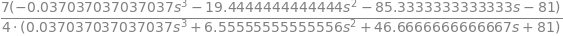

In [268]:
sub_values = {R:1, C:1/3}
H_sym1.subs(sub_values)

In [269]:
#| echo: false
H_num, H_denom = fraction(H_sym1.subs(sub_values)) #returns numerator and denominator

# convert symbolic to numpy polynomial
a = np.array(Poly(H_num, s).all_coeffs(), dtype=float)
b = np.array(Poly(H_denom, s).all_coeffs(), dtype=float)
sys_tf = signal.TransferFunction(a,b)

The poles and zeros of the transfer function are plotted below:

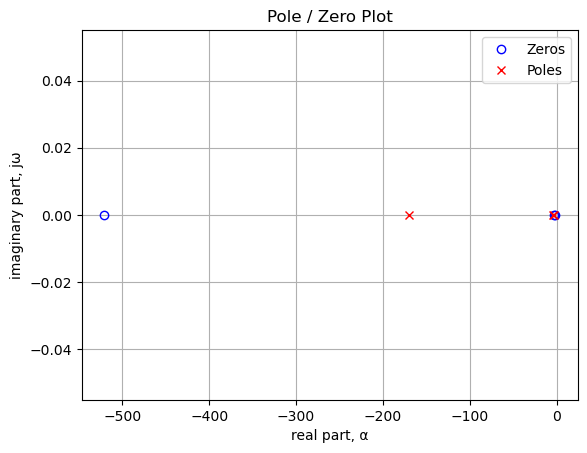

In [270]:
#| echo: false
#| fig-cap: fig cap
sys_zeros = np.roots(sys_tf.num)
sys_poles = np.roots(sys_tf.den)

plt.plot(np.real(sys_zeros), np.imag(sys_zeros), 'ob', markerfacecolor='none')
plt.plot(np.real(sys_poles), np.imag(sys_poles), 'xr')
plt.legend(['Zeros', 'Poles'], loc=0)
plt.title('Pole / Zero Plot')
plt.xlabel('real part, \u03B1')
plt.ylabel('imaginary part, j\u03C9')
plt.grid()
plt.show()

The units of the poles and zeros are in radian frequency and are tabulated below.

In [271]:
#| echo: false
#| tbl-cap: table of poles and zeros

table_header = ['Zeros, rad/s', 'Poles, rad/s']
num_table_rows = max(len(sys_zeros),len(sys_poles))
table_row = []

for i in range(num_table_rows):
    if i < len(sys_zeros):
        z = '{:.2f}'.format(sys_zeros[i])
    else:
        z = ''
    if i < len(sys_poles):
        p = '{:.2f}'.format(sys_poles[i])
    else:
        p = ''
    table_row.append([z,p])

print(tabulate(table_row, headers=table_header,colalign = ('left','left'),tablefmt="simple"))

Zeros, rad/s    Poles, rad/s
--------------  --------------
-520.58         -169.65
-3.03           -4.46
-1.39           -2.89


The values of the poles network are the same a chosen above, thus validating the solution.

The magnitude and phase of the filter's transfer function is plotted below.

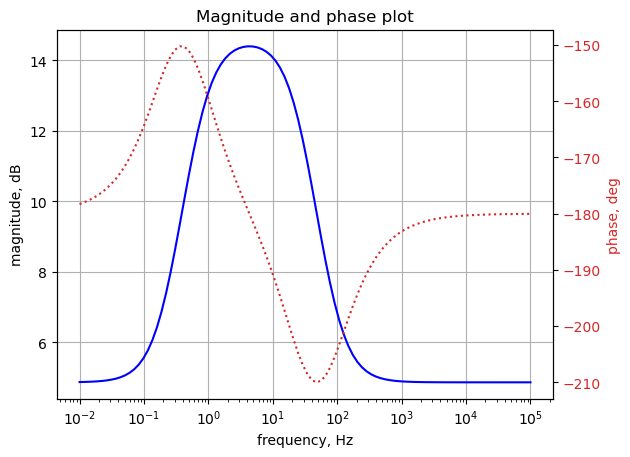

In [272]:
#| echo: false
#| fig-cap: fig cap

x = np.logspace(-2, 5, 100, endpoint=True)*2*np.pi
w, mag, phase = signal.bode(sys_tf, w=x) # returns: rad/s, mag in dB, phase in deg

fig, ax1 = plt.subplots()
ax1.set_ylabel('magnitude, dB')
ax1.set_xlabel('frequency, Hz')

plt.semilogx(w/(2*np.pi), mag,'-b')    # magnitude plot
#ax1.set_ylim(-1,1)
ax1.tick_params(axis='y')
plt.grid()

# instantiate a second y-axes that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:red'

plt.semilogx(w/(2*np.pi), phase,':',color='tab:red')  # phase plot

ax2.set_ylabel('phase, deg',color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Magnitude and phase plot')
plt.show()

The step response is plotted below.

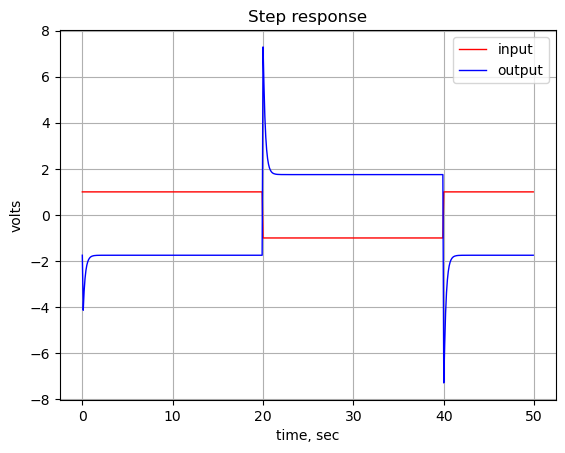

In [273]:
#| echo: false
#| fig-cap: fig cap

# define the time interval and create a square wave step waveform.
t = np.linspace(0, 50, 500, endpoint=False)
sqr_signal = signal.square(2*np.pi*0.025*t, duty=0.5)

# call lsim to generate the response signal
t_step, y_step, x_step = signal.lsim(sys_tf, U=sqr_signal, T=t)

plt.plot(t_step, sqr_signal, 'r', alpha = 1.0, linewidth=1, label='input')
plt.plot(t_step, y_step,'b', linewidth = 1.0, label='output')
plt.title('Step response')
plt.ylabel('volts')
plt.xlabel('time, sec')
plt.grid()
plt.legend(loc='best')
# show plot
plt.show()

# Twin-T-variation 10a


![](Twin-T-variation10a.png)

In [2]:
example_net_list = '''
* Twin-T-variation10a.asc
R1 3 1 1
R2 4 5 1
R3 5 0 1
C1 5 1 1
C2 4 3 1
C3 3 0 1
V1 1 0 1
O1 6 7 2
R4 7 4 1
R5 6 1 1
R6 2 6 1
'''

In [3]:
#| echo: true
report, network_df, df2, A, X, Z = SymMNA.smna(example_net_list)

X = Matrix(X)
Z = Matrix(Z)

NE_sym = Eq(A*X,Z)

var(str(NE_sym.free_symbols).replace('{','').replace('}',''))
nominal_component_value = SymMNA.get_part_values(network_df)

# N is the variation number
U_sym = solve(NE_sym,X)
H_sym = cancel(U_sym[v2]/U_sym[v1],s)

#| echo: false
Markdown('$H(s)={:s}$'.format(latex(H_sym)))

$H(s)=\frac{- C_{1} C_{2} C_{3} R_{1} R_{2} R_{3} R_{6} s^{3} - R_{6} + s^{2} \left(C_{1} C_{2} R_{1} R_{3} R_{5} + C_{1} C_{2} R_{2} R_{3} R_{5} + C_{1} C_{3} R_{1} R_{3} R_{5} - C_{2} C_{3} R_{1} R_{2} R_{6} - C_{2} C_{3} R_{1} R_{3} R_{6}\right) + s \left(C_{1} R_{3} R_{5} - C_{2} R_{1} R_{6} + C_{2} R_{2} R_{5} + C_{2} R_{3} R_{5} - C_{3} R_{1} R_{6}\right)}{C_{1} C_{2} C_{3} R_{1} R_{2} R_{3} R_{5} s^{3} + R_{5} + s^{2} \left(C_{1} C_{2} R_{1} R_{3} R_{5} + C_{1} C_{2} R_{2} R_{3} R_{5} + C_{1} C_{3} R_{1} R_{3} R_{5} + C_{2} C_{3} R_{1} R_{2} R_{5} + C_{2} C_{3} R_{1} R_{3} R_{5}\right) + s \left(C_{1} R_{3} R_{5} + C_{2} R_{1} R_{5} + C_{2} R_{2} R_{5} + C_{2} R_{3} R_{5} + C_{3} R_{1} R_{5}\right)}$

Making the substitutions:

{R1:R,R3:R,R5:R,R6:R, C1:C, C3:C}


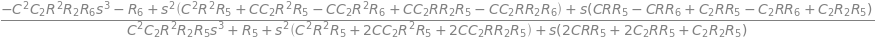

In [28]:
H_sym_reduced = H_sym.subs({R1:R, R3:R, C1:C, C3:C})
H_sym_reduced

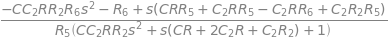

In [35]:
H_sym_reduced.simplify().collect(s)

In [29]:
H_sym_num, H_sym_denom = fraction(H_sym_reduced,s) #returns numerator and denominator

In [30]:
H_sym_num

In [31]:
H_sym_num.factor(s)

In [32]:
H_sym_denom

In [33]:
H_sym_denom.factor(s)

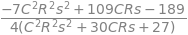

In [277]:
sub_values = {R1:R, R2:R, R3:R, R4:1, R5:4, R6:7, C1:C, C2:C/27, C3:C}
H_sym.subs(sub_values).simplify()

In [278]:
#| echo: false
H_sym1 = H_sym.subs(sub_values).simplify()
Markdown('$H(s)={:s}$'.format(latex(H_sym1)))

$H(s)=\frac{- 7 C^{2} R^{2} s^{2} + 109 C R s - 189}{4 \left(C^{2} R^{2} s^{2} + 30 C R s + 27\right)}$

In [279]:
#| echo: false
H_sym_num, H_sym_denom = fraction(H_sym1,s) #returns numerator and denominator

In [280]:
H_sym_num = H_sym_num.expand().collect(s)

In [281]:
H_sym_num

In [282]:
H_sym_denom = H_sym_denom.expand().collect(s)

The numerator polynominal is:

In [283]:
#| echo: false
Markdown('$N(s)={:s}$'.format(latex(H_sym_num)))

$N(s)=- 7 C^{2} R^{2} s^{2} + 109 C R s - 189$

In [284]:
#| echo: false
num_root_sym = solve(H_sym_num,s)
Markdown('${:s}$'.format(latex(num_root_sym)))

$\left[ \frac{109 - \sqrt{6589}}{14 C R}, \  \frac{\sqrt{6589} + 109}{14 C R}\right]$

The denominator polynominal is:

In [285]:
#| echo: false
Markdown('$D(s)={:s}$'.format(latex(H_sym_denom)))

$D(s)=4 C^{2} R^{2} s^{2} + 120 C R s + 108$

The roots of the denominator polynominal can found with SymPy.

In [286]:
#| echo: false
denom_root_sym = solve(H_sym_denom,s)
Markdown('${:s}$'.format(latex(denom_root_sym)))

$\left[ \frac{3 \left(-5 - \sqrt{22}\right)}{C R}, \  \frac{3 \left(-5 + \sqrt{22}\right)}{C R}\right]$

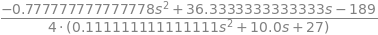

In [287]:
sub_values = {R:1, C:1/3}
H_sym1.subs(sub_values)

In [288]:
#| echo: false
H_num, H_denom = fraction(H_sym1.subs(sub_values)) #returns numerator and denominator

# convert symbolic to numpy polynomial
a = np.array(Poly(H_num, s).all_coeffs(), dtype=float)
b = np.array(Poly(H_denom, s).all_coeffs(), dtype=float)
sys_tf = signal.TransferFunction(a,b)

The poles and zeros of the transfer function are plotted below:

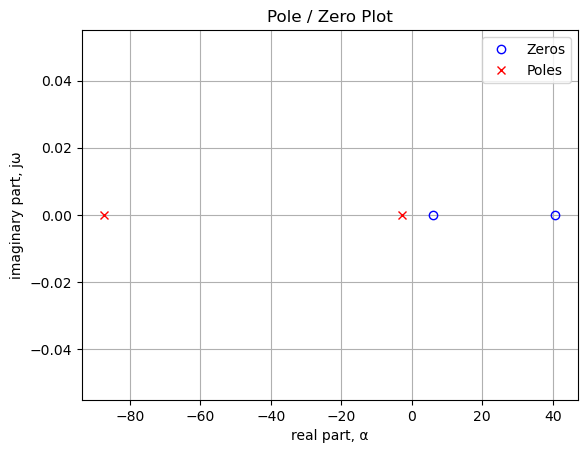

In [289]:
#| echo: false
#| fig-cap: fig cap
sys_zeros = np.roots(sys_tf.num)
sys_poles = np.roots(sys_tf.den)

plt.plot(np.real(sys_zeros), np.imag(sys_zeros), 'ob', markerfacecolor='none')
plt.plot(np.real(sys_poles), np.imag(sys_poles), 'xr')
plt.legend(['Zeros', 'Poles'], loc=0)
plt.title('Pole / Zero Plot')
plt.xlabel('real part, \u03B1')
plt.ylabel('imaginary part, j\u03C9')
plt.grid()
plt.show()

The units of the poles and zeros are in radian frequency and are tabulated below.

In [290]:
#| echo: false
#| tbl-cap: table of poles and zeros

table_header = ['Zeros, rad/s', 'Poles, rad/s']
num_table_rows = max(len(sys_zeros),len(sys_poles))
table_row = []

for i in range(num_table_rows):
    if i < len(sys_zeros):
        z = '{:.2f}'.format(sys_zeros[i])
    else:
        z = ''
    if i < len(sys_poles):
        p = '{:.2f}'.format(sys_poles[i])
    else:
        p = ''
    table_row.append([z,p])

print(tabulate(table_row, headers=table_header,colalign = ('left','left'),tablefmt="simple"))

Zeros, rad/s    Poles, rad/s
--------------  --------------
40.75           -87.21
5.96            -2.79


The values of the poles network are the same a chosen above, thus validating the solution.

The magnitude and phase of the filter's transfer function is plotted below.

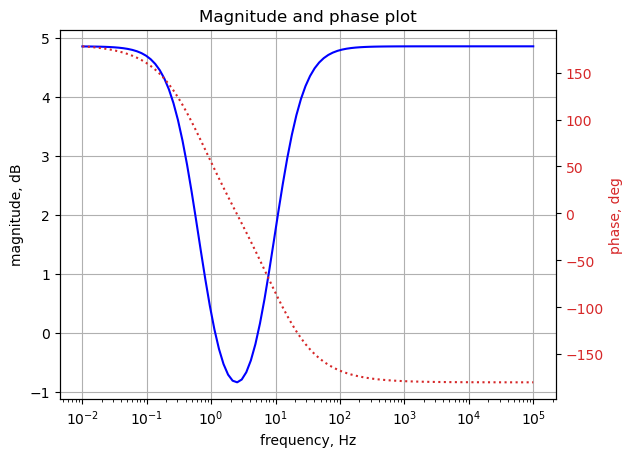

In [291]:
#| echo: false
#| fig-cap: fig cap

x = np.logspace(-2, 5, 100, endpoint=True)*2*np.pi
w, mag, phase = signal.bode(sys_tf, w=x) # returns: rad/s, mag in dB, phase in deg

fig, ax1 = plt.subplots()
ax1.set_ylabel('magnitude, dB')
ax1.set_xlabel('frequency, Hz')

plt.semilogx(w/(2*np.pi), mag,'-b')    # magnitude plot
#ax1.set_ylim(-1,1)
ax1.tick_params(axis='y')
plt.grid()

# instantiate a second y-axes that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:red'

plt.semilogx(w/(2*np.pi), phase,':',color='tab:red')  # phase plot

ax2.set_ylabel('phase, deg',color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Magnitude and phase plot')
plt.show()

The step response is plotted below.

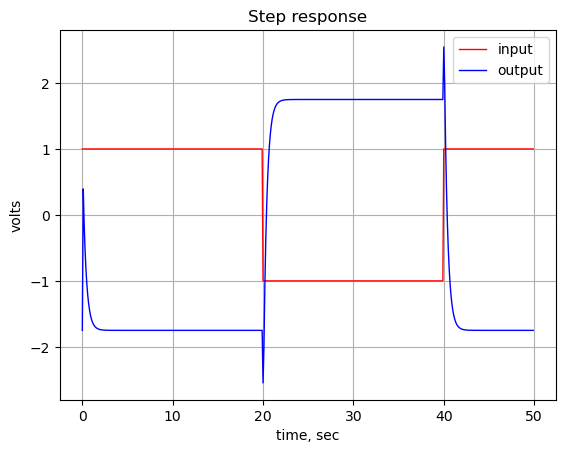

In [292]:
#| echo: false
#| fig-cap: fig cap

# define the time interval and create a square wave step waveform.
t = np.linspace(0, 50, 500, endpoint=False)
sqr_signal = signal.square(2*np.pi*0.025*t, duty=0.5)

# call lsim to generate the response signal
t_step, y_step, x_step = signal.lsim(sys_tf, U=sqr_signal, T=t)

plt.plot(t_step, sqr_signal, 'r', alpha = 1.0, linewidth=1, label='input')
plt.plot(t_step, y_step,'b', linewidth = 1.0, label='output')
plt.title('Step response')
plt.ylabel('volts')
plt.xlabel('time, sec')
plt.grid()
plt.legend(loc='best')
# show plot
plt.show()

# Twin-T-variation 10b

![](Twin-T-variation10b.png)

In [161]:
example_net_list = '''
* Twin-T-variation10b.asc
R1 3 1 1
R2 4 5 1
R3 5 0 1
C1 5 1 1
C2 4 3 1
C3 3 0 1
V1 1 0 1
O1 6 4 2
R5 6 1 1
R6 2 6 1
'''

In [162]:
#| echo: true
report, network_df, df2, A, X, Z = SymMNA.smna(example_net_list)

X = Matrix(X)
Z = Matrix(Z)

NE_sym = Eq(A*X,Z)

var(str(NE_sym.free_symbols).replace('{','').replace('}',''))
nominal_component_value = SymMNA.get_part_values(network_df)

# N is the variation number
U_sym = solve(NE_sym,X)
H_sym = cancel(U_sym[v2]/U_sym[v1],s)

#| echo: false
Markdown('$H(s)={:s}$'.format(latex(H_sym)))

$H(s)=\frac{- C_{1} C_{2} C_{3} R_{1} R_{2} R_{3} R_{6} s^{3} - R_{6} + s^{2} \left(C_{1} C_{2} R_{1} R_{3} R_{5} + C_{1} C_{2} R_{2} R_{3} R_{5} + C_{1} C_{3} R_{1} R_{3} R_{5} - C_{2} C_{3} R_{1} R_{2} R_{6} - C_{2} C_{3} R_{1} R_{3} R_{6}\right) + s \left(C_{1} R_{3} R_{5} - C_{2} R_{1} R_{6} + C_{2} R_{2} R_{5} + C_{2} R_{3} R_{5} - C_{3} R_{1} R_{6}\right)}{C_{1} C_{2} C_{3} R_{1} R_{2} R_{3} R_{5} s^{3} + R_{5} + s^{2} \left(C_{1} C_{2} R_{1} R_{3} R_{5} + C_{1} C_{2} R_{2} R_{3} R_{5} + C_{1} C_{3} R_{1} R_{3} R_{5} + C_{2} C_{3} R_{1} R_{2} R_{5} + C_{2} C_{3} R_{1} R_{3} R_{5}\right) + s \left(C_{1} R_{3} R_{5} + C_{2} R_{1} R_{5} + C_{2} R_{2} R_{5} + C_{2} R_{3} R_{5} + C_{3} R_{1} R_{5}\right)}$

Making the substitutions:

{R1:R,R3:R,R5:R,R6:R, C1:C, C3:C}


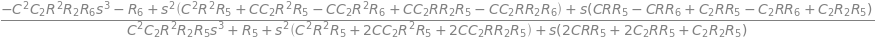

In [163]:
H_sym_reduced = H_sym.subs({R1:R, R3:R, C1:C, C3:C})
H_sym_reduced

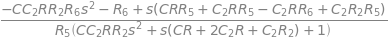

In [164]:
H_sym_reduced.simplify().collect(s)

In [165]:
H_sym_num, H_sym_denom = fraction(H_sym_reduced,s) #returns numerator and denominator

In [166]:
H_sym_num

In [167]:
H_sym_num.factor(s)

In [168]:
H_sym_denom

In [169]:
H_sym_denom.factor(s)

In [562]:
H_sym_num, H_sym_denom = fraction(H_sym_reduced.simplify().collect(s),s) #returns numerator and denominator

In [563]:
z = solve(H_sym_num, s)

This is an all pass: {R:4, C:1/4, C2:1/2, R2:2, R5:2, R6:1}

In [564]:
sub_values = {R:R*4, C:1/(4*C), C2:1/(2*C), R2:2*R, R5:2*R, R6:R} #{R:40, C:1/40, C2:1/20, R2:20, R5:20, R6:10} # {R:4, C:1/4, C2:1/2, R2:2, R5:2, R6:1}

In [565]:
sub_values1 = {R:250,C:1e+2}

In [566]:
z[0].subs(sub_values).subs(sub_values1)

In [567]:
z[1].subs(sub_values).subs(sub_values1)

In [568]:
p = solve(H_sym_denom, s)

In [569]:
p[0].subs(sub_values).subs(sub_values1)

In [570]:
p[1].subs(sub_values).subs(sub_values1)

In [571]:
#| echo: false
H_num, H_denom = fraction(H_sym_reduced.subs(sub_values).subs(sub_values1)) #returns numerator and denominator

# convert symbolic to numpy polynomial
a = np.array(Poly(H_num, s).all_coeffs(), dtype=float)
b = np.array(Poly(H_denom, s).all_coeffs(), dtype=float)
sys_tf = signal.TransferFunction(a,b)

The poles and zeros of the transfer function are plotted below:

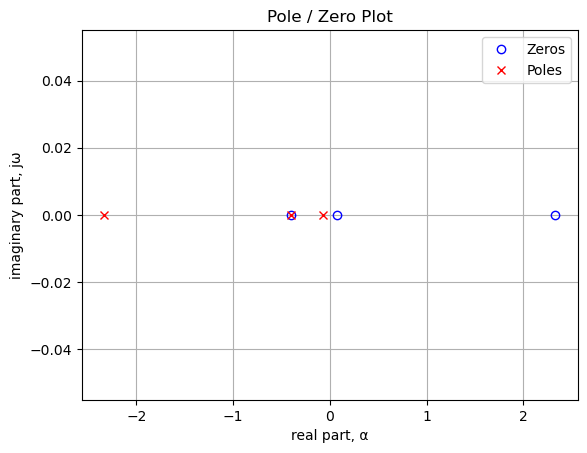

In [572]:
#| echo: false
#| fig-cap: fig cap
sys_zeros = np.roots(sys_tf.num)
sys_poles = np.roots(sys_tf.den)

plt.plot(np.real(sys_zeros), np.imag(sys_zeros), 'ob', markerfacecolor='none')
plt.plot(np.real(sys_poles), np.imag(sys_poles), 'xr')
plt.legend(['Zeros', 'Poles'], loc=0)
plt.title('Pole / Zero Plot')
plt.xlabel('real part, \u03B1')
plt.ylabel('imaginary part, j\u03C9')
plt.grid()
plt.show()

The units of the poles and zeros are in radian frequency and are tabulated below.

In [573]:
#| echo: false
#| tbl-cap: table of poles and zeros

table_header = ['Zeros, rad/s', 'Poles, rad/s']
num_table_rows = max(len(sys_zeros),len(sys_poles))
table_row = []

for i in range(num_table_rows):
    if i < len(sys_zeros):
        z = '{:.2f}'.format(sys_zeros[i])
    else:
        z = ''
    if i < len(sys_poles):
        p = '{:.2f}'.format(sys_poles[i])
    else:
        p = ''
    table_row.append([z,p])

print(tabulate(table_row, headers=table_header,colalign = ('left','left'),tablefmt="simple"))

Zeros, rad/s    Poles, rad/s
--------------  --------------
2.33            -2.33
-0.4            -0.4
0.07            -0.07


The values of the poles network are the same a chosen above, thus validating the solution.

The magnitude and phase of the filter's transfer function is plotted below.

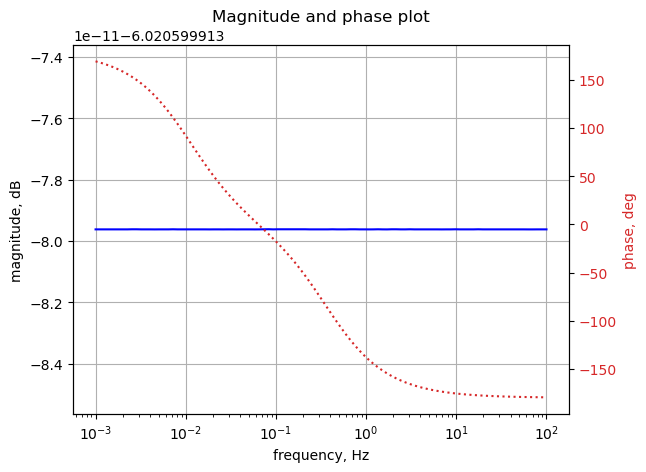

In [574]:
#| echo: false
#| fig-cap: fig cap

x = np.logspace(-3, 2, 100, endpoint=True)*2*np.pi
w, mag, phase = signal.bode(sys_tf, w=x) # returns: rad/s, mag in dB, phase in deg

fig, ax1 = plt.subplots()
ax1.set_ylabel('magnitude, dB')
ax1.set_xlabel('frequency, Hz')

plt.semilogx(w/(2*np.pi), mag,'-b')    # magnitude plot
#ax1.set_ylim(-1,1)
ax1.tick_params(axis='y')
plt.grid()

# instantiate a second y-axes that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:red'

plt.semilogx(w/(2*np.pi), phase,':',color='tab:red')  # phase plot

ax2.set_ylabel('phase, deg',color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Magnitude and phase plot')
plt.show()

The step response is plotted below.

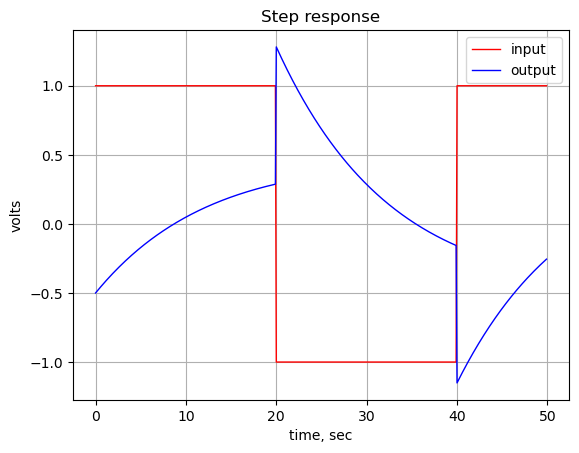

In [481]:
#| echo: false
#| fig-cap: fig cap

# define the time interval and create a square wave step waveform.
t = np.linspace(0, 50, 500, endpoint=False)
sqr_signal = signal.square(2*np.pi*0.025*t, duty=0.5)

# call lsim to generate the response signal
t_step, y_step, x_step = signal.lsim(sys_tf, U=sqr_signal, T=t)

plt.plot(t_step, sqr_signal, 'r', alpha = 1.0, linewidth=1, label='input')
plt.plot(t_step, y_step,'b', linewidth = 1.0, label='output')
plt.title('Step response')
plt.ylabel('volts')
plt.xlabel('time, sec')
plt.grid()
plt.legend(loc='best')
# show plot
plt.show()